# Notebook to train the Hybrid ResNet-ViT

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, accuracy_score, recall_score
from data_utils_torch import get_paths_and_labels, calculate_min_max, create_dataloader, extract_subject_id
from plotting_utils_torch import view_image, view_random_image, plot_loss_curves, make_confusion_matrix, view_image_data
from sklearn.model_selection import StratifiedGroupKFold
import gc
from tqdm.auto import tqdm
from monai.networks.nets import ResNet
from models3D import ResnetFeatureExtractor, ResNetViT
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility    
seed = 10
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Set mixed precision     
USE_AMP = True if device.type == 'cuda' else False
scaler = GradScaler(enabled=USE_AMP)
print(f"Automatic Mixed Precision (AMP) enabled: {USE_AMP}")

/home/diogommiranda/tese/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-14 00:27:43.590087: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-14 00:27:44.385391: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda
Automatic Mixed Precision (AMP) enabled: True


In [2]:
NORMALIZATION = "mni_reg_CV" # Name of the directory with the datasets
DATASET = "smci_pmci" # Choose dataset: "smci_pmci" or "nc_ad"
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET images
BATCH_SIZE = 16 # Set batch size

USE_MASK = False # Set to True to use the ROI mask at the input-image level, False to use the whole brain

if USE_MASK:
    ROI_MASK_PATH = str(Path("/home/diogommiranda/tese/masks/ROI_MASK.nii"))
else:
    ROI_MASK_PATH = None

# Get train paths and labels to calculate minmax values
train_paths, train_labels, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

# Calculate minmax values for train set
minmax_min, minmax_max = calculate_min_max(train_paths)

# Create train dataset
train_data = create_dataloader(
    paths=train_paths,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max, 
    mask_path=ROI_MASK_PATH
    )

# Create test set with the minmax values from train
test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map=class_map)
test_data = create_dataloader(
    paths=test_paths,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False,
    seed=None,
    min_val=minmax_min, 
    max_val=minmax_max,
    mask_path=ROI_MASK_PATH
    )

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/train...
    Found 575 files for class 'smci'
    Found 314 files for class 'pmci'
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/test...
    Found 143 files for class 'smci'
    Found 78 files for class 'pmci'


torch.Size([1, 91, 109, 91])


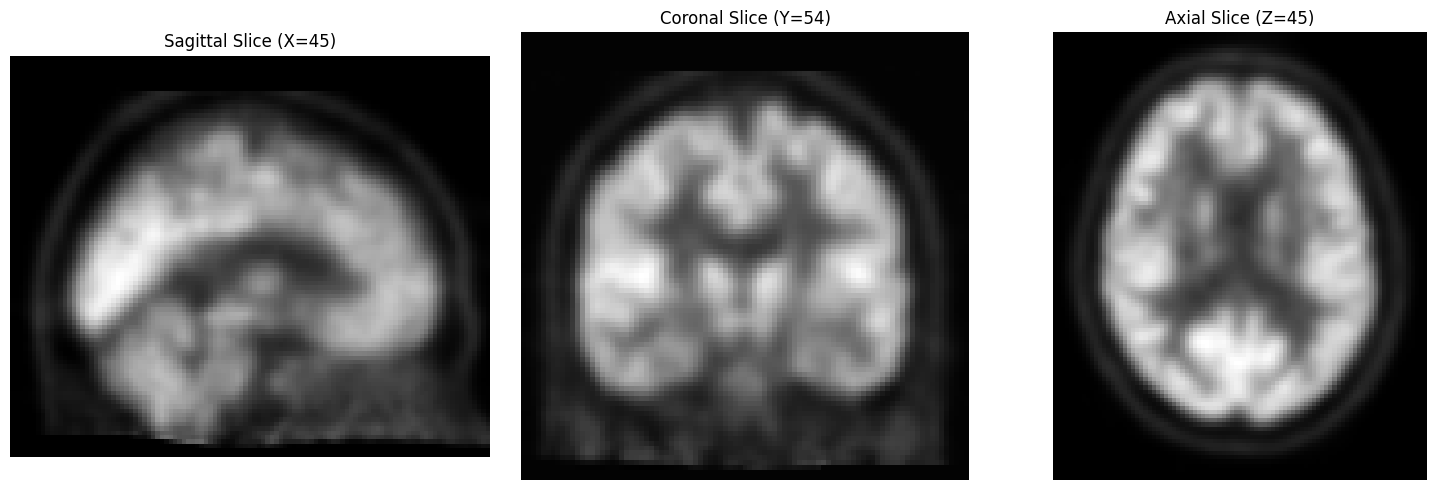

In [3]:
# Verify data with a test sample
i = 1
for data, label in test_data:
    view_image_data(data[i])
    #data[i] = torch.flip(data[i], dims=[3])
    #view_image_data(data[i])
    print(data[i].shape)
    break

In [ ]:
use_pretrained = True
if use_pretrained:
    if DATASET == "nc_ad":
        # Use pretrained resnet for nc_ad classification task
        resnet_path = "/home/diogommiranda/tese/outputs/torch/full_brain/nc_ad/fixed_lr/saved_models/16B/LR=2.0e-05_WD=2e-04/model.pth"
    else:
        # Use pretrained resnet for smci_pmci classification task
        resnet_path = "/home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/saved_models/16B/LR=1.0e-05_WD=2e-04 (60)/model.pth"
    dir1 = "pretrain/"
    print('Using pretrained weights from path:', resnet_path)
else:
    resnet_path = None
    dir1 = "no_pretrain/"
    print('Not using pretrained weights.')
    
resnet_config = {
    'block': 'basic',
    'layers': [3, 4, 6, 3],
    'block_inplanes': [64, 128, 256, 512],
    'spatial_dims': 3,
    'n_input_channels': 1,
    'conv1_t_stride': 2,
    'num_classes': 1, 
    'shortcut_type': 'B',
    'bias_downsample': False
}

vit_config = {
    'in_channels': 256,
    'img_size': (6,7,6),
    'patch_size': (1,1,1),
    'num_heads': 6,
    'hidden_size': 384,
    'mlp_dim': 1536,
    'num_layers': 4,
    'proj_type': 'perceptron',
    'pos_embed_type': 'sincos',
    'classification': True,
    'num_classes': 1,
    'dropout_rate': 0.2,
    'spatial_dims': 3,
    'post_activation': 'none',
    'qkv_bias': False,
    'save_attn': False
}

pure_vit_config = {
    'in_channels': 1,
    'img_size': (91,109,91),
    'patch_size': (16,16,16),
    'num_heads': 5,
    'hidden_size': 330,
    'mlp_dim': 1200,
    'num_layers': 6,
    'proj_type': 'perceptron',
    'pos_embed_type': 'sincos',
    'classification': True,
    'num_classes': 1,
    'dropout_rate': 0.0,
    'spatial_dims': 3,
    'post_activation': 'none',
    'qkv_bias': False,
    'save_attn': False
}


Using pretrained weights from path: /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/saved_models/16B/LR=1.0e-05_WD=2e-04 (60)/model.pth


In [ ]:
# ----- Hyperparameter Tuning with K-Fold Cross-Validation -----

N_SPLITS = 5 # Number of splits for cross-validation
NUM_EPOCHS = 500
EARLY_STOP_PATIENCE = 100
lr_scheduler = "fixed_lr" # Choose between "cosine_decay" or "fixed_lr"

use_optimizer = "adam" # Choose optimizer: "adam" or "sgd"
learning_rates = [2e-6, 4e-6, 8e-6, 2e-5, 4e-5]
weight_decays = [2e-4]

tuning_results = []
total_combinations = len(learning_rates) * len(weight_decays)
current_combination_no = 0

if lr_scheduler == "fixed_lr":
    dir2 = "fixed_lr/"
elif lr_scheduler == "cosine_decay":
    dir2 = "cosine_decay/"

dir3 = f"num_layers_{vit_config['num_layers']}/" 
dir4 = f"num_heads_{vit_config['num_heads']}/"

    
if lr_scheduler == "cosine_decay":
    RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/resnetvit/" + DATASET + "/" + dir1 + dir2 + str(BATCH_SIZE) + "B/" + dir3 + dir4
elif lr_scheduler == "fixed_lr":
    RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/resnetvit/" + DATASET + "/" + dir1 + dir2 + str(BATCH_SIZE) + "B/" + dir3 + dir4
else:
    raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
print(f"Results will be saved to: {RESULTS_BASE_DIR}")

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

print("\nStarting Hyperparameter Tuning Grid Search...")
overall_start_time = time.time()

# Hyperparameter tuning loop
for current_lr in learning_rates:
    for current_wd in weight_decays: 
        current_combination_no += 1
        print("=" * 60)
        print(f"Testing Combination {current_combination_no}/{total_combinations}: LR={current_lr:.1e}, WeightDecay={current_wd:.0e}")
        print("=" * 60)
        start_time_combination = time.time()

        combo_dir_name = f"LR0_{current_lr:.1e}_WD_{current_wd:.0e}" 
        combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)
        os.makedirs(combo_results_dir, exist_ok=True)
        print(f"  Saving results for this combo to: {combo_results_dir}")

        current_combo_val_losses = []
        current_combo_val_accuracies = []
        current_combo_val_aucs = []
        current_combo_best_epoch = []

        fold_no = 1

        # K-Fold Cross-Validation
        for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
            print("-" * 60)
            print(f"Training Fold {fold_no}/{N_SPLITS} for LR={current_lr:.1e} and WD={current_wd:.0e}...")
            start_time_fold = time.time()

            # Get paths and labels for the current fold
            fold_train_paths = train_paths[train_indices]
            fold_train_labels = train_labels[train_indices]
            fold_val_paths = train_paths[val_indices]
            fold_val_labels = train_labels[val_indices]

            # Verify subject separation
            train_subjects = set(subject_ids[train_indices])
            val_subjects = set(subject_ids[val_indices])
            if not train_subjects.isdisjoint(val_subjects):
                 raise RuntimeError(f"WARNING: Fold {fold_no} has overlapping subjects!")

            print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

            # Calculate minmax parameters for the current training fold
            fold_min, fold_max = calculate_min_max(fold_train_paths)

            # Create fold train dataset
            fold_train_data = create_dataloader(
                paths=fold_train_paths,
                labels=fold_train_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=True, 
                seed=seed,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            ) 
            
            # Create fold validation dataset
            fold_val_data = create_dataloader(
                paths=fold_val_paths,
                labels=fold_val_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False, 
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )

            if fold_train_data is None or fold_val_data is None:
                 raise RuntimeError(f"ERROR: Could not create datasets for fold {fold_no}.")
             
            # Compute class weights for the current fold
            unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
            print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
            pos_weight_val = class_counts[0] / class_counts[1]
            pos_weight_val = torch.tensor([pos_weight_val], device=device)
            print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

            # Create the model
            resnet_feature_extractor = ResnetFeatureExtractor(resnet_config=resnet_config, device=device, trained_path=resnet_path, use_pretrained=use_pretrained)
            model = ResNetViT(resnet_feature_extractor, vit_config).to(device)

            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)
            
            if use_optimizer == "adam":
                optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=current_lr, weight_decay=current_wd)
            elif use_optimizer == "sgd":
                optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=current_lr, weight_decay=current_wd, momentum=0.9, nesterov=True)
                    
            scheduler = None
            if lr_scheduler == "cosine_decay":
                print("\nUsing Cosine Annealing LR Scheduler.\n")
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-8)
    
            best_val_loss = float('inf')
            epochs_no_improve = 0
            best_epoch = 0
            best_model_state = None
            stopped_epoch = NUM_EPOCHS 

            # Initialize history for this fold
            history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': [], 'val_loss': [], 'val_accuracy': [], 'val_auc': []}

            for epoch in tqdm(range(NUM_EPOCHS)):
                epoch_start_time = time.time()
                history['epoch'].append(epoch + 1)

                # Train phase
                model.train()
                
                # Freeze BatchNorm layers if using pretrained model
                if use_pretrained: 
                    model.resnet_feature_extractor.eval()
                
                running_loss = 0.0
                train_pred_probs = []
                train_targets = []
                
                for i, (inputs, labels) in enumerate(fold_train_data):
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)
                    
                    optimizer.zero_grad()
                    
                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    
                    prob_outputs = torch.sigmoid(outputs)
                    train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
                    train_targets.extend(labels.detach().cpu().numpy())
 
                train_targets = np.array(train_targets).flatten()
                train_pred_probs = np.array(train_pred_probs).flatten()
                
                # Calculate training metrics for the epoch
                train_loss = running_loss / len(fold_train_data.dataset)
                train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
                train_auc = roc_auc_score(train_targets, train_pred_probs)
                history['train_loss'].append(train_loss)
                history['train_accuracy'].append(train_acc)
                history['train_auc'].append(train_auc)

                # Validation phase
                model.eval()
                val_running_loss = 0.0
                val_pred_probs = []
                val_targets = []

                with torch.inference_mode():
                    for inputs, labels in fold_val_data:
                        inputs = inputs.to(device)
                        labels = labels.float().unsqueeze(1).to(device)

                        # Mixed precision
                        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        val_running_loss += loss.item() * inputs.size(0)

                        prob_outputs = torch.sigmoid(outputs)
                        val_pred_probs.extend(prob_outputs.cpu().numpy())
                        val_targets.extend(labels.cpu().numpy())
                        
                val_targets = np.array(val_targets).flatten()
                val_pred_probs = np.array(val_pred_probs).flatten()

                # Calculate validation metrics for the epoch
                val_loss = val_running_loss / len(fold_val_data.dataset)
                val_acc = accuracy_score(val_targets, val_pred_probs >= 0.5)
                val_auc = roc_auc_score(val_targets, val_pred_probs)
                history['val_loss'].append(val_loss)
                history['val_accuracy'].append(val_acc)
                history['val_auc'].append(val_auc)

                # Print Epoch Summary
                epoch_duration = time.time() - epoch_start_time
                print(f"    Epoch {epoch+1}/{NUM_EPOCHS} [{epoch_duration:.2f}s] - "
                      f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f} | "
                      f"Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}")
                
                if scheduler:
                    scheduler.step()

                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    # Save the best model state
                    best_model_state = model.state_dict()
                    best_epoch = epoch + 1
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= EARLY_STOP_PATIENCE:
                    model.load_state_dict(best_model_state)
                    stopped_epoch = epoch + 1
                    print(f"\nEarly stopping triggered. Restoring best model weights from epoch {stopped_epoch - epochs_no_improve}.\n")
                    break
            
            # Restore the best model state if early stopping was not triggered
            if epochs_no_improve < EARLY_STOP_PATIENCE:
                print(f"Training completed for {NUM_EPOCHS} epochs. Restoring best model weights from epoch {best_epoch}.")
                model.load_state_dict(best_model_state)
            
            # Save fold history and plots
            fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
            os.makedirs(fold_dir, exist_ok=True)
            history_df = pd.DataFrame(history)
            history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
            history_df.to_csv(history_csv_path, index=False)
            plot_loss_curves(history, fold_dir)

            # Evaluate the fold
            best_epoch_index = np.argmin(history['val_loss'])
            best_epoch = best_epoch_index + 1
            val_loss_best = history['val_loss'][best_epoch_index]
            val_accuracy_best = history['val_accuracy'][best_epoch_index]
            val_auc_best = history['val_auc'][best_epoch_index]
            print(f"    Fold {fold_no} - Best Epoch {best_epoch}, Val Loss: {val_loss_best:.4f}, Acc: {val_accuracy_best:.4f}, AUC: {val_auc_best:.4f}")

            # Append results for this fold
            current_combo_val_losses.append(val_loss_best)
            current_combo_val_accuracies.append(val_accuracy_best)
            current_combo_val_aucs.append(val_auc_best)
            current_combo_best_epoch.append(best_epoch)
            
            optimizer_name = optimizer.__class__.__name__
            
            # Free resources
            del model, optimizer, criterion, scheduler, fold_train_data, fold_val_data, history, history_df, best_model_state
            if device.type == 'cuda':
                torch.cuda.empty_cache() 
            gc.collect() 
            
            end_time_fold = time.time()
            print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
            fold_no += 1

        # Aggregate results across folds
        avg_loss = np.mean(current_combo_val_losses)
        std_loss = np.std(current_combo_val_losses)
        avg_acc = np.mean(current_combo_val_accuracies)
        std_acc = np.std(current_combo_val_accuracies)
        avg_auc = np.mean(current_combo_val_aucs)
        std_auc = np.std(current_combo_val_aucs)

        print("-" * 50)
        print(f"Results for LR={current_lr}, WeightDecay={current_wd} (Across {N_SPLITS} Folds):")
        print(f"  Avg Val Loss: {avg_loss:.4f} +/- {std_loss:.4f}")
        print(f"  Avg Val Acc:  {avg_acc:.4f} +/- {std_acc:.4f}")
        print(f"  Avg Val AUC:  {avg_auc:.4f} +/- {std_auc:.4f}")
        print("-" * 50)

        combo_average_results = {
            'learning_rate': current_lr,
            'weight_decay': current_wd,
            'avg_val_loss': avg_loss,
            'std_val_loss': std_loss,
            'avg_val_accuracy': avg_acc,
            'std_val_accuracy': std_acc,
            'avg_val_auc': avg_auc,
            'std_val_auc': std_auc,
            'individual_losses': [round(loss, 4) for loss in current_combo_val_losses],
            'individual_accuracies': [round(acc, 4) for acc in current_combo_val_accuracies],
            'individual_aucs': [round(auc, 4) for auc in current_combo_val_aucs],
            'best_epoch_per_fold': list(current_combo_best_epoch)
        }
        
        # Store results
        tuning_results.append(combo_average_results)
        
        end_time_combination = time.time()
        print(f"Combination {current_combination_no} finished in {end_time_combination - start_time_combination:.2f} seconds.")
        
        # Save results in a txt file and the parameters in a json file
        results_df = pd.DataFrame(combo_average_results)
        display_cols = list(combo_average_results.keys())
        
        results_file_path = os.path.join(combo_results_dir, "resultados.txt")
        with open(results_file_path, "w") as f:
            print("\nTuning Results Summary:", file=f)
            print(results_df[display_cols].round(6).to_string(index=False), file=f)

            print(f"\nHyperparameters: LR={current_lr:.1e}, Weight_decay={current_wd:.0e}", file=f)
        
        training_config = {
            "vit_config": vit_config,
            "num_folds": N_SPLITS,
            "num_epochs": NUM_EPOCHS,
            "early_stop_patience": EARLY_STOP_PATIENCE,
            "lr_scheduler": lr_scheduler,
            "optimizer": optimizer_name,
            "optimizer_params": {
                "lr": float(current_lr),
                "weight_decay": float(current_wd)
            },
            "batch_size": BATCH_SIZE,
            "seed": seed,
            "dataset": DATASET
        }
        params_file_path = os.path.join(combo_results_dir, "training_config.json")
        with open(params_file_path, "w") as f:
            json.dump(training_config, f, indent=4)


Results will be saved to: /home/diogommiranda/tese/outputs/resnetvit/smci_pmci/pretrain/fixed_lr/16B/num_layers_4/num_heads_5/

Starting Hyperparameter Tuning Grid Search...
Testing Combination 1/2: LR=8.0e-06, WeightDecay=2e-04
  Saving results for this combo to: /home/diogommiranda/tese/outputs/resnetvit/smci_pmci/pretrain/fixed_lr/16B/num_layers_4/num_heads_5/LR0_8.0e-06_WD_2e-04
------------------------------------------------------------
Training Fold 1/5 for LR=8.0e-06 and WD=2e-04...
  Train samples: 726, Validation samples: 163
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 472, 1: 254}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8583
Loading pretrained weights from path /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/saved_models/16B/LR=1.0e-05_WD=2e-04 (60)/model.pth



  0%|          | 1/500 [00:05<47:56,  5.76s/it]

    Epoch 1/500 [5.76s] - Train Loss: 0.91644, Train Acc: 0.50551 | Val Loss: 0.94280, Val Acc: 0.63190


  0%|          | 2/500 [00:09<37:47,  4.55s/it]

    Epoch 2/500 [3.70s] - Train Loss: 0.92141, Train Acc: 0.53168 | Val Loss: 0.90335, Val Acc: 0.36810


  1%|          | 3/500 [00:13<34:11,  4.13s/it]

    Epoch 3/500 [3.62s] - Train Loss: 0.92094, Train Acc: 0.51791 | Val Loss: 0.94682, Val Acc: 0.36810


  1%|          | 4/500 [00:16<32:21,  3.91s/it]

    Epoch 4/500 [3.59s] - Train Loss: 0.92385, Train Acc: 0.49174 | Val Loss: 0.91216, Val Acc: 0.36810


  1%|          | 5/500 [00:20<31:42,  3.84s/it]

    Epoch 5/500 [3.71s] - Train Loss: 0.90172, Train Acc: 0.51791 | Val Loss: 0.89933, Val Acc: 0.36810


  1%|          | 6/500 [00:23<30:55,  3.76s/it]

    Epoch 6/500 [3.59s] - Train Loss: 0.90744, Train Acc: 0.49311 | Val Loss: 0.89746, Val Acc: 0.36810


  1%|▏         | 7/500 [00:27<30:22,  3.70s/it]

    Epoch 7/500 [3.57s] - Train Loss: 0.89521, Train Acc: 0.55510 | Val Loss: 0.89553, Val Acc: 0.36810


  2%|▏         | 8/500 [00:31<29:58,  3.66s/it]

    Epoch 8/500 [3.56s] - Train Loss: 0.90543, Train Acc: 0.49587 | Val Loss: 0.89775, Val Acc: 0.65644


  2%|▏         | 9/500 [00:34<29:37,  3.62s/it]

    Epoch 9/500 [3.55s] - Train Loss: 0.90587, Train Acc: 0.54683 | Val Loss: 0.90368, Val Acc: 0.63190


  2%|▏         | 10/500 [00:38<29:24,  3.60s/it]

    Epoch 10/500 [3.55s] - Train Loss: 0.89895, Train Acc: 0.55785 | Val Loss: 0.89075, Val Acc: 0.36810


  2%|▏         | 11/500 [00:41<29:21,  3.60s/it]

    Epoch 11/500 [3.60s] - Train Loss: 0.89342, Train Acc: 0.52617 | Val Loss: 0.88783, Val Acc: 0.44172


  2%|▏         | 12/500 [00:45<29:13,  3.59s/it]

    Epoch 12/500 [3.57s] - Train Loss: 0.90844, Train Acc: 0.51102 | Val Loss: 0.89382, Val Acc: 0.64417


  3%|▎         | 13/500 [00:48<29:04,  3.58s/it]

    Epoch 13/500 [3.55s] - Train Loss: 0.88067, Train Acc: 0.59780 | Val Loss: 0.92478, Val Acc: 0.36810


  3%|▎         | 14/500 [00:52<28:59,  3.58s/it]

    Epoch 14/500 [3.57s] - Train Loss: 0.89484, Train Acc: 0.50689 | Val Loss: 0.89011, Val Acc: 0.64417


  3%|▎         | 15/500 [00:56<29:12,  3.61s/it]

    Epoch 15/500 [3.69s] - Train Loss: 0.89437, Train Acc: 0.55234 | Val Loss: 0.88229, Val Acc: 0.36810


  3%|▎         | 16/500 [00:59<29:03,  3.60s/it]

    Epoch 16/500 [3.57s] - Train Loss: 0.88131, Train Acc: 0.55510 | Val Loss: 0.88365, Val Acc: 0.65031


  3%|▎         | 17/500 [01:03<28:58,  3.60s/it]

    Epoch 17/500 [3.59s] - Train Loss: 0.90713, Train Acc: 0.54959 | Val Loss: 0.87267, Val Acc: 0.44785


  4%|▎         | 18/500 [01:06<28:52,  3.59s/it]

    Epoch 18/500 [3.58s] - Train Loss: 0.88329, Train Acc: 0.55510 | Val Loss: 0.88151, Val Acc: 0.36810


  4%|▍         | 19/500 [01:10<28:57,  3.61s/it]

    Epoch 19/500 [3.65s] - Train Loss: 0.87591, Train Acc: 0.56887 | Val Loss: 0.86664, Val Acc: 0.73006


  4%|▍         | 20/500 [01:14<29:32,  3.69s/it]

    Epoch 20/500 [3.88s] - Train Loss: 0.88495, Train Acc: 0.57989 | Val Loss: 0.85592, Val Acc: 0.77301


  4%|▍         | 21/500 [01:18<29:55,  3.75s/it]

    Epoch 21/500 [3.87s] - Train Loss: 0.86992, Train Acc: 0.58402 | Val Loss: 0.84870, Val Acc: 0.60123


  4%|▍         | 22/500 [01:22<29:41,  3.73s/it]

    Epoch 22/500 [3.68s] - Train Loss: 0.86181, Train Acc: 0.61708 | Val Loss: 0.83956, Val Acc: 0.82209


  5%|▍         | 23/500 [01:25<29:16,  3.68s/it]

    Epoch 23/500 [3.58s] - Train Loss: 0.83940, Train Acc: 0.62672 | Val Loss: 0.81746, Val Acc: 0.83436


  5%|▍         | 24/500 [01:29<28:58,  3.65s/it]

    Epoch 24/500 [3.58s] - Train Loss: 0.83211, Train Acc: 0.66116 | Val Loss: 0.78878, Val Acc: 0.77301


  5%|▌         | 25/500 [01:32<28:47,  3.64s/it]

    Epoch 25/500 [3.59s] - Train Loss: 0.81708, Train Acc: 0.65427 | Val Loss: 0.74141, Val Acc: 0.85276


  5%|▌         | 26/500 [01:36<28:35,  3.62s/it]

    Epoch 26/500 [3.58s] - Train Loss: 0.80936, Train Acc: 0.65014 | Val Loss: 0.90029, Val Acc: 0.36810


  5%|▌         | 27/500 [01:40<28:31,  3.62s/it]

    Epoch 27/500 [3.62s] - Train Loss: 0.74484, Train Acc: 0.70110 | Val Loss: 0.63553, Val Acc: 0.71779


  6%|▌         | 28/500 [01:43<28:22,  3.61s/it]

    Epoch 28/500 [3.58s] - Train Loss: 0.66164, Train Acc: 0.74242 | Val Loss: 0.99414, Val Acc: 0.71166


  6%|▌         | 29/500 [01:47<28:11,  3.59s/it]

    Epoch 29/500 [3.56s] - Train Loss: 0.71581, Train Acc: 0.69697 | Val Loss: 0.75639, Val Acc: 0.77301


  6%|▌         | 30/500 [01:50<28:07,  3.59s/it]

    Epoch 30/500 [3.58s] - Train Loss: 0.60609, Train Acc: 0.77824 | Val Loss: 0.54254, Val Acc: 0.77301


  6%|▌         | 31/500 [01:54<27:59,  3.58s/it]

    Epoch 31/500 [3.56s] - Train Loss: 0.52489, Train Acc: 0.81405 | Val Loss: 0.44832, Val Acc: 0.85890


  6%|▋         | 32/500 [01:57<27:53,  3.58s/it]

    Epoch 32/500 [3.56s] - Train Loss: 0.53017, Train Acc: 0.81543 | Val Loss: 0.44830, Val Acc: 0.85890


  7%|▋         | 33/500 [02:01<27:50,  3.58s/it]

    Epoch 33/500 [3.58s] - Train Loss: 0.45630, Train Acc: 0.83747 | Val Loss: 0.46046, Val Acc: 0.87117


  7%|▋         | 34/500 [02:04<27:43,  3.57s/it]

    Epoch 34/500 [3.55s] - Train Loss: 0.47079, Train Acc: 0.84160 | Val Loss: 0.49286, Val Acc: 0.86503


  7%|▋         | 35/500 [02:08<27:37,  3.57s/it]

    Epoch 35/500 [3.55s] - Train Loss: 0.47418, Train Acc: 0.84711 | Val Loss: 0.41645, Val Acc: 0.88344


  7%|▋         | 36/500 [02:12<27:36,  3.57s/it]

    Epoch 36/500 [3.58s] - Train Loss: 0.48915, Train Acc: 0.82231 | Val Loss: 0.40780, Val Acc: 0.87730


  7%|▋         | 37/500 [02:15<27:35,  3.58s/it]

    Epoch 37/500 [3.59s] - Train Loss: 0.44950, Train Acc: 0.85124 | Val Loss: 0.40945, Val Acc: 0.88344


  8%|▊         | 38/500 [02:19<27:29,  3.57s/it]

    Epoch 38/500 [3.56s] - Train Loss: 0.44227, Train Acc: 0.85950 | Val Loss: 0.55190, Val Acc: 0.81595


  8%|▊         | 39/500 [02:22<27:30,  3.58s/it]

    Epoch 39/500 [3.60s] - Train Loss: 0.40633, Train Acc: 0.87190 | Val Loss: 0.46095, Val Acc: 0.87117


  8%|▊         | 40/500 [02:26<27:26,  3.58s/it]

    Epoch 40/500 [3.57s] - Train Loss: 0.43609, Train Acc: 0.85675 | Val Loss: 0.79426, Val Acc: 0.82822


  8%|▊         | 41/500 [02:30<27:20,  3.57s/it]

    Epoch 41/500 [3.56s] - Train Loss: 0.46515, Train Acc: 0.84298 | Val Loss: 0.43865, Val Acc: 0.86503


  8%|▊         | 42/500 [02:33<27:16,  3.57s/it]

    Epoch 42/500 [3.57s] - Train Loss: 0.40461, Train Acc: 0.85124 | Val Loss: 0.40544, Val Acc: 0.87730


  9%|▊         | 43/500 [02:37<27:12,  3.57s/it]

    Epoch 43/500 [3.57s] - Train Loss: 0.38304, Train Acc: 0.88154 | Val Loss: 0.52050, Val Acc: 0.82822


  9%|▉         | 44/500 [02:40<27:13,  3.58s/it]

    Epoch 44/500 [3.61s] - Train Loss: 0.37487, Train Acc: 0.87741 | Val Loss: 0.40765, Val Acc: 0.89571


  9%|▉         | 45/500 [02:44<27:10,  3.58s/it]

    Epoch 45/500 [3.59s] - Train Loss: 0.38990, Train Acc: 0.86088 | Val Loss: 0.57980, Val Acc: 0.85276


  9%|▉         | 46/500 [02:47<27:05,  3.58s/it]

    Epoch 46/500 [3.57s] - Train Loss: 0.44123, Train Acc: 0.85675 | Val Loss: 0.38224, Val Acc: 0.87730


  9%|▉         | 47/500 [02:51<27:02,  3.58s/it]

    Epoch 47/500 [3.58s] - Train Loss: 0.38615, Train Acc: 0.88017 | Val Loss: 0.38481, Val Acc: 0.89571


 10%|▉         | 48/500 [02:55<26:57,  3.58s/it]

    Epoch 48/500 [3.57s] - Train Loss: 0.39517, Train Acc: 0.87603 | Val Loss: 0.39032, Val Acc: 0.90184


 10%|▉         | 49/500 [02:58<26:52,  3.58s/it]

    Epoch 49/500 [3.57s] - Train Loss: 0.35731, Train Acc: 0.87328 | Val Loss: 0.39804, Val Acc: 0.90184


 10%|█         | 50/500 [03:02<26:48,  3.58s/it]

    Epoch 50/500 [3.57s] - Train Loss: 0.33945, Train Acc: 0.88843 | Val Loss: 0.43424, Val Acc: 0.88344


 10%|█         | 51/500 [03:05<26:48,  3.58s/it]

    Epoch 51/500 [3.60s] - Train Loss: 0.34765, Train Acc: 0.87466 | Val Loss: 0.42165, Val Acc: 0.88344


 10%|█         | 52/500 [03:09<26:45,  3.58s/it]

    Epoch 52/500 [3.59s] - Train Loss: 0.37873, Train Acc: 0.87466 | Val Loss: 0.38461, Val Acc: 0.90798


 11%|█         | 53/500 [03:13<26:42,  3.59s/it]

    Epoch 53/500 [3.59s] - Train Loss: 0.37330, Train Acc: 0.87879 | Val Loss: 0.38602, Val Acc: 0.87730


 11%|█         | 54/500 [03:15<25:13,  3.39s/it]

    Epoch 54/500 [2.95s] - Train Loss: 0.35637, Train Acc: 0.87466 | Val Loss: 0.39739, Val Acc: 0.88344


 11%|█         | 55/500 [03:19<25:51,  3.49s/it]

    Epoch 55/500 [3.70s] - Train Loss: 0.35568, Train Acc: 0.87879 | Val Loss: 0.41095, Val Acc: 0.88344


 11%|█         | 56/500 [03:23<26:08,  3.53s/it]

    Epoch 56/500 [3.64s] - Train Loss: 0.35745, Train Acc: 0.88430 | Val Loss: 0.37933, Val Acc: 0.88344


 11%|█▏        | 57/500 [03:26<26:14,  3.55s/it]

    Epoch 57/500 [3.60s] - Train Loss: 0.32399, Train Acc: 0.90083 | Val Loss: 0.42672, Val Acc: 0.88344


 12%|█▏        | 58/500 [03:30<26:31,  3.60s/it]

    Epoch 58/500 [3.71s] - Train Loss: 0.34560, Train Acc: 0.89118 | Val Loss: 0.40392, Val Acc: 0.89571


 12%|█▏        | 59/500 [03:34<26:46,  3.64s/it]

    Epoch 59/500 [3.74s] - Train Loss: 0.32879, Train Acc: 0.88567 | Val Loss: 0.37300, Val Acc: 0.89571


 12%|█▏        | 60/500 [03:38<26:53,  3.67s/it]

    Epoch 60/500 [3.73s] - Train Loss: 0.33383, Train Acc: 0.89945 | Val Loss: 0.38091, Val Acc: 0.89571


 12%|█▏        | 61/500 [03:41<26:56,  3.68s/it]

    Epoch 61/500 [3.71s] - Train Loss: 0.30465, Train Acc: 0.90083 | Val Loss: 0.39390, Val Acc: 0.90184


 12%|█▏        | 62/500 [03:45<26:53,  3.68s/it]

    Epoch 62/500 [3.69s] - Train Loss: 0.31644, Train Acc: 0.89807 | Val Loss: 0.46194, Val Acc: 0.88957


 13%|█▎        | 63/500 [03:49<26:38,  3.66s/it]

    Epoch 63/500 [3.60s] - Train Loss: 0.31409, Train Acc: 0.89807 | Val Loss: 0.37048, Val Acc: 0.90184


 13%|█▎        | 64/500 [03:52<26:58,  3.71s/it]

    Epoch 64/500 [3.84s] - Train Loss: 0.30296, Train Acc: 0.89807 | Val Loss: 0.37411, Val Acc: 0.89571


 13%|█▎        | 65/500 [03:56<27:17,  3.76s/it]

    Epoch 65/500 [3.88s] - Train Loss: 0.30764, Train Acc: 0.89807 | Val Loss: 0.40384, Val Acc: 0.89571


 13%|█▎        | 66/500 [04:00<27:16,  3.77s/it]

    Epoch 66/500 [3.78s] - Train Loss: 0.31559, Train Acc: 0.89669 | Val Loss: 0.44522, Val Acc: 0.88957


 13%|█▎        | 67/500 [04:04<26:55,  3.73s/it]

    Epoch 67/500 [3.64s] - Train Loss: 0.31605, Train Acc: 0.91185 | Val Loss: 0.39764, Val Acc: 0.87730


 14%|█▎        | 68/500 [04:07<26:31,  3.68s/it]

    Epoch 68/500 [3.57s] - Train Loss: 0.29434, Train Acc: 0.89807 | Val Loss: 0.37761, Val Acc: 0.89571


 14%|█▍        | 69/500 [04:11<26:19,  3.67s/it]

    Epoch 69/500 [3.62s] - Train Loss: 0.26247, Train Acc: 0.90909 | Val Loss: 0.37368, Val Acc: 0.90798


 14%|█▍        | 70/500 [04:15<26:06,  3.64s/it]

    Epoch 70/500 [3.59s] - Train Loss: 0.28240, Train Acc: 0.90909 | Val Loss: 0.37540, Val Acc: 0.89571


 14%|█▍        | 71/500 [04:18<25:53,  3.62s/it]

    Epoch 71/500 [3.57s] - Train Loss: 0.24068, Train Acc: 0.91873 | Val Loss: 0.39741, Val Acc: 0.90184


 14%|█▍        | 72/500 [04:22<25:48,  3.62s/it]

    Epoch 72/500 [3.61s] - Train Loss: 0.27388, Train Acc: 0.91185 | Val Loss: 0.39804, Val Acc: 0.89571


 15%|█▍        | 73/500 [04:25<25:38,  3.60s/it]

    Epoch 73/500 [3.56s] - Train Loss: 0.27406, Train Acc: 0.91322 | Val Loss: 0.37929, Val Acc: 0.90184


 15%|█▍        | 74/500 [04:29<25:31,  3.60s/it]

    Epoch 74/500 [3.58s] - Train Loss: 0.27254, Train Acc: 0.91322 | Val Loss: 0.37152, Val Acc: 0.90184


 15%|█▌        | 75/500 [04:32<25:28,  3.60s/it]

    Epoch 75/500 [3.59s] - Train Loss: 0.24035, Train Acc: 0.92424 | Val Loss: 0.38885, Val Acc: 0.90184


 15%|█▌        | 76/500 [04:36<25:25,  3.60s/it]

    Epoch 76/500 [3.60s] - Train Loss: 0.26016, Train Acc: 0.92011 | Val Loss: 0.38638, Val Acc: 0.91411


 15%|█▌        | 77/500 [04:40<25:18,  3.59s/it]

    Epoch 77/500 [3.57s] - Train Loss: 0.29887, Train Acc: 0.90220 | Val Loss: 0.45584, Val Acc: 0.89571


 16%|█▌        | 78/500 [04:43<25:13,  3.59s/it]

    Epoch 78/500 [3.58s] - Train Loss: 0.25948, Train Acc: 0.92287 | Val Loss: 0.38856, Val Acc: 0.90184


 16%|█▌        | 79/500 [04:47<25:10,  3.59s/it]

    Epoch 79/500 [3.59s] - Train Loss: 0.24770, Train Acc: 0.92700 | Val Loss: 0.37062, Val Acc: 0.90798


 16%|█▌        | 80/500 [04:50<23:27,  3.35s/it]

    Epoch 80/500 [2.79s] - Train Loss: 0.23852, Train Acc: 0.92837 | Val Loss: 0.36838, Val Acc: 0.89571


 16%|█▌        | 81/500 [04:53<23:57,  3.43s/it]

    Epoch 81/500 [3.61s] - Train Loss: 0.28126, Train Acc: 0.92011 | Val Loss: 0.51709, Val Acc: 0.88957


 16%|█▋        | 82/500 [04:57<24:15,  3.48s/it]

    Epoch 82/500 [3.60s] - Train Loss: 0.25948, Train Acc: 0.91322 | Val Loss: 0.35825, Val Acc: 0.89571


 17%|█▋        | 83/500 [05:00<24:26,  3.52s/it]

    Epoch 83/500 [3.60s] - Train Loss: 0.25651, Train Acc: 0.91460 | Val Loss: 0.36666, Val Acc: 0.88957


 17%|█▋        | 84/500 [05:04<24:37,  3.55s/it]

    Epoch 84/500 [3.63s] - Train Loss: 0.21371, Train Acc: 0.94077 | Val Loss: 0.48550, Val Acc: 0.89571


 17%|█▋        | 85/500 [05:08<24:39,  3.57s/it]

    Epoch 85/500 [3.60s] - Train Loss: 0.26554, Train Acc: 0.90909 | Val Loss: 0.48113, Val Acc: 0.90184


 17%|█▋        | 86/500 [05:11<24:54,  3.61s/it]

    Epoch 86/500 [3.71s] - Train Loss: 0.22959, Train Acc: 0.92562 | Val Loss: 0.41804, Val Acc: 0.90798


 17%|█▋        | 87/500 [05:15<25:13,  3.66s/it]

    Epoch 87/500 [3.79s] - Train Loss: 0.20861, Train Acc: 0.93113 | Val Loss: 0.41268, Val Acc: 0.88957


 18%|█▊        | 88/500 [05:19<25:23,  3.70s/it]

    Epoch 88/500 [3.77s] - Train Loss: 0.22563, Train Acc: 0.92700 | Val Loss: 0.45033, Val Acc: 0.90798


 18%|█▊        | 89/500 [05:22<24:10,  3.53s/it]

    Epoch 89/500 [3.14s] - Train Loss: 0.24004, Train Acc: 0.93526 | Val Loss: 0.42794, Val Acc: 0.90184


 18%|█▊        | 90/500 [05:26<24:38,  3.61s/it]

    Epoch 90/500 [3.78s] - Train Loss: 0.20781, Train Acc: 0.92562 | Val Loss: 0.41382, Val Acc: 0.90798


 18%|█▊        | 91/500 [05:29<24:39,  3.62s/it]

    Epoch 91/500 [3.65s] - Train Loss: 0.22166, Train Acc: 0.92975 | Val Loss: 0.53418, Val Acc: 0.89571


 18%|█▊        | 92/500 [05:33<24:37,  3.62s/it]

    Epoch 92/500 [3.63s] - Train Loss: 0.24171, Train Acc: 0.91736 | Val Loss: 0.62981, Val Acc: 0.87730


 19%|█▊        | 93/500 [05:37<25:03,  3.69s/it]

    Epoch 93/500 [3.86s] - Train Loss: 0.20655, Train Acc: 0.93939 | Val Loss: 0.45530, Val Acc: 0.90798


 19%|█▉        | 94/500 [05:41<25:08,  3.72s/it]

    Epoch 94/500 [3.76s] - Train Loss: 0.20314, Train Acc: 0.93802 | Val Loss: 0.41424, Val Acc: 0.88957


 19%|█▉        | 95/500 [05:44<24:52,  3.68s/it]

    Epoch 95/500 [3.61s] - Train Loss: 0.27398, Train Acc: 0.91322 | Val Loss: 0.38449, Val Acc: 0.88957


 19%|█▉        | 96/500 [05:48<25:23,  3.77s/it]

    Epoch 96/500 [3.98s] - Train Loss: 0.20754, Train Acc: 0.94490 | Val Loss: 0.38540, Val Acc: 0.89571


 19%|█▉        | 97/500 [05:52<25:47,  3.84s/it]

    Epoch 97/500 [4.00s] - Train Loss: 0.26451, Train Acc: 0.91460 | Val Loss: 0.37421, Val Acc: 0.88957


 20%|█▉        | 98/500 [05:55<23:28,  3.50s/it]

    Epoch 98/500 [2.71s] - Train Loss: 0.22038, Train Acc: 0.92562 | Val Loss: 0.47715, Val Acc: 0.90798


 20%|█▉        | 99/500 [05:59<23:37,  3.53s/it]

    Epoch 99/500 [3.61s] - Train Loss: 0.20676, Train Acc: 0.92837 | Val Loss: 0.40274, Val Acc: 0.89571


 20%|██        | 100/500 [06:02<23:58,  3.60s/it]

    Epoch 100/500 [3.74s] - Train Loss: 0.22427, Train Acc: 0.93802 | Val Loss: 0.39066, Val Acc: 0.90184


 20%|██        | 101/500 [06:06<24:02,  3.61s/it]

    Epoch 101/500 [3.66s] - Train Loss: 0.22759, Train Acc: 0.92287 | Val Loss: 0.62079, Val Acc: 0.87730


 20%|██        | 102/500 [06:10<24:07,  3.64s/it]

    Epoch 102/500 [3.69s] - Train Loss: 0.21824, Train Acc: 0.93802 | Val Loss: 0.37745, Val Acc: 0.88957


 21%|██        | 103/500 [06:13<24:05,  3.64s/it]

    Epoch 103/500 [3.65s] - Train Loss: 0.22288, Train Acc: 0.93113 | Val Loss: 0.38055, Val Acc: 0.90184


 21%|██        | 104/500 [06:17<24:19,  3.69s/it]

    Epoch 104/500 [3.79s] - Train Loss: 0.16277, Train Acc: 0.95317 | Val Loss: 0.43614, Val Acc: 0.88344


 21%|██        | 105/500 [06:21<24:12,  3.68s/it]

    Epoch 105/500 [3.66s] - Train Loss: 0.20191, Train Acc: 0.93388 | Val Loss: 0.60474, Val Acc: 0.89571


 21%|██        | 106/500 [06:24<22:46,  3.47s/it]

    Epoch 106/500 [2.98s] - Train Loss: 0.18586, Train Acc: 0.94490 | Val Loss: 0.42935, Val Acc: 0.89571


 21%|██▏       | 107/500 [06:27<23:08,  3.53s/it]

    Epoch 107/500 [3.68s] - Train Loss: 0.20651, Train Acc: 0.93802 | Val Loss: 0.44249, Val Acc: 0.89571


 22%|██▏       | 108/500 [06:31<23:26,  3.59s/it]

    Epoch 108/500 [3.72s] - Train Loss: 0.15844, Train Acc: 0.95041 | Val Loss: 0.50678, Val Acc: 0.88957


 22%|██▏       | 109/500 [06:35<23:48,  3.65s/it]

    Epoch 109/500 [3.80s] - Train Loss: 0.22439, Train Acc: 0.92700 | Val Loss: 0.56778, Val Acc: 0.89571


 22%|██▏       | 110/500 [06:39<23:42,  3.65s/it]

    Epoch 110/500 [3.63s] - Train Loss: 0.18269, Train Acc: 0.94904 | Val Loss: 0.43133, Val Acc: 0.88957


 22%|██▏       | 111/500 [06:42<23:43,  3.66s/it]

    Epoch 111/500 [3.69s] - Train Loss: 0.18041, Train Acc: 0.94077 | Val Loss: 0.63169, Val Acc: 0.88957


 22%|██▏       | 112/500 [06:46<23:45,  3.67s/it]

    Epoch 112/500 [3.71s] - Train Loss: 0.18113, Train Acc: 0.95179 | Val Loss: 0.45599, Val Acc: 0.88957


 23%|██▎       | 113/500 [06:50<23:49,  3.69s/it]

    Epoch 113/500 [3.73s] - Train Loss: 0.18479, Train Acc: 0.95455 | Val Loss: 0.43501, Val Acc: 0.88957


 23%|██▎       | 114/500 [06:53<23:45,  3.69s/it]

    Epoch 114/500 [3.69s] - Train Loss: 0.17571, Train Acc: 0.95041 | Val Loss: 0.46739, Val Acc: 0.90184


 23%|██▎       | 115/500 [06:56<21:57,  3.42s/it]

    Epoch 115/500 [2.79s] - Train Loss: 0.17719, Train Acc: 0.94353 | Val Loss: 0.50513, Val Acc: 0.89571


 23%|██▎       | 116/500 [07:00<22:20,  3.49s/it]

    Epoch 116/500 [3.65s] - Train Loss: 0.20079, Train Acc: 0.94353 | Val Loss: 0.42355, Val Acc: 0.89571


 23%|██▎       | 117/500 [07:04<22:52,  3.58s/it]

    Epoch 117/500 [3.79s] - Train Loss: 0.17110, Train Acc: 0.94904 | Val Loss: 0.57602, Val Acc: 0.88344


 24%|██▎       | 118/500 [07:08<23:20,  3.67s/it]

    Epoch 118/500 [3.86s] - Train Loss: 0.20685, Train Acc: 0.92975 | Val Loss: 0.43952, Val Acc: 0.88957


 24%|██▍       | 119/500 [07:11<23:11,  3.65s/it]

    Epoch 119/500 [3.62s] - Train Loss: 0.20347, Train Acc: 0.92837 | Val Loss: 0.67363, Val Acc: 0.86503


 24%|██▍       | 120/500 [07:15<23:12,  3.66s/it]

    Epoch 120/500 [3.69s] - Train Loss: 0.20406, Train Acc: 0.93251 | Val Loss: 0.45571, Val Acc: 0.89571


 24%|██▍       | 121/500 [07:19<23:07,  3.66s/it]

    Epoch 121/500 [3.65s] - Train Loss: 0.18167, Train Acc: 0.94490 | Val Loss: 0.52002, Val Acc: 0.89571


 24%|██▍       | 122/500 [07:22<23:05,  3.67s/it]

    Epoch 122/500 [3.68s] - Train Loss: 0.16828, Train Acc: 0.95041 | Val Loss: 0.44572, Val Acc: 0.89571


 25%|██▍       | 123/500 [07:26<23:07,  3.68s/it]

    Epoch 123/500 [3.71s] - Train Loss: 0.20818, Train Acc: 0.94077 | Val Loss: 0.43243, Val Acc: 0.89571


 25%|██▍       | 124/500 [07:29<21:14,  3.39s/it]

    Epoch 124/500 [2.72s] - Train Loss: 0.16148, Train Acc: 0.95179 | Val Loss: 0.50112, Val Acc: 0.90184


 25%|██▌       | 125/500 [07:32<21:43,  3.48s/it]

    Epoch 125/500 [3.67s] - Train Loss: 0.17496, Train Acc: 0.94490 | Val Loss: 0.45479, Val Acc: 0.90184


 25%|██▌       | 126/500 [07:36<22:01,  3.53s/it]

    Epoch 126/500 [3.67s] - Train Loss: 0.17561, Train Acc: 0.94904 | Val Loss: 0.47015, Val Acc: 0.88957


 25%|██▌       | 127/500 [07:40<22:16,  3.58s/it]

    Epoch 127/500 [3.70s] - Train Loss: 0.17438, Train Acc: 0.95317 | Val Loss: 0.49062, Val Acc: 0.87117


 26%|██▌       | 128/500 [07:43<22:31,  3.63s/it]

    Epoch 128/500 [3.75s] - Train Loss: 0.18057, Train Acc: 0.94077 | Val Loss: 0.47111, Val Acc: 0.89571


 26%|██▌       | 129/500 [07:47<22:47,  3.69s/it]

    Epoch 129/500 [3.81s] - Train Loss: 0.17291, Train Acc: 0.94628 | Val Loss: 0.46994, Val Acc: 0.90184


 26%|██▌       | 130/500 [07:51<22:33,  3.66s/it]

    Epoch 130/500 [3.59s] - Train Loss: 0.13903, Train Acc: 0.95868 | Val Loss: 0.48101, Val Acc: 0.89571


 26%|██▌       | 131/500 [07:55<22:36,  3.68s/it]

    Epoch 131/500 [3.72s] - Train Loss: 0.16596, Train Acc: 0.95592 | Val Loss: 0.46801, Val Acc: 0.89571


 26%|██▋       | 132/500 [07:58<22:27,  3.66s/it]

    Epoch 132/500 [3.63s] - Train Loss: 0.17151, Train Acc: 0.95041 | Val Loss: 0.45075, Val Acc: 0.90798


 27%|██▋       | 133/500 [08:01<20:48,  3.40s/it]

    Epoch 133/500 [2.79s] - Train Loss: 0.13668, Train Acc: 0.96143 | Val Loss: 0.46602, Val Acc: 0.88957


 27%|██▋       | 134/500 [08:05<21:15,  3.49s/it]

    Epoch 134/500 [3.68s] - Train Loss: 0.13415, Train Acc: 0.95455 | Val Loss: 0.50766, Val Acc: 0.90184


 27%|██▋       | 135/500 [08:08<21:36,  3.55s/it]

    Epoch 135/500 [3.71s] - Train Loss: 0.15172, Train Acc: 0.95592 | Val Loss: 0.48290, Val Acc: 0.90798


 27%|██▋       | 136/500 [08:12<22:03,  3.64s/it]

    Epoch 136/500 [3.83s] - Train Loss: 0.13094, Train Acc: 0.95730 | Val Loss: 0.53736, Val Acc: 0.90798


 27%|██▋       | 137/500 [08:16<22:13,  3.67s/it]

    Epoch 137/500 [3.76s] - Train Loss: 0.14469, Train Acc: 0.95592 | Val Loss: 0.50264, Val Acc: 0.89571


 28%|██▊       | 138/500 [08:20<22:15,  3.69s/it]

    Epoch 138/500 [3.73s] - Train Loss: 0.12691, Train Acc: 0.96556 | Val Loss: 0.51881, Val Acc: 0.87117


 28%|██▊       | 139/500 [08:23<22:05,  3.67s/it]

    Epoch 139/500 [3.63s] - Train Loss: 0.15054, Train Acc: 0.95317 | Val Loss: 0.49457, Val Acc: 0.89571


 28%|██▊       | 140/500 [08:27<22:11,  3.70s/it]

    Epoch 140/500 [3.76s] - Train Loss: 0.15167, Train Acc: 0.95592 | Val Loss: 0.59720, Val Acc: 0.90184


 28%|██▊       | 141/500 [08:30<20:24,  3.41s/it]

    Epoch 141/500 [2.74s] - Train Loss: 0.17658, Train Acc: 0.94353 | Val Loss: 0.49238, Val Acc: 0.90184


 28%|██▊       | 142/500 [08:33<20:47,  3.48s/it]

    Epoch 142/500 [3.65s] - Train Loss: 0.12908, Train Acc: 0.96556 | Val Loss: 0.50136, Val Acc: 0.88957


 29%|██▊       | 143/500 [08:37<21:02,  3.54s/it]

    Epoch 143/500 [3.66s] - Train Loss: 0.11832, Train Acc: 0.96419 | Val Loss: 0.52156, Val Acc: 0.89571


 29%|██▉       | 144/500 [08:41<21:27,  3.62s/it]

    Epoch 144/500 [3.80s] - Train Loss: 0.14860, Train Acc: 0.95592 | Val Loss: 0.53199, Val Acc: 0.90184


 29%|██▉       | 145/500 [08:45<21:28,  3.63s/it]

    Epoch 145/500 [3.65s] - Train Loss: 0.14168, Train Acc: 0.96006 | Val Loss: 0.51841, Val Acc: 0.90184


 29%|██▉       | 146/500 [08:48<21:35,  3.66s/it]

    Epoch 146/500 [3.74s] - Train Loss: 0.12463, Train Acc: 0.96281 | Val Loss: 0.54283, Val Acc: 0.89571


 29%|██▉       | 147/500 [08:52<21:38,  3.68s/it]

    Epoch 147/500 [3.71s] - Train Loss: 0.15864, Train Acc: 0.94766 | Val Loss: 0.52909, Val Acc: 0.88957


 30%|██▉       | 148/500 [08:56<21:32,  3.67s/it]

    Epoch 148/500 [3.66s] - Train Loss: 0.13792, Train Acc: 0.96281 | Val Loss: 0.68050, Val Acc: 0.88344


 30%|██▉       | 149/500 [08:59<21:31,  3.68s/it]

    Epoch 149/500 [3.70s] - Train Loss: 0.14311, Train Acc: 0.96006 | Val Loss: 0.52628, Val Acc: 0.87730


 30%|███       | 150/500 [09:02<19:47,  3.39s/it]

    Epoch 150/500 [2.72s] - Train Loss: 0.18445, Train Acc: 0.94077 | Val Loss: 0.51183, Val Acc: 0.90184


 30%|███       | 151/500 [09:06<20:23,  3.51s/it]

    Epoch 151/500 [3.77s] - Train Loss: 0.11155, Train Acc: 0.96281 | Val Loss: 0.58338, Val Acc: 0.90184


 30%|███       | 152/500 [09:10<20:34,  3.55s/it]

    Epoch 152/500 [3.65s] - Train Loss: 0.13286, Train Acc: 0.95730 | Val Loss: 0.59759, Val Acc: 0.90184


 31%|███       | 153/500 [09:13<20:56,  3.62s/it]

    Epoch 153/500 [3.79s] - Train Loss: 0.13523, Train Acc: 0.96556 | Val Loss: 0.54911, Val Acc: 0.87730


 31%|███       | 154/500 [09:17<20:56,  3.63s/it]

    Epoch 154/500 [3.65s] - Train Loss: 0.11253, Train Acc: 0.97245 | Val Loss: 0.53640, Val Acc: 0.89571


 31%|███       | 155/500 [09:21<21:02,  3.66s/it]

    Epoch 155/500 [3.73s] - Train Loss: 0.12077, Train Acc: 0.96694 | Val Loss: 0.54812, Val Acc: 0.90184


 31%|███       | 156/500 [09:24<21:01,  3.67s/it]

    Epoch 156/500 [3.68s] - Train Loss: 0.11415, Train Acc: 0.96143 | Val Loss: 0.54965, Val Acc: 0.88344


 31%|███▏      | 157/500 [09:28<20:58,  3.67s/it]

    Epoch 157/500 [3.68s] - Train Loss: 0.12518, Train Acc: 0.96419 | Val Loss: 0.53746, Val Acc: 0.88344


 32%|███▏      | 158/500 [09:32<20:58,  3.68s/it]

    Epoch 158/500 [3.71s] - Train Loss: 0.12197, Train Acc: 0.96281 | Val Loss: 0.53185, Val Acc: 0.88957


 32%|███▏      | 159/500 [09:35<19:19,  3.40s/it]

    Epoch 159/500 [2.75s] - Train Loss: 0.12007, Train Acc: 0.96281 | Val Loss: 0.55222, Val Acc: 0.86503


 32%|███▏      | 160/500 [09:38<19:53,  3.51s/it]

    Epoch 160/500 [3.77s] - Train Loss: 0.08972, Train Acc: 0.97383 | Val Loss: 0.57897, Val Acc: 0.89571


 32%|███▏      | 161/500 [09:42<20:00,  3.54s/it]

    Epoch 161/500 [3.61s] - Train Loss: 0.11658, Train Acc: 0.96281 | Val Loss: 0.68500, Val Acc: 0.88957


 32%|███▏      | 162/500 [09:46<20:21,  3.61s/it]

    Epoch 162/500 [3.78s] - Train Loss: 0.10007, Train Acc: 0.96694 | Val Loss: 0.55799, Val Acc: 0.89571


 33%|███▎      | 163/500 [09:49<20:21,  3.62s/it]

    Epoch 163/500 [3.64s] - Train Loss: 0.09411, Train Acc: 0.96970 | Val Loss: 0.65564, Val Acc: 0.88957


 33%|███▎      | 164/500 [09:53<20:28,  3.66s/it]

    Epoch 164/500 [3.74s] - Train Loss: 0.12757, Train Acc: 0.96556 | Val Loss: 0.56258, Val Acc: 0.88957


 33%|███▎      | 165/500 [09:57<20:39,  3.70s/it]

    Epoch 165/500 [3.80s] - Train Loss: 0.10482, Train Acc: 0.97245 | Val Loss: 0.81542, Val Acc: 0.88344


 33%|███▎      | 166/500 [10:01<20:35,  3.70s/it]

    Epoch 166/500 [3.70s] - Train Loss: 0.11322, Train Acc: 0.96694 | Val Loss: 0.58442, Val Acc: 0.87117


 33%|███▎      | 167/500 [10:04<19:15,  3.47s/it]

    Epoch 167/500 [2.93s] - Train Loss: 0.09033, Train Acc: 0.97521 | Val Loss: 0.61053, Val Acc: 0.90798


 34%|███▎      | 168/500 [10:07<19:25,  3.51s/it]

    Epoch 168/500 [3.60s] - Train Loss: 0.10507, Train Acc: 0.97245 | Val Loss: 0.65216, Val Acc: 0.90184


 34%|███▍      | 169/500 [10:11<19:49,  3.59s/it]

    Epoch 169/500 [3.78s] - Train Loss: 0.07830, Train Acc: 0.97658 | Val Loss: 0.57446, Val Acc: 0.88957


 34%|███▍      | 170/500 [10:15<19:46,  3.60s/it]

    Epoch 170/500 [3.60s] - Train Loss: 0.07636, Train Acc: 0.97658 | Val Loss: 0.61956, Val Acc: 0.90184


 34%|███▍      | 171/500 [10:18<20:03,  3.66s/it]

    Epoch 171/500 [3.81s] - Train Loss: 0.10230, Train Acc: 0.96970 | Val Loss: 0.66163, Val Acc: 0.90184


 34%|███▍      | 172/500 [10:22<19:55,  3.64s/it]

    Epoch 172/500 [3.60s] - Train Loss: 0.10091, Train Acc: 0.96694 | Val Loss: 0.60244, Val Acc: 0.88344


 35%|███▍      | 173/500 [10:26<20:05,  3.69s/it]

    Epoch 173/500 [3.78s] - Train Loss: 0.07559, Train Acc: 0.97934 | Val Loss: 0.60731, Val Acc: 0.88957


 35%|███▍      | 174/500 [10:29<19:56,  3.67s/it]

    Epoch 174/500 [3.64s] - Train Loss: 0.12280, Train Acc: 0.96832 | Val Loss: 0.61563, Val Acc: 0.85890


 35%|███▌      | 175/500 [10:33<19:58,  3.69s/it]

    Epoch 175/500 [3.73s] - Train Loss: 0.07633, Train Acc: 0.98072 | Val Loss: 0.65908, Val Acc: 0.89571


 35%|███▌      | 176/500 [10:36<18:39,  3.46s/it]

    Epoch 176/500 [2.91s] - Train Loss: 0.10759, Train Acc: 0.96143 | Val Loss: 0.65283, Val Acc: 0.90184


 35%|███▌      | 177/500 [10:40<19:01,  3.54s/it]

    Epoch 177/500 [3.72s] - Train Loss: 0.10335, Train Acc: 0.96970 | Val Loss: 0.60799, Val Acc: 0.91411


 36%|███▌      | 178/500 [10:44<19:25,  3.62s/it]

    Epoch 178/500 [3.81s] - Train Loss: 0.09815, Train Acc: 0.96694 | Val Loss: 0.61991, Val Acc: 0.89571


 36%|███▌      | 179/500 [10:47<19:18,  3.61s/it]

    Epoch 179/500 [3.58s] - Train Loss: 0.09746, Train Acc: 0.97934 | Val Loss: 0.63393, Val Acc: 0.88344


 36%|███▌      | 180/500 [10:51<19:37,  3.68s/it]

    Epoch 180/500 [3.85s] - Train Loss: 0.08616, Train Acc: 0.97658 | Val Loss: 0.71322, Val Acc: 0.88957


 36%|███▌      | 181/500 [10:55<19:27,  3.66s/it]

    Epoch 181/500 [3.61s] - Train Loss: 0.08827, Train Acc: 0.97107 | Val Loss: 0.65933, Val Acc: 0.90184


 36%|███▌      | 181/500 [10:58<19:21,  3.64s/it]

    Epoch 182/500 [3.82s] - Train Loss: 0.07824, Train Acc: 0.97383 | Val Loss: 0.66787, Val Acc: 0.88957

Early stopping triggered. Restoring best model weights from epoch 82.



    Fold 1 - Best Epoch 82, Val Loss: 0.3582, Acc: 0.8957, AUC: 0.9601
    Fold 1 finished in 662.31 seconds.
------------------------------------------------------------
Training Fold 2/5 for LR=8.0e-06 and WD=2e-04...
  Train samples: 712, Validation samples: 177
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 460, 1: 252}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8254
Loading pretrained weights from path /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/saved_models/16B/LR=1.0e-05_WD=2e-04 (60)/model.pth



  0%|          | 1/500 [00:03<32:51,  3.95s/it]

    Epoch 1/500 [3.95s] - Train Loss: 0.91293, Train Acc: 0.54494 | Val Loss: 0.88690, Val Acc: 0.69492


  0%|          | 2/500 [00:06<27:25,  3.30s/it]

    Epoch 2/500 [2.85s] - Train Loss: 0.91537, Train Acc: 0.50562 | Val Loss: 0.88517, Val Acc: 0.64407


  1%|          | 3/500 [00:10<28:40,  3.46s/it]

    Epoch 3/500 [3.65s] - Train Loss: 0.90950, Train Acc: 0.50702 | Val Loss: 0.89209, Val Acc: 0.35028


  1%|          | 4/500 [00:14<30:12,  3.65s/it]

    Epoch 4/500 [3.94s] - Train Loss: 0.91140, Train Acc: 0.50421 | Val Loss: 0.88448, Val Acc: 0.35028


  1%|          | 5/500 [00:18<30:06,  3.65s/it]

    Epoch 5/500 [3.64s] - Train Loss: 0.90255, Train Acc: 0.54494 | Val Loss: 0.87954, Val Acc: 0.78531


  1%|          | 6/500 [00:21<30:32,  3.71s/it]

    Epoch 6/500 [3.83s] - Train Loss: 0.91035, Train Acc: 0.54354 | Val Loss: 0.88662, Val Acc: 0.35028


  1%|▏         | 7/500 [00:25<30:10,  3.67s/it]

    Epoch 7/500 [3.59s] - Train Loss: 0.91626, Train Acc: 0.50140 | Val Loss: 0.87969, Val Acc: 0.35028


  2%|▏         | 8/500 [00:29<30:30,  3.72s/it]

    Epoch 8/500 [3.82s] - Train Loss: 0.88947, Train Acc: 0.56039 | Val Loss: 0.91572, Val Acc: 0.35028


  2%|▏         | 9/500 [00:32<30:08,  3.68s/it]

    Epoch 9/500 [3.60s] - Train Loss: 0.89768, Train Acc: 0.51264 | Val Loss: 0.87548, Val Acc: 0.65537


  2%|▏         | 10/500 [00:35<27:54,  3.42s/it]

    Epoch 10/500 [2.82s] - Train Loss: 0.90173, Train Acc: 0.52528 | Val Loss: 0.87334, Val Acc: 0.58192


  2%|▏         | 11/500 [00:39<28:36,  3.51s/it]

    Epoch 11/500 [3.72s] - Train Loss: 0.88315, Train Acc: 0.57444 | Val Loss: 0.90439, Val Acc: 0.35028


  2%|▏         | 12/500 [00:43<29:08,  3.58s/it]

    Epoch 12/500 [3.75s] - Train Loss: 0.89701, Train Acc: 0.51826 | Val Loss: 0.87425, Val Acc: 0.64972


  3%|▎         | 13/500 [00:47<29:41,  3.66s/it]

    Epoch 13/500 [3.82s] - Train Loss: 0.87837, Train Acc: 0.56742 | Val Loss: 0.86516, Val Acc: 0.72881


  3%|▎         | 14/500 [00:50<29:45,  3.67s/it]

    Epoch 14/500 [3.71s] - Train Loss: 0.89744, Train Acc: 0.52107 | Val Loss: 0.86235, Val Acc: 0.72881


  3%|▎         | 15/500 [00:54<29:44,  3.68s/it]

    Epoch 15/500 [3.69s] - Train Loss: 0.88679, Train Acc: 0.61938 | Val Loss: 0.92907, Val Acc: 0.35028


  3%|▎         | 16/500 [00:58<29:44,  3.69s/it]

    Epoch 16/500 [3.70s] - Train Loss: 0.87920, Train Acc: 0.56320 | Val Loss: 0.91179, Val Acc: 0.35028


  3%|▎         | 17/500 [01:01<29:42,  3.69s/it]

    Epoch 17/500 [3.70s] - Train Loss: 0.87742, Train Acc: 0.53371 | Val Loss: 0.86055, Val Acc: 0.40678


  4%|▎         | 18/500 [01:05<29:42,  3.70s/it]

    Epoch 18/500 [3.71s] - Train Loss: 0.86327, Train Acc: 0.58146 | Val Loss: 0.84573, Val Acc: 0.77966


  4%|▍         | 19/500 [01:08<26:59,  3.37s/it]

    Epoch 19/500 [2.59s] - Train Loss: 0.86020, Train Acc: 0.58287 | Val Loss: 0.86487, Val Acc: 0.35028


  4%|▍         | 20/500 [01:11<27:41,  3.46s/it]

    Epoch 20/500 [3.68s] - Train Loss: 0.86614, Train Acc: 0.60253 | Val Loss: 0.84052, Val Acc: 0.68362


  4%|▍         | 21/500 [01:15<28:12,  3.53s/it]

    Epoch 21/500 [3.70s] - Train Loss: 0.85165, Train Acc: 0.58567 | Val Loss: 0.82449, Val Acc: 0.73446


  4%|▍         | 22/500 [01:19<28:29,  3.58s/it]

    Epoch 22/500 [3.68s] - Train Loss: 0.84588, Train Acc: 0.60534 | Val Loss: 0.81004, Val Acc: 0.76271


  5%|▍         | 23/500 [01:22<28:47,  3.62s/it]

    Epoch 23/500 [3.72s] - Train Loss: 0.82927, Train Acc: 0.65871 | Val Loss: 0.83586, Val Acc: 0.40113


  5%|▍         | 24/500 [01:26<28:56,  3.65s/it]

    Epoch 24/500 [3.71s] - Train Loss: 0.80525, Train Acc: 0.64747 | Val Loss: 0.86011, Val Acc: 0.38418


  5%|▌         | 25/500 [01:30<29:02,  3.67s/it]

    Epoch 25/500 [3.71s] - Train Loss: 0.78879, Train Acc: 0.63343 | Val Loss: 0.72130, Val Acc: 0.64972


  5%|▌         | 26/500 [01:34<29:04,  3.68s/it]

    Epoch 26/500 [3.71s] - Train Loss: 0.77124, Train Acc: 0.70506 | Val Loss: 0.82457, Val Acc: 0.47458


  5%|▌         | 27/500 [01:37<29:09,  3.70s/it]

    Epoch 27/500 [3.74s] - Train Loss: 0.66364, Train Acc: 0.76404 | Val Loss: 0.57425, Val Acc: 0.76271


  6%|▌         | 28/500 [01:40<27:06,  3.45s/it]

    Epoch 28/500 [2.86s] - Train Loss: 0.59332, Train Acc: 0.79073 | Val Loss: 0.57633, Val Acc: 0.82486


  6%|▌         | 29/500 [01:44<27:38,  3.52s/it]

    Epoch 29/500 [3.69s] - Train Loss: 0.56533, Train Acc: 0.79354 | Val Loss: 0.63855, Val Acc: 0.74011


  6%|▌         | 30/500 [01:48<28:04,  3.58s/it]

    Epoch 30/500 [3.73s] - Train Loss: 0.47158, Train Acc: 0.82584 | Val Loss: 0.58326, Val Acc: 0.77966


  6%|▌         | 31/500 [01:51<28:22,  3.63s/it]

    Epoch 31/500 [3.73s] - Train Loss: 0.52184, Train Acc: 0.81742 | Val Loss: 0.57424, Val Acc: 0.77401


  6%|▋         | 32/500 [01:55<28:32,  3.66s/it]

    Epoch 32/500 [3.73s] - Train Loss: 0.44987, Train Acc: 0.84831 | Val Loss: 0.56692, Val Acc: 0.82486


  7%|▋         | 33/500 [01:59<28:36,  3.68s/it]

    Epoch 33/500 [3.71s] - Train Loss: 0.42098, Train Acc: 0.86096 | Val Loss: 0.57289, Val Acc: 0.77401


  7%|▋         | 34/500 [02:02<28:38,  3.69s/it]

    Epoch 34/500 [3.72s] - Train Loss: 0.46882, Train Acc: 0.84129 | Val Loss: 0.57767, Val Acc: 0.82486


  7%|▋         | 35/500 [02:06<28:39,  3.70s/it]

    Epoch 35/500 [3.72s] - Train Loss: 0.45469, Train Acc: 0.84410 | Val Loss: 0.53911, Val Acc: 0.82486


  7%|▋         | 36/500 [02:09<26:14,  3.39s/it]

    Epoch 36/500 [2.68s] - Train Loss: 0.42979, Train Acc: 0.84551 | Val Loss: 0.52460, Val Acc: 0.82486


  7%|▋         | 37/500 [02:13<26:55,  3.49s/it]

    Epoch 37/500 [3.71s] - Train Loss: 0.42544, Train Acc: 0.86517 | Val Loss: 0.50719, Val Acc: 0.82486


  8%|▊         | 38/500 [02:16<27:23,  3.56s/it]

    Epoch 38/500 [3.72s] - Train Loss: 0.42577, Train Acc: 0.86938 | Val Loss: 0.87012, Val Acc: 0.67797


  8%|▊         | 39/500 [02:20<27:47,  3.62s/it]

    Epoch 39/500 [3.76s] - Train Loss: 0.45785, Train Acc: 0.84972 | Val Loss: 0.50692, Val Acc: 0.83616


  8%|▊         | 40/500 [02:24<28:08,  3.67s/it]

    Epoch 40/500 [3.79s] - Train Loss: 0.39247, Train Acc: 0.87921 | Val Loss: 0.53753, Val Acc: 0.83616


  8%|▊         | 41/500 [02:28<28:09,  3.68s/it]

    Epoch 41/500 [3.70s] - Train Loss: 0.34530, Train Acc: 0.89185 | Val Loss: 0.57990, Val Acc: 0.82486


  8%|▊         | 42/500 [02:31<28:09,  3.69s/it]

    Epoch 42/500 [3.71s] - Train Loss: 0.39039, Train Acc: 0.86517 | Val Loss: 0.73366, Val Acc: 0.75141


  9%|▊         | 43/500 [02:35<28:10,  3.70s/it]

    Epoch 43/500 [3.72s] - Train Loss: 0.35103, Train Acc: 0.89607 | Val Loss: 0.61701, Val Acc: 0.84746


  9%|▉         | 44/500 [02:39<28:21,  3.73s/it]

    Epoch 44/500 [3.80s] - Train Loss: 0.38189, Train Acc: 0.89326 | Val Loss: 0.54274, Val Acc: 0.83051


  9%|▉         | 45/500 [02:41<25:41,  3.39s/it]

    Epoch 45/500 [2.59s] - Train Loss: 0.36849, Train Acc: 0.89185 | Val Loss: 0.55323, Val Acc: 0.84746


  9%|▉         | 46/500 [02:45<26:15,  3.47s/it]

    Epoch 46/500 [3.66s] - Train Loss: 0.35311, Train Acc: 0.88764 | Val Loss: 0.54125, Val Acc: 0.80791


  9%|▉         | 47/500 [02:49<26:41,  3.53s/it]

    Epoch 47/500 [3.68s] - Train Loss: 0.33074, Train Acc: 0.89326 | Val Loss: 0.54780, Val Acc: 0.82486


 10%|▉         | 48/500 [02:53<27:20,  3.63s/it]

    Epoch 48/500 [3.85s] - Train Loss: 0.39533, Train Acc: 0.86096 | Val Loss: 0.53138, Val Acc: 0.82486


 10%|▉         | 49/500 [02:56<27:54,  3.71s/it]

    Epoch 49/500 [3.91s] - Train Loss: 0.33456, Train Acc: 0.89185 | Val Loss: 0.62656, Val Acc: 0.77966


 10%|█         | 50/500 [03:00<27:52,  3.72s/it]

    Epoch 50/500 [3.72s] - Train Loss: 0.38069, Train Acc: 0.87500 | Val Loss: 0.51089, Val Acc: 0.81921


 10%|█         | 51/500 [03:04<27:48,  3.72s/it]

    Epoch 51/500 [3.72s] - Train Loss: 0.33756, Train Acc: 0.89045 | Val Loss: 0.56954, Val Acc: 0.81356


 10%|█         | 52/500 [03:08<27:47,  3.72s/it]

    Epoch 52/500 [3.74s] - Train Loss: 0.31576, Train Acc: 0.89045 | Val Loss: 0.53452, Val Acc: 0.84746


 11%|█         | 53/500 [03:11<27:40,  3.72s/it]

    Epoch 53/500 [3.70s] - Train Loss: 0.35637, Train Acc: 0.88483 | Val Loss: 0.55034, Val Acc: 0.81921


 11%|█         | 54/500 [03:14<24:56,  3.35s/it]

    Epoch 54/500 [2.51s] - Train Loss: 0.31518, Train Acc: 0.90309 | Val Loss: 0.58701, Val Acc: 0.81356


 11%|█         | 55/500 [03:18<25:41,  3.46s/it]

    Epoch 55/500 [3.72s] - Train Loss: 0.29396, Train Acc: 0.90871 | Val Loss: 0.64108, Val Acc: 0.85311


 11%|█         | 56/500 [03:21<26:12,  3.54s/it]

    Epoch 56/500 [3.72s] - Train Loss: 0.34307, Train Acc: 0.89045 | Val Loss: 0.56728, Val Acc: 0.85876


 11%|█▏        | 57/500 [03:25<26:33,  3.60s/it]

    Epoch 57/500 [3.72s] - Train Loss: 0.30372, Train Acc: 0.90028 | Val Loss: 0.53147, Val Acc: 0.84181


 12%|█▏        | 58/500 [03:29<26:47,  3.64s/it]

    Epoch 58/500 [3.73s] - Train Loss: 0.31930, Train Acc: 0.89045 | Val Loss: 0.61184, Val Acc: 0.79661


 12%|█▏        | 59/500 [03:32<26:54,  3.66s/it]

    Epoch 59/500 [3.72s] - Train Loss: 0.30136, Train Acc: 0.90169 | Val Loss: 0.53938, Val Acc: 0.84746


 12%|█▏        | 60/500 [03:36<26:58,  3.68s/it]

    Epoch 60/500 [3.72s] - Train Loss: 0.27904, Train Acc: 0.90730 | Val Loss: 0.56440, Val Acc: 0.84746


 12%|█▏        | 61/500 [03:40<27:02,  3.70s/it]

    Epoch 61/500 [3.74s] - Train Loss: 0.33290, Train Acc: 0.90028 | Val Loss: 0.52707, Val Acc: 0.84181


 12%|█▏        | 62/500 [03:43<24:58,  3.42s/it]

    Epoch 62/500 [2.78s] - Train Loss: 0.27454, Train Acc: 0.90730 | Val Loss: 0.54777, Val Acc: 0.85311


 13%|█▎        | 63/500 [03:46<25:36,  3.52s/it]

    Epoch 63/500 [3.74s] - Train Loss: 0.31054, Train Acc: 0.91152 | Val Loss: 0.53078, Val Acc: 0.84746


 13%|█▎        | 64/500 [03:50<26:05,  3.59s/it]

    Epoch 64/500 [3.76s] - Train Loss: 0.27044, Train Acc: 0.91713 | Val Loss: 0.57124, Val Acc: 0.84181


 13%|█▎        | 65/500 [03:54<26:21,  3.63s/it]

    Epoch 65/500 [3.74s] - Train Loss: 0.29658, Train Acc: 0.89466 | Val Loss: 0.70943, Val Acc: 0.79096


 13%|█▎        | 66/500 [03:58<26:32,  3.67s/it]

    Epoch 66/500 [3.75s] - Train Loss: 0.33800, Train Acc: 0.88483 | Val Loss: 0.53037, Val Acc: 0.83616


 13%|█▎        | 67/500 [04:01<26:40,  3.70s/it]

    Epoch 67/500 [3.76s] - Train Loss: 0.27357, Train Acc: 0.91713 | Val Loss: 0.53429, Val Acc: 0.84181


 14%|█▎        | 68/500 [04:05<26:46,  3.72s/it]

    Epoch 68/500 [3.77s] - Train Loss: 0.26711, Train Acc: 0.92275 | Val Loss: 0.54575, Val Acc: 0.84746


 14%|█▍        | 69/500 [04:09<26:44,  3.72s/it]

    Epoch 69/500 [3.73s] - Train Loss: 0.22292, Train Acc: 0.92978 | Val Loss: 0.59516, Val Acc: 0.84181


 14%|█▍        | 70/500 [04:13<26:38,  3.72s/it]

    Epoch 70/500 [3.71s] - Train Loss: 0.25722, Train Acc: 0.92978 | Val Loss: 0.58760, Val Acc: 0.84181


 14%|█▍        | 71/500 [04:15<24:14,  3.39s/it]

    Epoch 71/500 [2.62s] - Train Loss: 0.27420, Train Acc: 0.92275 | Val Loss: 0.55759, Val Acc: 0.84181


 14%|█▍        | 72/500 [04:19<24:52,  3.49s/it]

    Epoch 72/500 [3.71s] - Train Loss: 0.28529, Train Acc: 0.90590 | Val Loss: 0.61328, Val Acc: 0.86441


 15%|█▍        | 73/500 [04:23<25:17,  3.55s/it]

    Epoch 73/500 [3.71s] - Train Loss: 0.28255, Train Acc: 0.91292 | Val Loss: 0.56049, Val Acc: 0.84181


 15%|█▍        | 74/500 [04:26<25:37,  3.61s/it]

    Epoch 74/500 [3.74s] - Train Loss: 0.22232, Train Acc: 0.94522 | Val Loss: 0.59869, Val Acc: 0.85311


 15%|█▌        | 75/500 [04:30<25:52,  3.65s/it]

    Epoch 75/500 [3.75s] - Train Loss: 0.25878, Train Acc: 0.93118 | Val Loss: 0.56981, Val Acc: 0.84746


 15%|█▌        | 76/500 [04:34<25:59,  3.68s/it]

    Epoch 76/500 [3.74s] - Train Loss: 0.22926, Train Acc: 0.93118 | Val Loss: 0.62136, Val Acc: 0.85876


 15%|█▌        | 77/500 [04:38<26:04,  3.70s/it]

    Epoch 77/500 [3.74s] - Train Loss: 0.30400, Train Acc: 0.90730 | Val Loss: 0.60663, Val Acc: 0.85876


 16%|█▌        | 78/500 [04:41<26:04,  3.71s/it]

    Epoch 78/500 [3.73s] - Train Loss: 0.28487, Train Acc: 0.91713 | Val Loss: 0.58544, Val Acc: 0.85876


 16%|█▌        | 79/500 [04:45<26:02,  3.71s/it]

    Epoch 79/500 [3.72s] - Train Loss: 0.24101, Train Acc: 0.92556 | Val Loss: 0.58510, Val Acc: 0.85876


 16%|█▌        | 80/500 [04:48<23:41,  3.39s/it]

    Epoch 80/500 [2.63s] - Train Loss: 0.25497, Train Acc: 0.93258 | Val Loss: 0.56650, Val Acc: 0.85311


 16%|█▌        | 81/500 [04:52<24:20,  3.49s/it]

    Epoch 81/500 [3.72s] - Train Loss: 0.22683, Train Acc: 0.93680 | Val Loss: 0.61391, Val Acc: 0.85876


 16%|█▋        | 82/500 [04:55<24:45,  3.55s/it]

    Epoch 82/500 [3.71s] - Train Loss: 0.26063, Train Acc: 0.91713 | Val Loss: 0.55517, Val Acc: 0.84181


 17%|█▋        | 83/500 [04:59<25:08,  3.62s/it]

    Epoch 83/500 [3.76s] - Train Loss: 0.27025, Train Acc: 0.91433 | Val Loss: 0.54295, Val Acc: 0.85876


 17%|█▋        | 84/500 [05:03<25:20,  3.65s/it]

    Epoch 84/500 [3.74s] - Train Loss: 0.22333, Train Acc: 0.92556 | Val Loss: 0.61071, Val Acc: 0.87006


 17%|█▋        | 85/500 [05:06<25:28,  3.68s/it]

    Epoch 85/500 [3.75s] - Train Loss: 0.20118, Train Acc: 0.93258 | Val Loss: 0.57061, Val Acc: 0.84746


 17%|█▋        | 86/500 [05:10<25:31,  3.70s/it]

    Epoch 86/500 [3.74s] - Train Loss: 0.24459, Train Acc: 0.92837 | Val Loss: 0.70567, Val Acc: 0.87006


 17%|█▋        | 87/500 [05:14<25:31,  3.71s/it]

    Epoch 87/500 [3.73s] - Train Loss: 0.24692, Train Acc: 0.92978 | Val Loss: 0.58144, Val Acc: 0.83616


 18%|█▊        | 88/500 [05:17<23:17,  3.39s/it]

    Epoch 88/500 [2.65s] - Train Loss: 0.23980, Train Acc: 0.92556 | Val Loss: 0.57186, Val Acc: 0.85311


 18%|█▊        | 89/500 [05:20<23:53,  3.49s/it]

    Epoch 89/500 [3.71s] - Train Loss: 0.21917, Train Acc: 0.93680 | Val Loss: 0.59232, Val Acc: 0.85876


 18%|█▊        | 90/500 [05:24<24:18,  3.56s/it]

    Epoch 90/500 [3.72s] - Train Loss: 0.22231, Train Acc: 0.93118 | Val Loss: 0.67159, Val Acc: 0.86441


 18%|█▊        | 91/500 [05:28<24:35,  3.61s/it]

    Epoch 91/500 [3.73s] - Train Loss: 0.25756, Train Acc: 0.91994 | Val Loss: 0.69758, Val Acc: 0.87006


 18%|█▊        | 92/500 [05:31<24:45,  3.64s/it]

    Epoch 92/500 [3.72s] - Train Loss: 0.21565, Train Acc: 0.93820 | Val Loss: 0.61559, Val Acc: 0.85876


 19%|█▊        | 93/500 [05:35<24:54,  3.67s/it]

    Epoch 93/500 [3.74s] - Train Loss: 0.21665, Train Acc: 0.93118 | Val Loss: 0.59081, Val Acc: 0.85311


 19%|█▉        | 94/500 [05:39<24:59,  3.69s/it]

    Epoch 94/500 [3.75s] - Train Loss: 0.20564, Train Acc: 0.93680 | Val Loss: 0.59835, Val Acc: 0.85311


 19%|█▉        | 95/500 [05:43<25:00,  3.70s/it]

    Epoch 95/500 [3.73s] - Train Loss: 0.16307, Train Acc: 0.95225 | Val Loss: 0.61657, Val Acc: 0.85311


 19%|█▉        | 96/500 [05:46<24:58,  3.71s/it]

    Epoch 96/500 [3.72s] - Train Loss: 0.20146, Train Acc: 0.94382 | Val Loss: 0.62770, Val Acc: 0.85876


 19%|█▉        | 97/500 [05:49<22:44,  3.38s/it]

    Epoch 97/500 [2.63s] - Train Loss: 0.20580, Train Acc: 0.94242 | Val Loss: 0.65050, Val Acc: 0.87571


 20%|█▉        | 98/500 [05:53<23:22,  3.49s/it]

    Epoch 98/500 [3.73s] - Train Loss: 0.19961, Train Acc: 0.94522 | Val Loss: 0.62224, Val Acc: 0.85876


 20%|█▉        | 99/500 [05:57<23:49,  3.56s/it]

    Epoch 99/500 [3.74s] - Train Loss: 0.18187, Train Acc: 0.93961 | Val Loss: 0.62736, Val Acc: 0.85876


 20%|██        | 100/500 [06:00<24:07,  3.62s/it]

    Epoch 100/500 [3.75s] - Train Loss: 0.18376, Train Acc: 0.94663 | Val Loss: 0.67258, Val Acc: 0.87571


 20%|██        | 101/500 [06:04<24:20,  3.66s/it]

    Epoch 101/500 [3.75s] - Train Loss: 0.22379, Train Acc: 0.93118 | Val Loss: 0.61078, Val Acc: 0.83616


 20%|██        | 102/500 [06:08<24:25,  3.68s/it]

    Epoch 102/500 [3.73s] - Train Loss: 0.21849, Train Acc: 0.92978 | Val Loss: 0.60949, Val Acc: 0.87006


 21%|██        | 103/500 [06:11<24:29,  3.70s/it]

    Epoch 103/500 [3.74s] - Train Loss: 0.16557, Train Acc: 0.94803 | Val Loss: 0.64571, Val Acc: 0.85876


 21%|██        | 104/500 [06:15<24:28,  3.71s/it]

    Epoch 104/500 [3.73s] - Train Loss: 0.19409, Train Acc: 0.94382 | Val Loss: 0.64759, Val Acc: 0.86441


 21%|██        | 105/500 [06:19<24:24,  3.71s/it]

    Epoch 105/500 [3.70s] - Train Loss: 0.18956, Train Acc: 0.94803 | Val Loss: 0.63547, Val Acc: 0.85311


 21%|██        | 106/500 [06:22<22:08,  3.37s/it]

    Epoch 106/500 [2.59s] - Train Loss: 0.21421, Train Acc: 0.93961 | Val Loss: 0.60837, Val Acc: 0.86441


 21%|██▏       | 107/500 [06:25<22:43,  3.47s/it]

    Epoch 107/500 [3.70s] - Train Loss: 0.19578, Train Acc: 0.94522 | Val Loss: 0.59977, Val Acc: 0.86441


 22%|██▏       | 108/500 [06:29<23:14,  3.56s/it]

    Epoch 108/500 [3.76s] - Train Loss: 0.19251, Train Acc: 0.94803 | Val Loss: 0.63170, Val Acc: 0.86441


 22%|██▏       | 109/500 [06:33<23:43,  3.64s/it]

    Epoch 109/500 [3.83s] - Train Loss: 0.20989, Train Acc: 0.94522 | Val Loss: 0.61107, Val Acc: 0.86441


 22%|██▏       | 110/500 [06:37<23:55,  3.68s/it]

    Epoch 110/500 [3.77s] - Train Loss: 0.15804, Train Acc: 0.95646 | Val Loss: 0.60101, Val Acc: 0.86441


 22%|██▏       | 111/500 [06:40<23:58,  3.70s/it]

    Epoch 111/500 [3.73s] - Train Loss: 0.17674, Train Acc: 0.94663 | Val Loss: 0.60326, Val Acc: 0.85876


 22%|██▏       | 112/500 [06:44<23:59,  3.71s/it]

    Epoch 112/500 [3.74s] - Train Loss: 0.20966, Train Acc: 0.93680 | Val Loss: 0.61667, Val Acc: 0.86441


 23%|██▎       | 113/500 [06:48<23:56,  3.71s/it]

    Epoch 113/500 [3.71s] - Train Loss: 0.17476, Train Acc: 0.94382 | Val Loss: 0.61632, Val Acc: 0.86441


 23%|██▎       | 114/500 [06:50<21:37,  3.36s/it]

    Epoch 114/500 [2.54s] - Train Loss: 0.20490, Train Acc: 0.92275 | Val Loss: 0.57206, Val Acc: 0.86441


 23%|██▎       | 115/500 [06:54<22:15,  3.47s/it]

    Epoch 115/500 [3.72s] - Train Loss: 0.20220, Train Acc: 0.94663 | Val Loss: 0.63591, Val Acc: 0.87006


 23%|██▎       | 116/500 [06:58<22:40,  3.54s/it]

    Epoch 116/500 [3.71s] - Train Loss: 0.15520, Train Acc: 0.95225 | Val Loss: 0.64983, Val Acc: 0.87006


 23%|██▎       | 117/500 [07:01<22:57,  3.60s/it]

    Epoch 117/500 [3.72s] - Train Loss: 0.15630, Train Acc: 0.95084 | Val Loss: 0.64873, Val Acc: 0.85876


 24%|██▎       | 118/500 [07:05<23:09,  3.64s/it]

    Epoch 118/500 [3.73s] - Train Loss: 0.16074, Train Acc: 0.95084 | Val Loss: 0.64162, Val Acc: 0.85876


 24%|██▍       | 119/500 [07:09<23:16,  3.67s/it]

    Epoch 119/500 [3.73s] - Train Loss: 0.14827, Train Acc: 0.96208 | Val Loss: 0.65786, Val Acc: 0.85876


 24%|██▍       | 120/500 [07:13<23:21,  3.69s/it]

    Epoch 120/500 [3.74s] - Train Loss: 0.15115, Train Acc: 0.95084 | Val Loss: 0.71691, Val Acc: 0.87006


 24%|██▍       | 121/500 [07:16<23:20,  3.69s/it]

    Epoch 121/500 [3.71s] - Train Loss: 0.13845, Train Acc: 0.95927 | Val Loss: 0.67484, Val Acc: 0.85311


 24%|██▍       | 122/500 [07:20<23:20,  3.70s/it]

    Epoch 122/500 [3.73s] - Train Loss: 0.14676, Train Acc: 0.96208 | Val Loss: 0.69280, Val Acc: 0.85876


 25%|██▍       | 123/500 [07:23<21:16,  3.39s/it]

    Epoch 123/500 [2.64s] - Train Loss: 0.10760, Train Acc: 0.96629 | Val Loss: 0.73881, Val Acc: 0.86441


 25%|██▍       | 124/500 [07:26<21:51,  3.49s/it]

    Epoch 124/500 [3.72s] - Train Loss: 0.14195, Train Acc: 0.95787 | Val Loss: 0.71260, Val Acc: 0.84746


 25%|██▌       | 125/500 [07:30<22:14,  3.56s/it]

    Epoch 125/500 [3.72s] - Train Loss: 0.16349, Train Acc: 0.94944 | Val Loss: 0.62490, Val Acc: 0.85311


 25%|██▌       | 126/500 [07:34<22:30,  3.61s/it]

    Epoch 126/500 [3.73s] - Train Loss: 0.16058, Train Acc: 0.95927 | Val Loss: 0.65484, Val Acc: 0.86441


 25%|██▌       | 127/500 [07:38<22:40,  3.65s/it]

    Epoch 127/500 [3.74s] - Train Loss: 0.14510, Train Acc: 0.96348 | Val Loss: 0.67505, Val Acc: 0.86441


 26%|██▌       | 128/500 [07:41<22:45,  3.67s/it]

    Epoch 128/500 [3.73s] - Train Loss: 0.16076, Train Acc: 0.95365 | Val Loss: 0.67516, Val Acc: 0.84746


 26%|██▌       | 129/500 [07:45<22:47,  3.69s/it]

    Epoch 129/500 [3.72s] - Train Loss: 0.18660, Train Acc: 0.94101 | Val Loss: 0.62553, Val Acc: 0.86441


 26%|██▌       | 130/500 [07:49<22:48,  3.70s/it]

    Epoch 130/500 [3.73s] - Train Loss: 0.10956, Train Acc: 0.97472 | Val Loss: 0.63885, Val Acc: 0.87006


 26%|██▌       | 131/500 [07:51<20:45,  3.38s/it]

    Epoch 131/500 [2.62s] - Train Loss: 0.16757, Train Acc: 0.94944 | Val Loss: 0.64687, Val Acc: 0.85311


 26%|██▋       | 132/500 [07:55<21:19,  3.48s/it]

    Epoch 132/500 [3.71s] - Train Loss: 0.16890, Train Acc: 0.95646 | Val Loss: 0.61950, Val Acc: 0.86441


 27%|██▋       | 133/500 [07:59<21:42,  3.55s/it]

    Epoch 133/500 [3.71s] - Train Loss: 0.15831, Train Acc: 0.95787 | Val Loss: 0.63278, Val Acc: 0.85311


 27%|██▋       | 134/500 [08:03<21:58,  3.60s/it]

    Epoch 134/500 [3.73s] - Train Loss: 0.16775, Train Acc: 0.95084 | Val Loss: 0.67539, Val Acc: 0.87006


 27%|██▋       | 135/500 [08:06<22:11,  3.65s/it]

    Epoch 135/500 [3.75s] - Train Loss: 0.17582, Train Acc: 0.94944 | Val Loss: 0.63193, Val Acc: 0.86441


 27%|██▋       | 136/500 [08:10<22:20,  3.68s/it]

    Epoch 136/500 [3.77s] - Train Loss: 0.13086, Train Acc: 0.96770 | Val Loss: 0.61603, Val Acc: 0.86441


 27%|██▋       | 137/500 [08:14<22:26,  3.71s/it]

    Epoch 137/500 [3.77s] - Train Loss: 0.14470, Train Acc: 0.95927 | Val Loss: 0.65152, Val Acc: 0.86441


 28%|██▊       | 138/500 [08:18<22:22,  3.71s/it]

    Epoch 138/500 [3.71s] - Train Loss: 0.13111, Train Acc: 0.96348 | Val Loss: 0.64468, Val Acc: 0.86441


 28%|██▊       | 138/500 [08:21<21:56,  3.64s/it]

    Epoch 139/500 [3.74s] - Train Loss: 0.13503, Train Acc: 0.96208 | Val Loss: 0.61800, Val Acc: 0.86441

Early stopping triggered. Restoring best model weights from epoch 39.



    Fold 2 - Best Epoch 39, Val Loss: 0.5069, Acc: 0.8362, AUC: 0.9187
    Fold 2 finished in 504.39 seconds.
------------------------------------------------------------
Training Fold 3/5 for LR=8.0e-06 and WD=2e-04...
  Train samples: 704, Validation samples: 185
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 452, 1: 252}
  Calculated pos_weight for BCEWithLogitsLoss: 1.7937
Loading pretrained weights from path /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/saved_models/16B/LR=1.0e-05_WD=2e-04 (60)/model.pth



  0%|          | 1/500 [00:02<22:22,  2.69s/it]

    Epoch 1/500 [2.69s] - Train Loss: 0.92268, Train Acc: 0.45597 | Val Loss: 0.86937, Val Acc: 0.67568


  0%|          | 2/500 [00:06<27:18,  3.29s/it]

    Epoch 2/500 [3.71s] - Train Loss: 0.89317, Train Acc: 0.54830 | Val Loss: 0.87508, Val Acc: 0.66486


  1%|          | 3/500 [00:10<29:01,  3.50s/it]

    Epoch 3/500 [3.76s] - Train Loss: 0.92057, Train Acc: 0.49148 | Val Loss: 0.87067, Val Acc: 0.33514


  1%|          | 4/500 [00:13<29:43,  3.60s/it]

    Epoch 4/500 [3.73s] - Train Loss: 0.90025, Train Acc: 0.49148 | Val Loss: 0.86827, Val Acc: 0.33514


  1%|          | 5/500 [00:17<30:05,  3.65s/it]

    Epoch 5/500 [3.73s] - Train Loss: 0.89862, Train Acc: 0.53267 | Val Loss: 0.86438, Val Acc: 0.34054


  1%|          | 6/500 [00:21<30:14,  3.67s/it]

    Epoch 6/500 [3.72s] - Train Loss: 0.89474, Train Acc: 0.51562 | Val Loss: 0.85951, Val Acc: 0.85405


  1%|▏         | 7/500 [00:25<30:16,  3.68s/it]

    Epoch 7/500 [3.71s] - Train Loss: 0.89244, Train Acc: 0.52415 | Val Loss: 0.86773, Val Acc: 0.33514


  2%|▏         | 8/500 [00:28<30:23,  3.71s/it]

    Epoch 8/500 [3.75s] - Train Loss: 0.89626, Train Acc: 0.51136 | Val Loss: 0.87109, Val Acc: 0.33514


  2%|▏         | 9/500 [00:31<27:29,  3.36s/it]

    Epoch 9/500 [2.59s] - Train Loss: 0.89679, Train Acc: 0.53551 | Val Loss: 0.88145, Val Acc: 0.33514


  2%|▏         | 10/500 [00:35<28:19,  3.47s/it]

    Epoch 10/500 [3.71s] - Train Loss: 0.88193, Train Acc: 0.54261 | Val Loss: 0.84818, Val Acc: 0.76757


  2%|▏         | 11/500 [00:38<28:53,  3.55s/it]

    Epoch 11/500 [3.72s] - Train Loss: 0.88453, Train Acc: 0.56392 | Val Loss: 0.84442, Val Acc: 0.69189


  2%|▏         | 12/500 [00:42<29:16,  3.60s/it]

    Epoch 12/500 [3.72s] - Train Loss: 0.89629, Train Acc: 0.53551 | Val Loss: 0.84588, Val Acc: 0.65946


  3%|▎         | 13/500 [00:46<29:33,  3.64s/it]

    Epoch 13/500 [3.74s] - Train Loss: 0.88780, Train Acc: 0.53977 | Val Loss: 0.87443, Val Acc: 0.33514


  3%|▎         | 14/500 [00:50<29:42,  3.67s/it]

    Epoch 14/500 [3.73s] - Train Loss: 0.88584, Train Acc: 0.53267 | Val Loss: 0.83769, Val Acc: 0.74054


  3%|▎         | 15/500 [00:53<29:50,  3.69s/it]

    Epoch 15/500 [3.74s] - Train Loss: 0.87065, Train Acc: 0.56960 | Val Loss: 0.83338, Val Acc: 0.69189


  3%|▎         | 16/500 [00:57<29:50,  3.70s/it]

    Epoch 16/500 [3.71s] - Train Loss: 0.88046, Train Acc: 0.58665 | Val Loss: 0.87639, Val Acc: 0.33514


  3%|▎         | 17/500 [01:01<29:51,  3.71s/it]

    Epoch 17/500 [3.73s] - Train Loss: 0.86873, Train Acc: 0.55398 | Val Loss: 0.83064, Val Acc: 0.42703


  4%|▎         | 18/500 [01:03<27:08,  3.38s/it]

    Epoch 18/500 [2.61s] - Train Loss: 0.86748, Train Acc: 0.56960 | Val Loss: 0.83465, Val Acc: 0.33514


  4%|▍         | 19/500 [01:07<27:53,  3.48s/it]

    Epoch 19/500 [3.71s] - Train Loss: 0.83833, Train Acc: 0.63210 | Val Loss: 0.79750, Val Acc: 0.87027


  4%|▍         | 20/500 [01:11<28:26,  3.55s/it]

    Epoch 20/500 [3.73s] - Train Loss: 0.85636, Train Acc: 0.58381 | Val Loss: 0.78672, Val Acc: 0.86486


  4%|▍         | 21/500 [01:15<28:46,  3.60s/it]

    Epoch 21/500 [3.72s] - Train Loss: 0.90257, Train Acc: 0.51278 | Val Loss: 0.78190, Val Acc: 0.88649


  4%|▍         | 22/500 [01:18<29:03,  3.65s/it]

    Epoch 22/500 [3.74s] - Train Loss: 0.84689, Train Acc: 0.61080 | Val Loss: 0.79310, Val Acc: 0.48108


  5%|▍         | 23/500 [01:22<29:14,  3.68s/it]

    Epoch 23/500 [3.75s] - Train Loss: 0.83353, Train Acc: 0.62784 | Val Loss: 0.79852, Val Acc: 0.39459


  5%|▍         | 24/500 [01:26<29:20,  3.70s/it]

    Epoch 24/500 [3.74s] - Train Loss: 0.82888, Train Acc: 0.63636 | Val Loss: 0.72636, Val Acc: 0.75676


  5%|▌         | 25/500 [01:29<29:23,  3.71s/it]

    Epoch 25/500 [3.74s] - Train Loss: 0.84415, Train Acc: 0.62500 | Val Loss: 0.71150, Val Acc: 0.72973


  5%|▌         | 26/500 [01:32<26:30,  3.35s/it]

    Epoch 26/500 [2.52s] - Train Loss: 0.79465, Train Acc: 0.66051 | Val Loss: 0.63299, Val Acc: 0.85946


  5%|▌         | 27/500 [01:36<27:19,  3.47s/it]

    Epoch 27/500 [3.73s] - Train Loss: 0.77397, Train Acc: 0.70739 | Val Loss: 0.69558, Val Acc: 0.55676


  6%|▌         | 28/500 [01:40<27:58,  3.56s/it]

    Epoch 28/500 [3.77s] - Train Loss: 0.73212, Train Acc: 0.71023 | Val Loss: 0.52760, Val Acc: 0.81081


  6%|▌         | 29/500 [01:43<28:22,  3.61s/it]

    Epoch 29/500 [3.74s] - Train Loss: 0.69569, Train Acc: 0.71307 | Val Loss: 0.42030, Val Acc: 0.89730


  6%|▌         | 30/500 [01:47<28:36,  3.65s/it]

    Epoch 30/500 [3.74s] - Train Loss: 0.59536, Train Acc: 0.78835 | Val Loss: 0.46035, Val Acc: 0.79459


  6%|▌         | 31/500 [01:51<28:45,  3.68s/it]

    Epoch 31/500 [3.74s] - Train Loss: 0.54757, Train Acc: 0.80966 | Val Loss: 0.45964, Val Acc: 0.85405


  6%|▋         | 32/500 [01:54<28:52,  3.70s/it]

    Epoch 32/500 [3.75s] - Train Loss: 0.53491, Train Acc: 0.80398 | Val Loss: 0.53857, Val Acc: 0.77838


  7%|▋         | 33/500 [01:58<28:55,  3.72s/it]

    Epoch 33/500 [3.75s] - Train Loss: 0.53960, Train Acc: 0.80114 | Val Loss: 0.31584, Val Acc: 0.91892


  7%|▋         | 34/500 [02:02<28:51,  3.72s/it]

    Epoch 34/500 [3.71s] - Train Loss: 0.46043, Train Acc: 0.85369 | Val Loss: 0.33118, Val Acc: 0.90270


  7%|▋         | 35/500 [02:04<26:01,  3.36s/it]

    Epoch 35/500 [2.52s] - Train Loss: 0.52285, Train Acc: 0.82386 | Val Loss: 0.34500, Val Acc: 0.90811


  7%|▋         | 36/500 [02:08<26:47,  3.46s/it]

    Epoch 36/500 [3.71s] - Train Loss: 0.48065, Train Acc: 0.82812 | Val Loss: 0.32031, Val Acc: 0.90811


  7%|▋         | 37/500 [02:12<27:18,  3.54s/it]

    Epoch 37/500 [3.71s] - Train Loss: 0.50817, Train Acc: 0.82386 | Val Loss: 0.36596, Val Acc: 0.88649


  8%|▊         | 38/500 [02:16<27:46,  3.61s/it]

    Epoch 38/500 [3.76s] - Train Loss: 0.48511, Train Acc: 0.83239 | Val Loss: 0.32643, Val Acc: 0.89730


  8%|▊         | 39/500 [02:19<28:08,  3.66s/it]

    Epoch 39/500 [3.80s] - Train Loss: 0.42327, Train Acc: 0.86506 | Val Loss: 0.32029, Val Acc: 0.90811


  8%|▊         | 40/500 [02:23<28:15,  3.69s/it]

    Epoch 40/500 [3.74s] - Train Loss: 0.47558, Train Acc: 0.82812 | Val Loss: 0.42482, Val Acc: 0.86486


  8%|▊         | 41/500 [02:27<28:14,  3.69s/it]

    Epoch 41/500 [3.70s] - Train Loss: 0.45557, Train Acc: 0.84801 | Val Loss: 0.31477, Val Acc: 0.90811


  8%|▊         | 42/500 [02:31<28:16,  3.70s/it]

    Epoch 42/500 [3.73s] - Train Loss: 0.39364, Train Acc: 0.87074 | Val Loss: 0.33815, Val Acc: 0.91351


  9%|▊         | 43/500 [02:34<28:18,  3.72s/it]

    Epoch 43/500 [3.75s] - Train Loss: 0.41252, Train Acc: 0.86222 | Val Loss: 0.37017, Val Acc: 0.88108


  9%|▉         | 44/500 [02:37<25:30,  3.36s/it]

    Epoch 44/500 [2.51s] - Train Loss: 0.41392, Train Acc: 0.85795 | Val Loss: 0.32726, Val Acc: 0.91351


  9%|▉         | 45/500 [02:41<26:19,  3.47s/it]

    Epoch 45/500 [3.74s] - Train Loss: 0.47578, Train Acc: 0.83381 | Val Loss: 0.33883, Val Acc: 0.90811


  9%|▉         | 46/500 [02:44<26:53,  3.55s/it]

    Epoch 46/500 [3.74s] - Train Loss: 0.39595, Train Acc: 0.87500 | Val Loss: 0.36982, Val Acc: 0.88649


  9%|▉         | 47/500 [02:48<27:11,  3.60s/it]

    Epoch 47/500 [3.71s] - Train Loss: 0.38914, Train Acc: 0.86790 | Val Loss: 0.33332, Val Acc: 0.90811


 10%|▉         | 48/500 [02:52<27:25,  3.64s/it]

    Epoch 48/500 [3.73s] - Train Loss: 0.40192, Train Acc: 0.86080 | Val Loss: 0.33016, Val Acc: 0.90270


 10%|▉         | 49/500 [02:56<27:34,  3.67s/it]

    Epoch 49/500 [3.73s] - Train Loss: 0.38397, Train Acc: 0.87074 | Val Loss: 0.31156, Val Acc: 0.91351


 10%|█         | 50/500 [02:59<27:40,  3.69s/it]

    Epoch 50/500 [3.73s] - Train Loss: 0.36890, Train Acc: 0.88068 | Val Loss: 0.32209, Val Acc: 0.90270


 10%|█         | 51/500 [03:03<27:40,  3.70s/it]

    Epoch 51/500 [3.72s] - Train Loss: 0.36723, Train Acc: 0.87926 | Val Loss: 0.37204, Val Acc: 0.89189


 10%|█         | 52/500 [03:06<25:11,  3.37s/it]

    Epoch 52/500 [2.61s] - Train Loss: 0.33163, Train Acc: 0.89773 | Val Loss: 0.39487, Val Acc: 0.89189


 11%|█         | 53/500 [03:09<25:57,  3.48s/it]

    Epoch 53/500 [3.74s] - Train Loss: 0.36224, Train Acc: 0.88210 | Val Loss: 0.34759, Val Acc: 0.90270


 11%|█         | 54/500 [03:13<26:28,  3.56s/it]

    Epoch 54/500 [3.74s] - Train Loss: 0.36412, Train Acc: 0.88210 | Val Loss: 0.40685, Val Acc: 0.88649


 11%|█         | 55/500 [03:17<26:47,  3.61s/it]

    Epoch 55/500 [3.73s] - Train Loss: 0.38288, Train Acc: 0.86790 | Val Loss: 0.37357, Val Acc: 0.89189


 11%|█         | 56/500 [03:21<26:59,  3.65s/it]

    Epoch 56/500 [3.72s] - Train Loss: 0.33200, Train Acc: 0.89631 | Val Loss: 0.42817, Val Acc: 0.87027


 11%|█▏        | 57/500 [03:24<27:05,  3.67s/it]

    Epoch 57/500 [3.72s] - Train Loss: 0.35338, Train Acc: 0.89205 | Val Loss: 0.33812, Val Acc: 0.89730


 12%|█▏        | 58/500 [03:28<27:09,  3.69s/it]

    Epoch 58/500 [3.72s] - Train Loss: 0.32896, Train Acc: 0.89489 | Val Loss: 0.32614, Val Acc: 0.90270


 12%|█▏        | 59/500 [03:32<27:12,  3.70s/it]

    Epoch 59/500 [3.74s] - Train Loss: 0.30401, Train Acc: 0.91335 | Val Loss: 0.35168, Val Acc: 0.91351


 12%|█▏        | 60/500 [03:35<27:11,  3.71s/it]

    Epoch 60/500 [3.72s] - Train Loss: 0.33489, Train Acc: 0.89205 | Val Loss: 0.38513, Val Acc: 0.89730


 12%|█▏        | 61/500 [03:38<24:39,  3.37s/it]

    Epoch 61/500 [2.58s] - Train Loss: 0.33596, Train Acc: 0.89489 | Val Loss: 0.38168, Val Acc: 0.89730


 12%|█▏        | 62/500 [03:42<25:24,  3.48s/it]

    Epoch 62/500 [3.74s] - Train Loss: 0.30803, Train Acc: 0.89631 | Val Loss: 0.37909, Val Acc: 0.89189


 13%|█▎        | 63/500 [03:46<25:51,  3.55s/it]

    Epoch 63/500 [3.71s] - Train Loss: 0.29928, Train Acc: 0.89773 | Val Loss: 0.39772, Val Acc: 0.88649


 13%|█▎        | 64/500 [03:49<26:08,  3.60s/it]

    Epoch 64/500 [3.71s] - Train Loss: 0.31308, Train Acc: 0.90767 | Val Loss: 0.36755, Val Acc: 0.90270


 13%|█▎        | 65/500 [03:53<26:25,  3.64s/it]

    Epoch 65/500 [3.75s] - Train Loss: 0.34230, Train Acc: 0.89347 | Val Loss: 0.32388, Val Acc: 0.90811


 13%|█▎        | 66/500 [03:57<26:32,  3.67s/it]

    Epoch 66/500 [3.73s] - Train Loss: 0.32598, Train Acc: 0.88920 | Val Loss: 0.32995, Val Acc: 0.89730


 13%|█▎        | 67/500 [04:00<26:37,  3.69s/it]

    Epoch 67/500 [3.74s] - Train Loss: 0.30369, Train Acc: 0.90625 | Val Loss: 0.41458, Val Acc: 0.89189


 14%|█▎        | 68/500 [04:04<26:38,  3.70s/it]

    Epoch 68/500 [3.72s] - Train Loss: 0.27147, Train Acc: 0.90909 | Val Loss: 0.41070, Val Acc: 0.89189


 14%|█▍        | 69/500 [04:08<26:39,  3.71s/it]

    Epoch 69/500 [3.74s] - Train Loss: 0.32127, Train Acc: 0.90341 | Val Loss: 0.36000, Val Acc: 0.89730


 14%|█▍        | 70/500 [04:11<24:17,  3.39s/it]

    Epoch 70/500 [2.64s] - Train Loss: 0.32067, Train Acc: 0.90057 | Val Loss: 0.34119, Val Acc: 0.91351


 14%|█▍        | 71/500 [04:14<24:56,  3.49s/it]

    Epoch 71/500 [3.72s] - Train Loss: 0.31925, Train Acc: 0.89347 | Val Loss: 0.33139, Val Acc: 0.91351


 14%|█▍        | 72/500 [04:18<25:25,  3.57s/it]

    Epoch 72/500 [3.74s] - Train Loss: 0.27725, Train Acc: 0.91903 | Val Loss: 0.38527, Val Acc: 0.90270


 15%|█▍        | 73/500 [04:22<25:45,  3.62s/it]

    Epoch 73/500 [3.74s] - Train Loss: 0.25339, Train Acc: 0.93182 | Val Loss: 0.35814, Val Acc: 0.90811


 15%|█▍        | 74/500 [04:25<25:57,  3.66s/it]

    Epoch 74/500 [3.74s] - Train Loss: 0.26082, Train Acc: 0.91193 | Val Loss: 0.42657, Val Acc: 0.89189


 15%|█▌        | 75/500 [04:29<26:02,  3.68s/it]

    Epoch 75/500 [3.73s] - Train Loss: 0.27415, Train Acc: 0.92045 | Val Loss: 0.39256, Val Acc: 0.89730


 15%|█▌        | 76/500 [04:33<26:04,  3.69s/it]

    Epoch 76/500 [3.72s] - Train Loss: 0.30268, Train Acc: 0.91335 | Val Loss: 0.34992, Val Acc: 0.89730


 15%|█▌        | 77/500 [04:37<26:06,  3.70s/it]

    Epoch 77/500 [3.73s] - Train Loss: 0.28984, Train Acc: 0.89773 | Val Loss: 0.33114, Val Acc: 0.90811


 16%|█▌        | 78/500 [04:39<23:46,  3.38s/it]

    Epoch 78/500 [2.62s] - Train Loss: 0.28374, Train Acc: 0.91903 | Val Loss: 0.35623, Val Acc: 0.89730


 16%|█▌        | 79/500 [04:43<24:28,  3.49s/it]

    Epoch 79/500 [3.74s] - Train Loss: 0.29185, Train Acc: 0.91619 | Val Loss: 0.35275, Val Acc: 0.89730


 16%|█▌        | 80/500 [04:47<24:53,  3.56s/it]

    Epoch 80/500 [3.71s] - Train Loss: 0.23344, Train Acc: 0.93466 | Val Loss: 0.42014, Val Acc: 0.90270


 16%|█▌        | 81/500 [04:51<25:12,  3.61s/it]

    Epoch 81/500 [3.74s] - Train Loss: 0.25018, Train Acc: 0.92472 | Val Loss: 0.35868, Val Acc: 0.90270


 16%|█▋        | 82/500 [04:54<25:22,  3.64s/it]

    Epoch 82/500 [3.71s] - Train Loss: 0.25161, Train Acc: 0.92330 | Val Loss: 0.35858, Val Acc: 0.90270


 17%|█▋        | 83/500 [04:58<25:27,  3.66s/it]

    Epoch 83/500 [3.71s] - Train Loss: 0.27387, Train Acc: 0.91903 | Val Loss: 0.32890, Val Acc: 0.90811


 17%|█▋        | 84/500 [05:02<25:40,  3.70s/it]

    Epoch 84/500 [3.80s] - Train Loss: 0.27898, Train Acc: 0.92045 | Val Loss: 0.31813, Val Acc: 0.91351


 17%|█▋        | 85/500 [05:05<25:40,  3.71s/it]

    Epoch 85/500 [3.73s] - Train Loss: 0.29069, Train Acc: 0.90483 | Val Loss: 0.37558, Val Acc: 0.90270


 17%|█▋        | 86/500 [05:09<25:39,  3.72s/it]

    Epoch 86/500 [3.73s] - Train Loss: 0.25651, Train Acc: 0.91193 | Val Loss: 0.33593, Val Acc: 0.90811


 17%|█▋        | 87/500 [05:12<23:15,  3.38s/it]

    Epoch 87/500 [2.59s] - Train Loss: 0.25626, Train Acc: 0.91903 | Val Loss: 0.33949, Val Acc: 0.90811


 18%|█▊        | 88/500 [05:16<23:57,  3.49s/it]

    Epoch 88/500 [3.74s] - Train Loss: 0.23710, Train Acc: 0.92472 | Val Loss: 0.43576, Val Acc: 0.89730


 18%|█▊        | 89/500 [05:19<24:22,  3.56s/it]

    Epoch 89/500 [3.72s] - Train Loss: 0.24161, Train Acc: 0.92756 | Val Loss: 0.32525, Val Acc: 0.91351


 18%|█▊        | 90/500 [05:23<24:42,  3.62s/it]

    Epoch 90/500 [3.75s] - Train Loss: 0.24066, Train Acc: 0.92472 | Val Loss: 0.33233, Val Acc: 0.90811


 18%|█▊        | 91/500 [05:27<24:51,  3.65s/it]

    Epoch 91/500 [3.72s] - Train Loss: 0.25709, Train Acc: 0.92614 | Val Loss: 0.32199, Val Acc: 0.91892


 18%|█▊        | 92/500 [05:30<24:59,  3.68s/it]

    Epoch 92/500 [3.74s] - Train Loss: 0.24000, Train Acc: 0.91903 | Val Loss: 0.31761, Val Acc: 0.92432


 19%|█▊        | 93/500 [05:34<25:02,  3.69s/it]

    Epoch 93/500 [3.73s] - Train Loss: 0.22459, Train Acc: 0.93324 | Val Loss: 0.30093, Val Acc: 0.92432


 19%|█▉        | 94/500 [05:38<25:03,  3.70s/it]

    Epoch 94/500 [3.73s] - Train Loss: 0.23330, Train Acc: 0.92614 | Val Loss: 0.34772, Val Acc: 0.90811


 19%|█▉        | 95/500 [05:42<25:08,  3.73s/it]

    Epoch 95/500 [3.78s] - Train Loss: 0.21051, Train Acc: 0.94034 | Val Loss: 0.37131, Val Acc: 0.90811


 19%|█▉        | 96/500 [05:44<22:44,  3.38s/it]

    Epoch 96/500 [2.56s] - Train Loss: 0.23584, Train Acc: 0.92614 | Val Loss: 0.33639, Val Acc: 0.90811


 19%|█▉        | 97/500 [05:48<23:25,  3.49s/it]

    Epoch 97/500 [3.74s] - Train Loss: 0.24844, Train Acc: 0.93466 | Val Loss: 0.32535, Val Acc: 0.91351


 20%|█▉        | 98/500 [05:52<23:53,  3.57s/it]

    Epoch 98/500 [3.75s] - Train Loss: 0.22110, Train Acc: 0.93750 | Val Loss: 0.32075, Val Acc: 0.91351


 20%|█▉        | 99/500 [05:55<24:09,  3.62s/it]

    Epoch 99/500 [3.73s] - Train Loss: 0.23846, Train Acc: 0.92756 | Val Loss: 0.39038, Val Acc: 0.89730


 20%|██        | 100/500 [05:59<24:24,  3.66s/it]

    Epoch 100/500 [3.76s] - Train Loss: 0.20884, Train Acc: 0.94176 | Val Loss: 0.33201, Val Acc: 0.91892


 20%|██        | 101/500 [06:03<24:40,  3.71s/it]

    Epoch 101/500 [3.83s] - Train Loss: 0.20287, Train Acc: 0.94886 | Val Loss: 0.34191, Val Acc: 0.90811


 20%|██        | 102/500 [06:07<24:46,  3.73s/it]

    Epoch 102/500 [3.79s] - Train Loss: 0.21147, Train Acc: 0.93750 | Val Loss: 0.36646, Val Acc: 0.91351


 21%|██        | 103/500 [06:11<24:42,  3.73s/it]

    Epoch 103/500 [3.73s] - Train Loss: 0.20847, Train Acc: 0.93750 | Val Loss: 0.35521, Val Acc: 0.90811


 21%|██        | 104/500 [06:13<22:03,  3.34s/it]

    Epoch 104/500 [2.42s] - Train Loss: 0.23123, Train Acc: 0.93324 | Val Loss: 0.34989, Val Acc: 0.90811


 21%|██        | 105/500 [06:17<22:51,  3.47s/it]

    Epoch 105/500 [3.78s] - Train Loss: 0.22029, Train Acc: 0.94034 | Val Loss: 0.31729, Val Acc: 0.91892


 21%|██        | 106/500 [06:21<23:16,  3.54s/it]

    Epoch 106/500 [3.71s] - Train Loss: 0.17265, Train Acc: 0.95028 | Val Loss: 0.33603, Val Acc: 0.91892


 21%|██▏       | 107/500 [06:24<23:38,  3.61s/it]

    Epoch 107/500 [3.76s] - Train Loss: 0.17071, Train Acc: 0.95739 | Val Loss: 0.36820, Val Acc: 0.91892


 22%|██▏       | 108/500 [06:28<23:57,  3.67s/it]

    Epoch 108/500 [3.80s] - Train Loss: 0.19726, Train Acc: 0.94034 | Val Loss: 0.47945, Val Acc: 0.90270


 22%|██▏       | 109/500 [06:32<24:05,  3.70s/it]

    Epoch 109/500 [3.77s] - Train Loss: 0.19614, Train Acc: 0.94034 | Val Loss: 0.35745, Val Acc: 0.91351


 22%|██▏       | 110/500 [06:36<24:06,  3.71s/it]

    Epoch 110/500 [3.73s] - Train Loss: 0.23661, Train Acc: 0.93466 | Val Loss: 0.38060, Val Acc: 0.89730


 22%|██▏       | 111/500 [06:39<24:05,  3.72s/it]

    Epoch 111/500 [3.73s] - Train Loss: 0.15977, Train Acc: 0.95739 | Val Loss: 0.39059, Val Acc: 0.90811


 22%|██▏       | 112/500 [06:43<24:03,  3.72s/it]

    Epoch 112/500 [3.74s] - Train Loss: 0.19997, Train Acc: 0.94318 | Val Loss: 0.36067, Val Acc: 0.90811


 23%|██▎       | 113/500 [06:46<21:40,  3.36s/it]

    Epoch 113/500 [2.52s] - Train Loss: 0.19074, Train Acc: 0.94744 | Val Loss: 0.35437, Val Acc: 0.91351


 23%|██▎       | 114/500 [06:49<22:19,  3.47s/it]

    Epoch 114/500 [3.73s] - Train Loss: 0.17255, Train Acc: 0.94460 | Val Loss: 0.35220, Val Acc: 0.91892


 23%|██▎       | 115/500 [06:53<22:46,  3.55s/it]

    Epoch 115/500 [3.73s] - Train Loss: 0.16763, Train Acc: 0.95170 | Val Loss: 0.45172, Val Acc: 0.90270


 23%|██▎       | 116/500 [06:57<23:01,  3.60s/it]

    Epoch 116/500 [3.71s] - Train Loss: 0.18811, Train Acc: 0.94602 | Val Loss: 0.38153, Val Acc: 0.90811


 23%|██▎       | 117/500 [07:00<23:13,  3.64s/it]

    Epoch 117/500 [3.73s] - Train Loss: 0.19513, Train Acc: 0.94460 | Val Loss: 0.37470, Val Acc: 0.89730


 24%|██▎       | 118/500 [07:04<23:21,  3.67s/it]

    Epoch 118/500 [3.74s] - Train Loss: 0.16390, Train Acc: 0.95455 | Val Loss: 0.36187, Val Acc: 0.91892


 24%|██▍       | 119/500 [07:08<23:23,  3.68s/it]

    Epoch 119/500 [3.72s] - Train Loss: 0.19586, Train Acc: 0.94744 | Val Loss: 0.40679, Val Acc: 0.90270


 24%|██▍       | 120/500 [07:12<23:24,  3.70s/it]

    Epoch 120/500 [3.72s] - Train Loss: 0.16539, Train Acc: 0.94460 | Val Loss: 0.34588, Val Acc: 0.91351


 24%|██▍       | 121/500 [07:14<21:21,  3.38s/it]

    Epoch 121/500 [2.65s] - Train Loss: 0.14861, Train Acc: 0.96307 | Val Loss: 0.40618, Val Acc: 0.90811


 24%|██▍       | 122/500 [07:18<21:57,  3.49s/it]

    Epoch 122/500 [3.73s] - Train Loss: 0.14925, Train Acc: 0.96165 | Val Loss: 0.40715, Val Acc: 0.90811


 25%|██▍       | 123/500 [07:22<22:22,  3.56s/it]

    Epoch 123/500 [3.73s] - Train Loss: 0.15939, Train Acc: 0.94886 | Val Loss: 0.40922, Val Acc: 0.91351


 25%|██▍       | 124/500 [07:25<22:37,  3.61s/it]

    Epoch 124/500 [3.73s] - Train Loss: 0.17109, Train Acc: 0.95028 | Val Loss: 0.35344, Val Acc: 0.91351


 25%|██▌       | 125/500 [07:29<22:47,  3.65s/it]

    Epoch 125/500 [3.73s] - Train Loss: 0.17445, Train Acc: 0.94886 | Val Loss: 0.31543, Val Acc: 0.91892


 25%|██▌       | 126/500 [07:33<22:56,  3.68s/it]

    Epoch 126/500 [3.76s] - Train Loss: 0.18530, Train Acc: 0.94318 | Val Loss: 0.35136, Val Acc: 0.91892


 25%|██▌       | 127/500 [07:37<22:59,  3.70s/it]

    Epoch 127/500 [3.74s] - Train Loss: 0.16695, Train Acc: 0.95455 | Val Loss: 0.38461, Val Acc: 0.91351


 26%|██▌       | 128/500 [07:40<22:59,  3.71s/it]

    Epoch 128/500 [3.73s] - Train Loss: 0.16208, Train Acc: 0.95170 | Val Loss: 0.36337, Val Acc: 0.91351


 26%|██▌       | 129/500 [07:44<22:58,  3.72s/it]

    Epoch 129/500 [3.73s] - Train Loss: 0.13469, Train Acc: 0.95597 | Val Loss: 0.38467, Val Acc: 0.90811


 26%|██▌       | 130/500 [07:47<20:45,  3.37s/it]

    Epoch 130/500 [2.55s] - Train Loss: 0.15189, Train Acc: 0.95739 | Val Loss: 0.39988, Val Acc: 0.91351


 26%|██▌       | 131/500 [07:50<21:23,  3.48s/it]

    Epoch 131/500 [3.73s] - Train Loss: 0.15162, Train Acc: 0.96023 | Val Loss: 0.39090, Val Acc: 0.90811


 26%|██▋       | 132/500 [07:54<21:48,  3.56s/it]

    Epoch 132/500 [3.74s] - Train Loss: 0.14196, Train Acc: 0.95597 | Val Loss: 0.42278, Val Acc: 0.90270


 27%|██▋       | 133/500 [07:58<22:05,  3.61s/it]

    Epoch 133/500 [3.74s] - Train Loss: 0.15162, Train Acc: 0.96449 | Val Loss: 0.46504, Val Acc: 0.90811


 27%|██▋       | 134/500 [08:02<22:15,  3.65s/it]

    Epoch 134/500 [3.73s] - Train Loss: 0.12113, Train Acc: 0.96449 | Val Loss: 0.46704, Val Acc: 0.89730


 27%|██▋       | 135/500 [08:05<22:23,  3.68s/it]

    Epoch 135/500 [3.76s] - Train Loss: 0.12865, Train Acc: 0.96165 | Val Loss: 0.44458, Val Acc: 0.90270


 27%|██▋       | 136/500 [08:09<22:26,  3.70s/it]

    Epoch 136/500 [3.74s] - Train Loss: 0.12956, Train Acc: 0.96165 | Val Loss: 0.40566, Val Acc: 0.91351


 27%|██▋       | 137/500 [08:13<22:26,  3.71s/it]

    Epoch 137/500 [3.73s] - Train Loss: 0.19813, Train Acc: 0.94034 | Val Loss: 0.37827, Val Acc: 0.90811


 28%|██▊       | 138/500 [08:17<22:25,  3.72s/it]

    Epoch 138/500 [3.73s] - Train Loss: 0.13132, Train Acc: 0.96591 | Val Loss: 0.35136, Val Acc: 0.91892


 28%|██▊       | 139/500 [08:19<20:17,  3.37s/it]

    Epoch 139/500 [2.57s] - Train Loss: 0.20746, Train Acc: 0.94318 | Val Loss: 0.34587, Val Acc: 0.91892


 28%|██▊       | 140/500 [08:23<20:55,  3.49s/it]

    Epoch 140/500 [3.75s] - Train Loss: 0.13155, Train Acc: 0.95455 | Val Loss: 0.33840, Val Acc: 0.91351


 28%|██▊       | 141/500 [08:27<21:15,  3.55s/it]

    Epoch 141/500 [3.71s] - Train Loss: 0.15168, Train Acc: 0.94886 | Val Loss: 0.37635, Val Acc: 0.90811


 28%|██▊       | 142/500 [08:30<21:31,  3.61s/it]

    Epoch 142/500 [3.73s] - Train Loss: 0.17367, Train Acc: 0.95028 | Val Loss: 0.37567, Val Acc: 0.91351


 29%|██▊       | 143/500 [08:34<21:42,  3.65s/it]

    Epoch 143/500 [3.75s] - Train Loss: 0.10842, Train Acc: 0.96449 | Val Loss: 0.38255, Val Acc: 0.91351


 29%|██▉       | 144/500 [08:38<21:51,  3.68s/it]

    Epoch 144/500 [3.77s] - Train Loss: 0.17216, Train Acc: 0.95170 | Val Loss: 0.36938, Val Acc: 0.90811


 29%|██▉       | 145/500 [08:42<21:53,  3.70s/it]

    Epoch 145/500 [3.74s] - Train Loss: 0.13285, Train Acc: 0.96307 | Val Loss: 0.44299, Val Acc: 0.90811


 29%|██▉       | 146/500 [08:45<21:52,  3.71s/it]

    Epoch 146/500 [3.73s] - Train Loss: 0.15742, Train Acc: 0.95739 | Val Loss: 0.37736, Val Acc: 0.90811


 29%|██▉       | 147/500 [08:48<19:46,  3.36s/it]

    Epoch 147/500 [2.55s] - Train Loss: 0.14264, Train Acc: 0.95739 | Val Loss: 0.38966, Val Acc: 0.91351


 30%|██▉       | 148/500 [08:52<20:22,  3.47s/it]

    Epoch 148/500 [3.73s] - Train Loss: 0.10839, Train Acc: 0.96591 | Val Loss: 0.39391, Val Acc: 0.91892


 30%|██▉       | 149/500 [08:55<20:48,  3.56s/it]

    Epoch 149/500 [3.75s] - Train Loss: 0.10667, Train Acc: 0.97443 | Val Loss: 0.41679, Val Acc: 0.91892


 30%|███       | 150/500 [08:59<21:03,  3.61s/it]

    Epoch 150/500 [3.73s] - Train Loss: 0.11862, Train Acc: 0.96449 | Val Loss: 0.41816, Val Acc: 0.91351


 30%|███       | 151/500 [09:03<21:11,  3.64s/it]

    Epoch 151/500 [3.72s] - Train Loss: 0.10875, Train Acc: 0.97727 | Val Loss: 0.42235, Val Acc: 0.91351


 30%|███       | 152/500 [09:07<21:17,  3.67s/it]

    Epoch 152/500 [3.73s] - Train Loss: 0.13196, Train Acc: 0.96591 | Val Loss: 0.39594, Val Acc: 0.91351


 31%|███       | 153/500 [09:10<21:23,  3.70s/it]

    Epoch 153/500 [3.76s] - Train Loss: 0.11721, Train Acc: 0.96733 | Val Loss: 0.35809, Val Acc: 0.91892


 31%|███       | 154/500 [09:14<21:24,  3.71s/it]

    Epoch 154/500 [3.74s] - Train Loss: 0.12801, Train Acc: 0.95881 | Val Loss: 0.39907, Val Acc: 0.91351


 31%|███       | 155/500 [09:18<21:22,  3.72s/it]

    Epoch 155/500 [3.72s] - Train Loss: 0.13484, Train Acc: 0.95597 | Val Loss: 0.46064, Val Acc: 0.91351


 31%|███       | 156/500 [09:20<19:18,  3.37s/it]

    Epoch 156/500 [2.56s] - Train Loss: 0.11451, Train Acc: 0.96449 | Val Loss: 0.37588, Val Acc: 0.91351


 31%|███▏      | 157/500 [09:24<19:53,  3.48s/it]

    Epoch 157/500 [3.74s] - Train Loss: 0.13404, Train Acc: 0.95170 | Val Loss: 0.36878, Val Acc: 0.91892


 32%|███▏      | 158/500 [09:28<20:16,  3.56s/it]

    Epoch 158/500 [3.74s] - Train Loss: 0.10490, Train Acc: 0.97585 | Val Loss: 0.37074, Val Acc: 0.91892


 32%|███▏      | 159/500 [09:32<20:38,  3.63s/it]

    Epoch 159/500 [3.80s] - Train Loss: 0.14395, Train Acc: 0.95170 | Val Loss: 0.32469, Val Acc: 0.92432


 32%|███▏      | 160/500 [09:35<20:47,  3.67s/it]

    Epoch 160/500 [3.76s] - Train Loss: 0.13277, Train Acc: 0.95739 | Val Loss: 0.37968, Val Acc: 0.91892


 32%|███▏      | 161/500 [09:39<20:52,  3.69s/it]

    Epoch 161/500 [3.75s] - Train Loss: 0.11860, Train Acc: 0.96165 | Val Loss: 0.40745, Val Acc: 0.91892


 32%|███▏      | 162/500 [09:43<20:55,  3.71s/it]

    Epoch 162/500 [3.76s] - Train Loss: 0.08901, Train Acc: 0.97585 | Val Loss: 0.43013, Val Acc: 0.92432


 33%|███▎      | 163/500 [09:47<20:54,  3.72s/it]

    Epoch 163/500 [3.75s] - Train Loss: 0.11856, Train Acc: 0.96023 | Val Loss: 0.46172, Val Acc: 0.91892


 33%|███▎      | 164/500 [09:49<18:46,  3.35s/it]

    Epoch 164/500 [2.48s] - Train Loss: 0.13895, Train Acc: 0.95881 | Val Loss: 0.43130, Val Acc: 0.90811


 33%|███▎      | 165/500 [09:53<19:20,  3.47s/it]

    Epoch 165/500 [3.73s] - Train Loss: 0.10197, Train Acc: 0.97301 | Val Loss: 0.44909, Val Acc: 0.91351


 33%|███▎      | 166/500 [09:57<19:43,  3.54s/it]

    Epoch 166/500 [3.73s] - Train Loss: 0.11245, Train Acc: 0.96591 | Val Loss: 0.39178, Val Acc: 0.90811


 33%|███▎      | 167/500 [10:00<19:57,  3.60s/it]

    Epoch 167/500 [3.71s] - Train Loss: 0.09735, Train Acc: 0.96875 | Val Loss: 0.49996, Val Acc: 0.92432


 34%|███▎      | 168/500 [10:04<20:10,  3.65s/it]

    Epoch 168/500 [3.77s] - Train Loss: 0.11536, Train Acc: 0.96875 | Val Loss: 0.42131, Val Acc: 0.90811


 34%|███▍      | 169/500 [10:08<20:15,  3.67s/it]

    Epoch 169/500 [3.73s] - Train Loss: 0.11925, Train Acc: 0.96449 | Val Loss: 0.46402, Val Acc: 0.91351


 34%|███▍      | 170/500 [10:12<20:19,  3.70s/it]

    Epoch 170/500 [3.75s] - Train Loss: 0.07543, Train Acc: 0.98153 | Val Loss: 0.40508, Val Acc: 0.90811


 34%|███▍      | 171/500 [10:15<20:18,  3.70s/it]

    Epoch 171/500 [3.72s] - Train Loss: 0.09743, Train Acc: 0.97159 | Val Loss: 0.47410, Val Acc: 0.91892


 34%|███▍      | 172/500 [10:19<20:16,  3.71s/it]

    Epoch 172/500 [3.72s] - Train Loss: 0.09991, Train Acc: 0.97159 | Val Loss: 0.43967, Val Acc: 0.90811


 35%|███▍      | 173/500 [10:22<18:18,  3.36s/it]

    Epoch 173/500 [2.54s] - Train Loss: 0.11583, Train Acc: 0.95455 | Val Loss: 0.38827, Val Acc: 0.91351


 35%|███▍      | 174/500 [10:25<18:52,  3.48s/it]

    Epoch 174/500 [3.75s] - Train Loss: 0.08334, Train Acc: 0.97869 | Val Loss: 0.38397, Val Acc: 0.91351


 35%|███▌      | 175/500 [10:29<19:13,  3.55s/it]

    Epoch 175/500 [3.72s] - Train Loss: 0.09611, Train Acc: 0.97017 | Val Loss: 0.38095, Val Acc: 0.91892


 35%|███▌      | 176/500 [10:33<19:27,  3.60s/it]

    Epoch 176/500 [3.73s] - Train Loss: 0.09925, Train Acc: 0.97159 | Val Loss: 0.47132, Val Acc: 0.92432


 35%|███▌      | 177/500 [10:37<19:35,  3.64s/it]

    Epoch 177/500 [3.73s] - Train Loss: 0.08242, Train Acc: 0.97585 | Val Loss: 0.40913, Val Acc: 0.90270


 36%|███▌      | 178/500 [10:40<19:42,  3.67s/it]

    Epoch 178/500 [3.74s] - Train Loss: 0.10177, Train Acc: 0.97301 | Val Loss: 0.44611, Val Acc: 0.90270


 36%|███▌      | 179/500 [10:44<19:47,  3.70s/it]

    Epoch 179/500 [3.77s] - Train Loss: 0.09695, Train Acc: 0.97301 | Val Loss: 0.47072, Val Acc: 0.90270


 36%|███▌      | 180/500 [10:48<19:48,  3.71s/it]

    Epoch 180/500 [3.74s] - Train Loss: 0.09134, Train Acc: 0.97869 | Val Loss: 0.40307, Val Acc: 0.90811


 36%|███▌      | 181/500 [10:52<19:47,  3.72s/it]

    Epoch 181/500 [3.75s] - Train Loss: 0.09752, Train Acc: 0.97585 | Val Loss: 0.45381, Val Acc: 0.90270


 36%|███▋      | 182/500 [10:54<17:54,  3.38s/it]

    Epoch 182/500 [2.57s] - Train Loss: 0.08399, Train Acc: 0.97159 | Val Loss: 0.44545, Val Acc: 0.90811


 37%|███▋      | 183/500 [10:58<18:25,  3.49s/it]

    Epoch 183/500 [3.74s] - Train Loss: 0.07603, Train Acc: 0.97017 | Val Loss: 0.48564, Val Acc: 0.90811


 37%|███▋      | 184/500 [11:02<18:43,  3.55s/it]

    Epoch 184/500 [3.71s] - Train Loss: 0.09335, Train Acc: 0.96875 | Val Loss: 0.44419, Val Acc: 0.91351


 37%|███▋      | 185/500 [11:05<18:57,  3.61s/it]

    Epoch 185/500 [3.74s] - Train Loss: 0.05519, Train Acc: 0.98864 | Val Loss: 0.60423, Val Acc: 0.91351


 37%|███▋      | 186/500 [11:09<19:05,  3.65s/it]

    Epoch 186/500 [3.74s] - Train Loss: 0.07089, Train Acc: 0.98864 | Val Loss: 0.47387, Val Acc: 0.91351


 37%|███▋      | 187/500 [11:13<19:10,  3.68s/it]

    Epoch 187/500 [3.74s] - Train Loss: 0.07696, Train Acc: 0.98011 | Val Loss: 0.52492, Val Acc: 0.90811


 38%|███▊      | 188/500 [11:17<19:14,  3.70s/it]

    Epoch 188/500 [3.75s] - Train Loss: 0.10290, Train Acc: 0.96733 | Val Loss: 0.52766, Val Acc: 0.90270


 38%|███▊      | 189/500 [11:20<19:12,  3.71s/it]

    Epoch 189/500 [3.72s] - Train Loss: 0.07885, Train Acc: 0.97443 | Val Loss: 0.49843, Val Acc: 0.90811


 38%|███▊      | 190/500 [11:23<17:16,  3.34s/it]

    Epoch 190/500 [2.49s] - Train Loss: 0.08267, Train Acc: 0.97727 | Val Loss: 0.49768, Val Acc: 0.90811


 38%|███▊      | 191/500 [11:27<17:51,  3.47s/it]

    Epoch 191/500 [3.76s] - Train Loss: 0.07764, Train Acc: 0.98011 | Val Loss: 0.49949, Val Acc: 0.90270


 38%|███▊      | 192/500 [11:30<18:23,  3.58s/it]

    Epoch 192/500 [3.84s] - Train Loss: 0.07089, Train Acc: 0.98153 | Val Loss: 0.51210, Val Acc: 0.91351


 38%|███▊      | 192/500 [11:34<18:34,  3.62s/it]

    Epoch 193/500 [3.75s] - Train Loss: 0.07807, Train Acc: 0.98295 | Val Loss: 0.47229, Val Acc: 0.90811

Early stopping triggered. Restoring best model weights from epoch 93.



    Fold 3 - Best Epoch 93, Val Loss: 0.3009, Acc: 0.9243, AUC: 0.9783
    Fold 3 finished in 696.52 seconds.
------------------------------------------------------------
Training Fold 4/5 for LR=8.0e-06 and WD=2e-04...
  Train samples: 697, Validation samples: 192
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 449, 1: 248}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8105
Loading pretrained weights from path /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/saved_models/16B/LR=1.0e-05_WD=2e-04 (60)/model.pth



  0%|          | 1/500 [00:03<32:16,  3.88s/it]

    Epoch 1/500 [3.88s] - Train Loss: 0.90653, Train Acc: 0.53659 | Val Loss: 0.89520, Val Acc: 0.34375


  0%|          | 2/500 [00:07<31:55,  3.85s/it]

    Epoch 2/500 [3.82s] - Train Loss: 0.90930, Train Acc: 0.50215 | Val Loss: 0.88030, Val Acc: 0.65625


  1%|          | 3/500 [00:11<31:36,  3.82s/it]

    Epoch 3/500 [3.78s] - Train Loss: 0.90723, Train Acc: 0.53659 | Val Loss: 0.89231, Val Acc: 0.34375


  1%|          | 4/500 [00:15<31:17,  3.79s/it]

    Epoch 4/500 [3.74s] - Train Loss: 0.91447, Train Acc: 0.46341 | Val Loss: 0.87496, Val Acc: 0.68229


  1%|          | 5/500 [00:17<27:35,  3.34s/it]

    Epoch 5/500 [2.56s] - Train Loss: 0.89426, Train Acc: 0.55093 | Val Loss: 0.87358, Val Acc: 0.65625


  1%|          | 6/500 [00:21<28:39,  3.48s/it]

    Epoch 6/500 [3.74s] - Train Loss: 0.89443, Train Acc: 0.53802 | Val Loss: 0.87226, Val Acc: 0.65625


  1%|▏         | 7/500 [00:25<29:17,  3.57s/it]

    Epoch 7/500 [3.74s] - Train Loss: 0.89894, Train Acc: 0.56098 | Val Loss: 0.88153, Val Acc: 0.34375


  2%|▏         | 8/500 [00:29<29:44,  3.63s/it]

    Epoch 8/500 [3.75s] - Train Loss: 0.88664, Train Acc: 0.55954 | Val Loss: 0.87085, Val Acc: 0.50000


  2%|▏         | 9/500 [00:32<30:04,  3.67s/it]

    Epoch 9/500 [3.78s] - Train Loss: 0.88223, Train Acc: 0.56671 | Val Loss: 0.88168, Val Acc: 0.34375


  2%|▏         | 10/500 [00:36<30:13,  3.70s/it]

    Epoch 10/500 [3.76s] - Train Loss: 0.90863, Train Acc: 0.50359 | Val Loss: 0.86940, Val Acc: 0.42188


  2%|▏         | 11/500 [00:40<30:18,  3.72s/it]

    Epoch 11/500 [3.76s] - Train Loss: 0.87812, Train Acc: 0.56241 | Val Loss: 0.87868, Val Acc: 0.65625


  2%|▏         | 12/500 [00:44<30:20,  3.73s/it]

    Epoch 12/500 [3.75s] - Train Loss: 0.89959, Train Acc: 0.53085 | Val Loss: 0.86754, Val Acc: 0.65625


  3%|▎         | 13/500 [00:47<30:17,  3.73s/it]

    Epoch 13/500 [3.73s] - Train Loss: 0.88606, Train Acc: 0.56241 | Val Loss: 0.88748, Val Acc: 0.34375


  3%|▎         | 14/500 [00:50<27:06,  3.35s/it]

    Epoch 14/500 [2.46s] - Train Loss: 0.88211, Train Acc: 0.53659 | Val Loss: 0.86051, Val Acc: 0.65625


  3%|▎         | 15/500 [00:53<27:57,  3.46s/it]

    Epoch 15/500 [3.72s] - Train Loss: 0.88993, Train Acc: 0.56671 | Val Loss: 0.86984, Val Acc: 0.34375


  3%|▎         | 16/500 [00:57<28:30,  3.53s/it]

    Epoch 16/500 [3.71s] - Train Loss: 0.88161, Train Acc: 0.53228 | Val Loss: 0.85138, Val Acc: 0.73438


  3%|▎         | 17/500 [01:01<29:07,  3.62s/it]

    Epoch 17/500 [3.81s] - Train Loss: 0.87797, Train Acc: 0.57963 | Val Loss: 0.85319, Val Acc: 0.50521


  4%|▎         | 18/500 [01:05<29:29,  3.67s/it]

    Epoch 18/500 [3.79s] - Train Loss: 0.87215, Train Acc: 0.56958 | Val Loss: 0.84604, Val Acc: 0.54167


  4%|▍         | 19/500 [01:09<29:38,  3.70s/it]

    Epoch 19/500 [3.75s] - Train Loss: 0.85038, Train Acc: 0.58967 | Val Loss: 0.83488, Val Acc: 0.66146


  4%|▍         | 20/500 [01:12<29:44,  3.72s/it]

    Epoch 20/500 [3.76s] - Train Loss: 0.85942, Train Acc: 0.60258 | Val Loss: 0.82345, Val Acc: 0.75000


  4%|▍         | 21/500 [01:16<29:44,  3.73s/it]

    Epoch 21/500 [3.74s] - Train Loss: 0.83158, Train Acc: 0.64706 | Val Loss: 0.82253, Val Acc: 0.54167


  4%|▍         | 22/500 [01:20<29:41,  3.73s/it]

    Epoch 22/500 [3.73s] - Train Loss: 0.85223, Train Acc: 0.59254 | Val Loss: 0.79518, Val Acc: 0.70312


  5%|▍         | 23/500 [01:22<26:44,  3.36s/it]

    Epoch 23/500 [2.51s] - Train Loss: 0.81304, Train Acc: 0.66284 | Val Loss: 0.79647, Val Acc: 0.50000


  5%|▍         | 24/500 [01:26<27:34,  3.48s/it]

    Epoch 24/500 [3.73s] - Train Loss: 0.78883, Train Acc: 0.65567 | Val Loss: 0.71729, Val Acc: 0.80729


  5%|▌         | 25/500 [01:30<28:06,  3.55s/it]

    Epoch 25/500 [3.72s] - Train Loss: 0.78488, Train Acc: 0.67719 | Val Loss: 0.74151, Val Acc: 0.78125


  5%|▌         | 26/500 [01:34<28:29,  3.61s/it]

    Epoch 26/500 [3.74s] - Train Loss: 0.73531, Train Acc: 0.70301 | Val Loss: 0.80298, Val Acc: 0.76042


  5%|▌         | 27/500 [01:37<28:44,  3.65s/it]

    Epoch 27/500 [3.74s] - Train Loss: 0.65730, Train Acc: 0.77905 | Val Loss: 0.61367, Val Acc: 0.69271


  6%|▌         | 28/500 [01:41<28:56,  3.68s/it]

    Epoch 28/500 [3.75s] - Train Loss: 0.58796, Train Acc: 0.77044 | Val Loss: 0.50006, Val Acc: 0.85417


  6%|▌         | 29/500 [01:45<29:00,  3.69s/it]

    Epoch 29/500 [3.73s] - Train Loss: 0.61250, Train Acc: 0.77188 | Val Loss: 0.51562, Val Acc: 0.85938


  6%|▌         | 30/500 [01:48<29:02,  3.71s/it]

    Epoch 30/500 [3.73s] - Train Loss: 0.54531, Train Acc: 0.80344 | Val Loss: 0.46651, Val Acc: 0.83333


  6%|▌         | 31/500 [01:51<26:20,  3.37s/it]

    Epoch 31/500 [2.59s] - Train Loss: 0.49460, Train Acc: 0.83644 | Val Loss: 0.46791, Val Acc: 0.83333


  6%|▋         | 32/500 [01:55<27:09,  3.48s/it]

    Epoch 32/500 [3.74s] - Train Loss: 0.51800, Train Acc: 0.81779 | Val Loss: 0.57241, Val Acc: 0.85938


  7%|▋         | 33/500 [01:59<27:40,  3.56s/it]

    Epoch 33/500 [3.73s] - Train Loss: 0.50052, Train Acc: 0.84648 | Val Loss: 0.52381, Val Acc: 0.76562


  7%|▋         | 34/500 [02:02<28:04,  3.62s/it]

    Epoch 34/500 [3.75s] - Train Loss: 0.44966, Train Acc: 0.83788 | Val Loss: 0.60799, Val Acc: 0.86979


  7%|▋         | 35/500 [02:06<28:21,  3.66s/it]

    Epoch 35/500 [3.76s] - Train Loss: 0.51273, Train Acc: 0.83644 | Val Loss: 0.43680, Val Acc: 0.84375


  7%|▋         | 36/500 [02:10<28:28,  3.68s/it]

    Epoch 36/500 [3.74s] - Train Loss: 0.44214, Train Acc: 0.85653 | Val Loss: 0.44433, Val Acc: 0.88542


  7%|▋         | 37/500 [02:14<28:35,  3.71s/it]

    Epoch 37/500 [3.76s] - Train Loss: 0.45288, Train Acc: 0.83501 | Val Loss: 0.44343, Val Acc: 0.87500


  8%|▊         | 38/500 [02:17<28:38,  3.72s/it]

    Epoch 38/500 [3.75s] - Train Loss: 0.40092, Train Acc: 0.85940 | Val Loss: 0.45214, Val Acc: 0.87500


  8%|▊         | 39/500 [02:21<28:36,  3.72s/it]

    Epoch 39/500 [3.74s] - Train Loss: 0.41193, Train Acc: 0.86083 | Val Loss: 0.49184, Val Acc: 0.79167


  8%|▊         | 40/500 [02:24<25:48,  3.37s/it]

    Epoch 40/500 [2.53s] - Train Loss: 0.44420, Train Acc: 0.85222 | Val Loss: 0.43151, Val Acc: 0.82812


  8%|▊         | 41/500 [02:27<26:36,  3.48s/it]

    Epoch 41/500 [3.74s] - Train Loss: 0.43783, Train Acc: 0.85079 | Val Loss: 0.47397, Val Acc: 0.90104


  8%|▊         | 42/500 [02:31<27:10,  3.56s/it]

    Epoch 42/500 [3.75s] - Train Loss: 0.37714, Train Acc: 0.87518 | Val Loss: 0.58058, Val Acc: 0.87500


  9%|▊         | 43/500 [02:35<27:31,  3.61s/it]

    Epoch 43/500 [3.74s] - Train Loss: 0.39030, Train Acc: 0.88235 | Val Loss: 0.44760, Val Acc: 0.89062


  9%|▉         | 44/500 [02:39<27:46,  3.66s/it]

    Epoch 44/500 [3.75s] - Train Loss: 0.40542, Train Acc: 0.88092 | Val Loss: 0.45783, Val Acc: 0.80729


  9%|▉         | 45/500 [02:42<27:56,  3.68s/it]

    Epoch 45/500 [3.75s] - Train Loss: 0.40586, Train Acc: 0.85940 | Val Loss: 0.45752, Val Acc: 0.90104


  9%|▉         | 46/500 [02:46<27:59,  3.70s/it]

    Epoch 46/500 [3.74s] - Train Loss: 0.41990, Train Acc: 0.85653 | Val Loss: 0.48898, Val Acc: 0.89062


  9%|▉         | 47/500 [02:50<28:05,  3.72s/it]

    Epoch 47/500 [3.77s] - Train Loss: 0.39423, Train Acc: 0.87805 | Val Loss: 0.44043, Val Acc: 0.89583


 10%|▉         | 48/500 [02:52<25:25,  3.38s/it]

    Epoch 48/500 [2.57s] - Train Loss: 0.36382, Train Acc: 0.87805 | Val Loss: 0.40786, Val Acc: 0.85417


 10%|▉         | 49/500 [02:56<26:08,  3.48s/it]

    Epoch 49/500 [3.71s] - Train Loss: 0.40771, Train Acc: 0.86657 | Val Loss: 0.41262, Val Acc: 0.90625


 10%|█         | 50/500 [03:00<26:40,  3.56s/it]

    Epoch 50/500 [3.74s] - Train Loss: 0.36700, Train Acc: 0.87948 | Val Loss: 0.39815, Val Acc: 0.86458


 10%|█         | 51/500 [03:04<27:01,  3.61s/it]

    Epoch 51/500 [3.73s] - Train Loss: 0.37764, Train Acc: 0.88092 | Val Loss: 0.40806, Val Acc: 0.85938


 10%|█         | 52/500 [03:07<27:15,  3.65s/it]

    Epoch 52/500 [3.74s] - Train Loss: 0.40471, Train Acc: 0.86227 | Val Loss: 0.39122, Val Acc: 0.85417


 11%|█         | 53/500 [03:11<27:23,  3.68s/it]

    Epoch 53/500 [3.74s] - Train Loss: 0.34822, Train Acc: 0.89527 | Val Loss: 0.42045, Val Acc: 0.84375


 11%|█         | 54/500 [03:15<27:27,  3.69s/it]

    Epoch 54/500 [3.74s] - Train Loss: 0.34657, Train Acc: 0.88235 | Val Loss: 0.46886, Val Acc: 0.79688


 11%|█         | 55/500 [03:19<27:28,  3.70s/it]

    Epoch 55/500 [3.73s] - Train Loss: 0.35823, Train Acc: 0.88092 | Val Loss: 0.40866, Val Acc: 0.89062


 11%|█         | 56/500 [03:22<27:27,  3.71s/it]

    Epoch 56/500 [3.73s] - Train Loss: 0.32034, Train Acc: 0.89957 | Val Loss: 0.41198, Val Acc: 0.89062


 11%|█▏        | 57/500 [03:25<24:49,  3.36s/it]

    Epoch 57/500 [2.55s] - Train Loss: 0.34354, Train Acc: 0.89240 | Val Loss: 0.42229, Val Acc: 0.89583


 12%|█▏        | 58/500 [03:29<25:41,  3.49s/it]

    Epoch 58/500 [3.78s] - Train Loss: 0.36689, Train Acc: 0.87805 | Val Loss: 0.41888, Val Acc: 0.83854


 12%|█▏        | 59/500 [03:32<26:18,  3.58s/it]

    Epoch 59/500 [3.79s] - Train Loss: 0.30284, Train Acc: 0.89096 | Val Loss: 0.44454, Val Acc: 0.83333


 12%|█▏        | 60/500 [03:36<26:36,  3.63s/it]

    Epoch 60/500 [3.74s] - Train Loss: 0.32302, Train Acc: 0.89383 | Val Loss: 0.42258, Val Acc: 0.85417


 12%|█▏        | 61/500 [03:40<26:48,  3.66s/it]

    Epoch 61/500 [3.74s] - Train Loss: 0.35199, Train Acc: 0.88522 | Val Loss: 0.48652, Val Acc: 0.88542


 12%|█▏        | 62/500 [03:44<26:59,  3.70s/it]

    Epoch 62/500 [3.78s] - Train Loss: 0.32500, Train Acc: 0.90100 | Val Loss: 0.46485, Val Acc: 0.82292


 13%|█▎        | 63/500 [03:47<27:02,  3.71s/it]

    Epoch 63/500 [3.75s] - Train Loss: 0.36045, Train Acc: 0.88666 | Val Loss: 0.49232, Val Acc: 0.78646


 13%|█▎        | 64/500 [03:51<27:01,  3.72s/it]

    Epoch 64/500 [3.73s] - Train Loss: 0.34874, Train Acc: 0.88092 | Val Loss: 0.47795, Val Acc: 0.79688


 13%|█▎        | 65/500 [03:55<27:04,  3.73s/it]

    Epoch 65/500 [3.77s] - Train Loss: 0.32223, Train Acc: 0.89813 | Val Loss: 0.39611, Val Acc: 0.86979


 13%|█▎        | 66/500 [03:57<24:16,  3.36s/it]

    Epoch 66/500 [2.47s] - Train Loss: 0.29677, Train Acc: 0.90818 | Val Loss: 0.48654, Val Acc: 0.82812


 13%|█▎        | 67/500 [04:01<25:02,  3.47s/it]

    Epoch 67/500 [3.73s] - Train Loss: 0.32182, Train Acc: 0.90244 | Val Loss: 0.40029, Val Acc: 0.87500


 14%|█▎        | 68/500 [04:05<25:32,  3.55s/it]

    Epoch 68/500 [3.73s] - Train Loss: 0.32092, Train Acc: 0.89240 | Val Loss: 0.41932, Val Acc: 0.85417


 14%|█▍        | 69/500 [04:09<25:59,  3.62s/it]

    Epoch 69/500 [3.79s] - Train Loss: 0.28337, Train Acc: 0.91105 | Val Loss: 0.41329, Val Acc: 0.86458


 14%|█▍        | 70/500 [04:12<26:14,  3.66s/it]

    Epoch 70/500 [3.76s] - Train Loss: 0.28400, Train Acc: 0.90961 | Val Loss: 0.49270, Val Acc: 0.81250


 14%|█▍        | 71/500 [04:16<26:22,  3.69s/it]

    Epoch 71/500 [3.75s] - Train Loss: 0.35684, Train Acc: 0.88092 | Val Loss: 0.45773, Val Acc: 0.82292


 14%|█▍        | 72/500 [04:20<26:27,  3.71s/it]

    Epoch 72/500 [3.75s] - Train Loss: 0.31687, Train Acc: 0.89670 | Val Loss: 0.39244, Val Acc: 0.86458


 15%|█▍        | 73/500 [04:24<26:26,  3.72s/it]

    Epoch 73/500 [3.73s] - Train Loss: 0.26961, Train Acc: 0.92539 | Val Loss: 0.43134, Val Acc: 0.84375


 15%|█▍        | 74/500 [04:26<23:50,  3.36s/it]

    Epoch 74/500 [2.52s] - Train Loss: 0.30387, Train Acc: 0.90387 | Val Loss: 0.43672, Val Acc: 0.89062


 15%|█▌        | 75/500 [04:30<24:36,  3.47s/it]

    Epoch 75/500 [3.75s] - Train Loss: 0.31805, Train Acc: 0.91105 | Val Loss: 0.46813, Val Acc: 0.81771


 15%|█▌        | 76/500 [04:34<25:07,  3.56s/it]

    Epoch 76/500 [3.74s] - Train Loss: 0.34105, Train Acc: 0.88235 | Val Loss: 0.40288, Val Acc: 0.86979


 15%|█▌        | 77/500 [04:37<25:28,  3.61s/it]

    Epoch 77/500 [3.75s] - Train Loss: 0.27730, Train Acc: 0.91679 | Val Loss: 0.41950, Val Acc: 0.86458


 16%|█▌        | 78/500 [04:41<25:40,  3.65s/it]

    Epoch 78/500 [3.73s] - Train Loss: 0.26401, Train Acc: 0.91966 | Val Loss: 0.40881, Val Acc: 0.88021


 16%|█▌        | 79/500 [04:45<25:49,  3.68s/it]

    Epoch 79/500 [3.75s] - Train Loss: 0.30092, Train Acc: 0.91392 | Val Loss: 0.42183, Val Acc: 0.86979


 16%|█▌        | 80/500 [04:49<25:53,  3.70s/it]

    Epoch 80/500 [3.74s] - Train Loss: 0.26609, Train Acc: 0.92253 | Val Loss: 0.40606, Val Acc: 0.86458


 16%|█▌        | 81/500 [04:52<25:57,  3.72s/it]

    Epoch 81/500 [3.76s] - Train Loss: 0.29316, Train Acc: 0.91248 | Val Loss: 0.44618, Val Acc: 0.83854


 16%|█▋        | 82/500 [04:56<25:59,  3.73s/it]

    Epoch 82/500 [3.76s] - Train Loss: 0.27074, Train Acc: 0.92683 | Val Loss: 0.48294, Val Acc: 0.81250


 17%|█▋        | 83/500 [04:59<23:27,  3.38s/it]

    Epoch 83/500 [2.55s] - Train Loss: 0.28269, Train Acc: 0.91392 | Val Loss: 0.43706, Val Acc: 0.89062


 17%|█▋        | 84/500 [05:02<24:09,  3.48s/it]

    Epoch 84/500 [3.74s] - Train Loss: 0.28831, Train Acc: 0.90961 | Val Loss: 0.41271, Val Acc: 0.84896


 17%|█▋        | 85/500 [05:06<24:38,  3.56s/it]

    Epoch 85/500 [3.74s] - Train Loss: 0.27925, Train Acc: 0.90244 | Val Loss: 0.41352, Val Acc: 0.85417


 17%|█▋        | 86/500 [05:10<24:58,  3.62s/it]

    Epoch 86/500 [3.76s] - Train Loss: 0.30613, Train Acc: 0.91105 | Val Loss: 0.39179, Val Acc: 0.85938


 17%|█▋        | 87/500 [05:14<25:10,  3.66s/it]

    Epoch 87/500 [3.74s] - Train Loss: 0.27637, Train Acc: 0.90818 | Val Loss: 0.41775, Val Acc: 0.85417


 18%|█▊        | 88/500 [05:18<25:32,  3.72s/it]

    Epoch 88/500 [3.86s] - Train Loss: 0.24863, Train Acc: 0.92253 | Val Loss: 0.45550, Val Acc: 0.89583


 18%|█▊        | 89/500 [05:21<25:32,  3.73s/it]

    Epoch 89/500 [3.75s] - Train Loss: 0.29879, Train Acc: 0.89670 | Val Loss: 0.43023, Val Acc: 0.89583


 18%|█▊        | 90/500 [05:25<25:30,  3.73s/it]

    Epoch 90/500 [3.75s] - Train Loss: 0.26013, Train Acc: 0.91392 | Val Loss: 0.48212, Val Acc: 0.88021


 18%|█▊        | 91/500 [05:28<22:59,  3.37s/it]

    Epoch 91/500 [2.53s] - Train Loss: 0.28657, Train Acc: 0.90100 | Val Loss: 0.38658, Val Acc: 0.88542


 18%|█▊        | 92/500 [05:31<23:41,  3.48s/it]

    Epoch 92/500 [3.74s] - Train Loss: 0.24063, Train Acc: 0.92826 | Val Loss: 0.45263, Val Acc: 0.90104


 19%|█▊        | 93/500 [05:35<24:11,  3.57s/it]

    Epoch 93/500 [3.76s] - Train Loss: 0.28119, Train Acc: 0.90961 | Val Loss: 0.39525, Val Acc: 0.89583


 19%|█▉        | 94/500 [05:39<24:28,  3.62s/it]

    Epoch 94/500 [3.73s] - Train Loss: 0.23213, Train Acc: 0.93687 | Val Loss: 0.45072, Val Acc: 0.90104


 19%|█▉        | 95/500 [05:43<24:40,  3.66s/it]

    Epoch 95/500 [3.74s] - Train Loss: 0.25479, Train Acc: 0.92683 | Val Loss: 0.43138, Val Acc: 0.86458


 19%|█▉        | 96/500 [05:46<24:49,  3.69s/it]

    Epoch 96/500 [3.76s] - Train Loss: 0.24849, Train Acc: 0.92109 | Val Loss: 0.45347, Val Acc: 0.82292


 19%|█▉        | 97/500 [05:50<24:54,  3.71s/it]

    Epoch 97/500 [3.76s] - Train Loss: 0.24116, Train Acc: 0.92683 | Val Loss: 0.49980, Val Acc: 0.79688


 20%|█▉        | 98/500 [05:54<24:57,  3.73s/it]

    Epoch 98/500 [3.77s] - Train Loss: 0.26194, Train Acc: 0.90961 | Val Loss: 0.47533, Val Acc: 0.88542


 20%|█▉        | 99/500 [05:58<24:57,  3.74s/it]

    Epoch 99/500 [3.76s] - Train Loss: 0.23504, Train Acc: 0.93257 | Val Loss: 0.39122, Val Acc: 0.88542


 20%|██        | 100/500 [06:00<22:29,  3.37s/it]

    Epoch 100/500 [2.53s] - Train Loss: 0.20608, Train Acc: 0.93687 | Val Loss: 0.44717, Val Acc: 0.84375


 20%|██        | 101/500 [06:04<23:09,  3.48s/it]

    Epoch 101/500 [3.73s] - Train Loss: 0.30560, Train Acc: 0.90531 | Val Loss: 0.38149, Val Acc: 0.86458


 20%|██        | 102/500 [06:08<23:39,  3.57s/it]

    Epoch 102/500 [3.76s] - Train Loss: 0.23252, Train Acc: 0.92970 | Val Loss: 0.38321, Val Acc: 0.88021


 21%|██        | 103/500 [06:11<23:57,  3.62s/it]

    Epoch 103/500 [3.75s] - Train Loss: 0.24843, Train Acc: 0.92683 | Val Loss: 0.39554, Val Acc: 0.86458


 21%|██        | 104/500 [06:15<24:09,  3.66s/it]

    Epoch 104/500 [3.75s] - Train Loss: 0.23529, Train Acc: 0.92683 | Val Loss: 0.42461, Val Acc: 0.83854


 21%|██        | 105/500 [06:19<24:14,  3.68s/it]

    Epoch 105/500 [3.73s] - Train Loss: 0.24827, Train Acc: 0.92396 | Val Loss: 0.40669, Val Acc: 0.89583


 21%|██        | 106/500 [06:23<24:18,  3.70s/it]

    Epoch 106/500 [3.75s] - Train Loss: 0.24710, Train Acc: 0.93400 | Val Loss: 0.38816, Val Acc: 0.89583


 21%|██▏       | 107/500 [06:26<24:21,  3.72s/it]

    Epoch 107/500 [3.75s] - Train Loss: 0.22741, Train Acc: 0.93544 | Val Loss: 0.40638, Val Acc: 0.85938


 22%|██▏       | 108/500 [06:30<24:23,  3.73s/it]

    Epoch 108/500 [3.77s] - Train Loss: 0.24026, Train Acc: 0.91822 | Val Loss: 0.39473, Val Acc: 0.86458


 22%|██▏       | 109/500 [06:33<21:59,  3.37s/it]

    Epoch 109/500 [2.54s] - Train Loss: 0.21662, Train Acc: 0.93831 | Val Loss: 0.39563, Val Acc: 0.89583


 22%|██▏       | 110/500 [06:36<22:38,  3.48s/it]

    Epoch 110/500 [3.74s] - Train Loss: 0.18313, Train Acc: 0.94548 | Val Loss: 0.40922, Val Acc: 0.89583


 22%|██▏       | 111/500 [06:40<23:07,  3.57s/it]

    Epoch 111/500 [3.76s] - Train Loss: 0.23487, Train Acc: 0.92683 | Val Loss: 0.51873, Val Acc: 0.82292


 22%|██▏       | 112/500 [06:44<23:27,  3.63s/it]

    Epoch 112/500 [3.77s] - Train Loss: 0.20610, Train Acc: 0.93974 | Val Loss: 0.44226, Val Acc: 0.83333


 23%|██▎       | 113/500 [06:48<23:36,  3.66s/it]

    Epoch 113/500 [3.74s] - Train Loss: 0.20611, Train Acc: 0.94405 | Val Loss: 0.44367, Val Acc: 0.83333


 23%|██▎       | 114/500 [06:51<23:45,  3.69s/it]

    Epoch 114/500 [3.76s] - Train Loss: 0.26071, Train Acc: 0.91535 | Val Loss: 0.44902, Val Acc: 0.90104


 23%|██▎       | 115/500 [06:55<23:48,  3.71s/it]

    Epoch 115/500 [3.75s] - Train Loss: 0.21895, Train Acc: 0.94118 | Val Loss: 0.37321, Val Acc: 0.86979


 23%|██▎       | 116/500 [06:59<23:48,  3.72s/it]

    Epoch 116/500 [3.74s] - Train Loss: 0.21438, Train Acc: 0.93687 | Val Loss: 0.39301, Val Acc: 0.86979


 23%|██▎       | 117/500 [07:01<21:24,  3.35s/it]

    Epoch 117/500 [2.50s] - Train Loss: 0.21295, Train Acc: 0.93400 | Val Loss: 0.39831, Val Acc: 0.90625


 24%|██▎       | 118/500 [07:05<22:07,  3.47s/it]

    Epoch 118/500 [3.76s] - Train Loss: 0.20940, Train Acc: 0.94405 | Val Loss: 0.44421, Val Acc: 0.90104


 24%|██▍       | 119/500 [07:09<22:36,  3.56s/it]

    Epoch 119/500 [3.76s] - Train Loss: 0.21041, Train Acc: 0.93831 | Val Loss: 0.42160, Val Acc: 0.90625


 24%|██▍       | 120/500 [07:13<22:55,  3.62s/it]

    Epoch 120/500 [3.76s] - Train Loss: 0.16276, Train Acc: 0.94978 | Val Loss: 0.45518, Val Acc: 0.89583


 24%|██▍       | 121/500 [07:16<23:07,  3.66s/it]

    Epoch 121/500 [3.76s] - Train Loss: 0.22419, Train Acc: 0.93257 | Val Loss: 0.42093, Val Acc: 0.86979


 24%|██▍       | 122/500 [07:20<23:16,  3.69s/it]

    Epoch 122/500 [3.77s] - Train Loss: 0.20668, Train Acc: 0.93544 | Val Loss: 0.41293, Val Acc: 0.90625


 25%|██▍       | 123/500 [07:24<23:20,  3.71s/it]

    Epoch 123/500 [3.76s] - Train Loss: 0.16996, Train Acc: 0.95265 | Val Loss: 0.47811, Val Acc: 0.82812


 25%|██▍       | 124/500 [07:28<23:19,  3.72s/it]

    Epoch 124/500 [3.74s] - Train Loss: 0.23110, Train Acc: 0.92970 | Val Loss: 0.43839, Val Acc: 0.87500


 25%|██▌       | 125/500 [07:31<23:19,  3.73s/it]

    Epoch 125/500 [3.76s] - Train Loss: 0.18129, Train Acc: 0.94261 | Val Loss: 0.47840, Val Acc: 0.81771


 25%|██▌       | 126/500 [07:34<20:55,  3.36s/it]

    Epoch 126/500 [2.48s] - Train Loss: 0.22095, Train Acc: 0.93831 | Val Loss: 0.47422, Val Acc: 0.83333


 25%|██▌       | 127/500 [07:38<21:33,  3.47s/it]

    Epoch 127/500 [3.73s] - Train Loss: 0.19170, Train Acc: 0.94405 | Val Loss: 0.42795, Val Acc: 0.87500


 26%|██▌       | 128/500 [07:41<21:57,  3.54s/it]

    Epoch 128/500 [3.71s] - Train Loss: 0.20612, Train Acc: 0.93400 | Val Loss: 0.42214, Val Acc: 0.89583


 26%|██▌       | 129/500 [07:45<22:24,  3.63s/it]

    Epoch 129/500 [3.82s] - Train Loss: 0.15289, Train Acc: 0.95265 | Val Loss: 0.44663, Val Acc: 0.90104


 26%|██▌       | 130/500 [07:49<22:40,  3.68s/it]

    Epoch 130/500 [3.80s] - Train Loss: 0.15941, Train Acc: 0.94978 | Val Loss: 0.47960, Val Acc: 0.84375


 26%|██▌       | 131/500 [07:53<22:44,  3.70s/it]

    Epoch 131/500 [3.75s] - Train Loss: 0.19250, Train Acc: 0.93544 | Val Loss: 0.48486, Val Acc: 0.89583


 26%|██▋       | 132/500 [07:56<22:46,  3.71s/it]

    Epoch 132/500 [3.74s] - Train Loss: 0.24478, Train Acc: 0.92539 | Val Loss: 0.44615, Val Acc: 0.90104


 27%|██▋       | 133/500 [08:00<22:45,  3.72s/it]

    Epoch 133/500 [3.74s] - Train Loss: 0.22906, Train Acc: 0.93831 | Val Loss: 0.49912, Val Acc: 0.81771


 27%|██▋       | 134/500 [08:03<20:25,  3.35s/it]

    Epoch 134/500 [2.47s] - Train Loss: 0.16092, Train Acc: 0.95265 | Val Loss: 0.55180, Val Acc: 0.88542


 27%|██▋       | 135/500 [08:06<21:05,  3.47s/it]

    Epoch 135/500 [3.74s] - Train Loss: 0.21195, Train Acc: 0.92826 | Val Loss: 0.46686, Val Acc: 0.83854


 27%|██▋       | 136/500 [08:10<21:31,  3.55s/it]

    Epoch 136/500 [3.73s] - Train Loss: 0.15756, Train Acc: 0.95552 | Val Loss: 0.43846, Val Acc: 0.90625


 27%|██▋       | 137/500 [08:14<21:50,  3.61s/it]

    Epoch 137/500 [3.76s] - Train Loss: 0.15990, Train Acc: 0.94835 | Val Loss: 0.44222, Val Acc: 0.90104


 28%|██▊       | 138/500 [08:18<22:03,  3.66s/it]

    Epoch 138/500 [3.76s] - Train Loss: 0.18449, Train Acc: 0.93974 | Val Loss: 0.42866, Val Acc: 0.90625


 28%|██▊       | 139/500 [08:21<22:10,  3.69s/it]

    Epoch 139/500 [3.76s] - Train Loss: 0.15707, Train Acc: 0.94835 | Val Loss: 0.42572, Val Acc: 0.86979


 28%|██▊       | 140/500 [08:25<22:13,  3.70s/it]

    Epoch 140/500 [3.74s] - Train Loss: 0.15889, Train Acc: 0.94978 | Val Loss: 0.49506, Val Acc: 0.90104


 28%|██▊       | 141/500 [08:29<22:14,  3.72s/it]

    Epoch 141/500 [3.74s] - Train Loss: 0.16500, Train Acc: 0.94692 | Val Loss: 0.45669, Val Acc: 0.86458


 28%|██▊       | 142/500 [08:33<22:13,  3.73s/it]

    Epoch 142/500 [3.74s] - Train Loss: 0.15967, Train Acc: 0.95696 | Val Loss: 0.43562, Val Acc: 0.88542


 29%|██▊       | 143/500 [08:35<20:03,  3.37s/it]

    Epoch 143/500 [2.55s] - Train Loss: 0.15814, Train Acc: 0.96126 | Val Loss: 0.43915, Val Acc: 0.90104


 29%|██▉       | 144/500 [08:39<20:38,  3.48s/it]

    Epoch 144/500 [3.73s] - Train Loss: 0.17629, Train Acc: 0.94692 | Val Loss: 0.45307, Val Acc: 0.90104


 29%|██▉       | 145/500 [08:43<21:03,  3.56s/it]

    Epoch 145/500 [3.74s] - Train Loss: 0.16056, Train Acc: 0.95552 | Val Loss: 0.41091, Val Acc: 0.88021


 29%|██▉       | 146/500 [08:47<21:24,  3.63s/it]

    Epoch 146/500 [3.80s] - Train Loss: 0.16265, Train Acc: 0.94978 | Val Loss: 0.41108, Val Acc: 0.89062


 29%|██▉       | 147/500 [08:50<21:34,  3.67s/it]

    Epoch 147/500 [3.75s] - Train Loss: 0.15194, Train Acc: 0.95552 | Val Loss: 0.45356, Val Acc: 0.85417


 30%|██▉       | 148/500 [08:54<21:39,  3.69s/it]

    Epoch 148/500 [3.75s] - Train Loss: 0.16863, Train Acc: 0.95265 | Val Loss: 0.42363, Val Acc: 0.87500


 30%|██▉       | 149/500 [08:58<21:40,  3.71s/it]

    Epoch 149/500 [3.74s] - Train Loss: 0.13872, Train Acc: 0.96126 | Val Loss: 0.44457, Val Acc: 0.88021


 30%|███       | 150/500 [09:02<21:41,  3.72s/it]

    Epoch 150/500 [3.75s] - Train Loss: 0.17486, Train Acc: 0.95265 | Val Loss: 0.43286, Val Acc: 0.89062


 30%|███       | 151/500 [09:05<21:41,  3.73s/it]

    Epoch 151/500 [3.75s] - Train Loss: 0.14663, Train Acc: 0.95265 | Val Loss: 0.43858, Val Acc: 0.89583


 30%|███       | 152/500 [09:08<19:32,  3.37s/it]

    Epoch 152/500 [2.53s] - Train Loss: 0.16454, Train Acc: 0.94978 | Val Loss: 0.44741, Val Acc: 0.86458


 31%|███       | 153/500 [09:12<20:08,  3.48s/it]

    Epoch 153/500 [3.74s] - Train Loss: 0.14346, Train Acc: 0.95696 | Val Loss: 0.41288, Val Acc: 0.88542


 31%|███       | 154/500 [09:15<20:34,  3.57s/it]

    Epoch 154/500 [3.77s] - Train Loss: 0.17012, Train Acc: 0.95122 | Val Loss: 0.41837, Val Acc: 0.87500


 31%|███       | 155/500 [09:19<20:49,  3.62s/it]

    Epoch 155/500 [3.75s] - Train Loss: 0.14061, Train Acc: 0.95122 | Val Loss: 0.42240, Val Acc: 0.86979


 31%|███       | 156/500 [09:23<20:57,  3.66s/it]

    Epoch 156/500 [3.74s] - Train Loss: 0.14274, Train Acc: 0.96413 | Val Loss: 0.40998, Val Acc: 0.88021


 31%|███▏      | 157/500 [09:27<21:02,  3.68s/it]

    Epoch 157/500 [3.74s] - Train Loss: 0.12661, Train Acc: 0.96270 | Val Loss: 0.46820, Val Acc: 0.86979


 32%|███▏      | 158/500 [09:30<21:07,  3.70s/it]

    Epoch 158/500 [3.76s] - Train Loss: 0.14983, Train Acc: 0.96126 | Val Loss: 0.42419, Val Acc: 0.88021


 32%|███▏      | 159/500 [09:34<21:07,  3.72s/it]

    Epoch 159/500 [3.74s] - Train Loss: 0.12516, Train Acc: 0.96557 | Val Loss: 0.45829, Val Acc: 0.90104


 32%|███▏      | 160/500 [09:37<19:02,  3.36s/it]

    Epoch 160/500 [2.53s] - Train Loss: 0.13549, Train Acc: 0.95696 | Val Loss: 0.46114, Val Acc: 0.88021


 32%|███▏      | 161/500 [09:40<19:38,  3.48s/it]

    Epoch 161/500 [3.74s] - Train Loss: 0.17836, Train Acc: 0.94692 | Val Loss: 0.79276, Val Acc: 0.80208


 32%|███▏      | 162/500 [09:44<20:14,  3.59s/it]

    Epoch 162/500 [3.86s] - Train Loss: 0.19433, Train Acc: 0.93831 | Val Loss: 0.39388, Val Acc: 0.87500


 33%|███▎      | 163/500 [09:48<20:32,  3.66s/it]

    Epoch 163/500 [3.80s] - Train Loss: 0.14784, Train Acc: 0.95839 | Val Loss: 0.42288, Val Acc: 0.87500


 33%|███▎      | 164/500 [09:52<20:40,  3.69s/it]

    Epoch 164/500 [3.78s] - Train Loss: 0.14816, Train Acc: 0.94978 | Val Loss: 0.43188, Val Acc: 0.89062


 33%|███▎      | 165/500 [09:56<20:44,  3.72s/it]

    Epoch 165/500 [3.77s] - Train Loss: 0.14516, Train Acc: 0.95696 | Val Loss: 0.38848, Val Acc: 0.88021


 33%|███▎      | 166/500 [09:59<20:45,  3.73s/it]

    Epoch 166/500 [3.76s] - Train Loss: 0.14813, Train Acc: 0.95265 | Val Loss: 0.46068, Val Acc: 0.85417


 33%|███▎      | 167/500 [10:03<20:43,  3.74s/it]

    Epoch 167/500 [3.75s] - Train Loss: 0.16899, Train Acc: 0.94978 | Val Loss: 0.38796, Val Acc: 0.90104


 34%|███▎      | 168/500 [10:07<20:42,  3.74s/it]

    Epoch 168/500 [3.75s] - Train Loss: 0.11396, Train Acc: 0.97131 | Val Loss: 0.53511, Val Acc: 0.82292


 34%|███▍      | 169/500 [10:09<18:35,  3.37s/it]

    Epoch 169/500 [2.50s] - Train Loss: 0.14244, Train Acc: 0.95265 | Val Loss: 0.38779, Val Acc: 0.90625


 34%|███▍      | 170/500 [10:13<19:09,  3.48s/it]

    Epoch 170/500 [3.75s] - Train Loss: 0.12969, Train Acc: 0.96413 | Val Loss: 0.39603, Val Acc: 0.89583


 34%|███▍      | 171/500 [10:17<19:32,  3.56s/it]

    Epoch 171/500 [3.75s] - Train Loss: 0.11659, Train Acc: 0.96126 | Val Loss: 0.43492, Val Acc: 0.89583


 34%|███▍      | 172/500 [10:21<19:46,  3.62s/it]

    Epoch 172/500 [3.75s] - Train Loss: 0.11191, Train Acc: 0.96844 | Val Loss: 0.43257, Val Acc: 0.88542


 35%|███▍      | 173/500 [10:24<19:56,  3.66s/it]

    Epoch 173/500 [3.75s] - Train Loss: 0.10486, Train Acc: 0.96700 | Val Loss: 0.44936, Val Acc: 0.86458


 35%|███▍      | 174/500 [10:28<20:02,  3.69s/it]

    Epoch 174/500 [3.75s] - Train Loss: 0.10884, Train Acc: 0.96844 | Val Loss: 0.49943, Val Acc: 0.89062


 35%|███▌      | 175/500 [10:32<20:03,  3.70s/it]

    Epoch 175/500 [3.74s] - Train Loss: 0.12810, Train Acc: 0.96126 | Val Loss: 0.42263, Val Acc: 0.89062


 35%|███▌      | 176/500 [10:36<20:04,  3.72s/it]

    Epoch 176/500 [3.75s] - Train Loss: 0.13201, Train Acc: 0.95839 | Val Loss: 0.42040, Val Acc: 0.88021


 35%|███▌      | 177/500 [10:38<18:02,  3.35s/it]

    Epoch 177/500 [2.50s] - Train Loss: 0.13425, Train Acc: 0.96126 | Val Loss: 0.39815, Val Acc: 0.88542


 36%|███▌      | 178/500 [10:42<18:37,  3.47s/it]

    Epoch 178/500 [3.75s] - Train Loss: 0.11609, Train Acc: 0.96270 | Val Loss: 0.42134, Val Acc: 0.89583


 36%|███▌      | 179/500 [10:46<19:00,  3.55s/it]

    Epoch 179/500 [3.75s] - Train Loss: 0.13229, Train Acc: 0.95983 | Val Loss: 0.42364, Val Acc: 0.88542


 36%|███▌      | 180/500 [10:49<19:16,  3.62s/it]

    Epoch 180/500 [3.76s] - Train Loss: 0.10836, Train Acc: 0.96270 | Val Loss: 0.48028, Val Acc: 0.89062


 36%|███▌      | 181/500 [10:53<19:27,  3.66s/it]

    Epoch 181/500 [3.77s] - Train Loss: 0.09944, Train Acc: 0.96987 | Val Loss: 0.45475, Val Acc: 0.89062


 36%|███▋      | 182/500 [10:57<19:35,  3.70s/it]

    Epoch 182/500 [3.77s] - Train Loss: 0.12465, Train Acc: 0.95983 | Val Loss: 0.42974, Val Acc: 0.89583


 37%|███▋      | 183/500 [11:01<19:36,  3.71s/it]

    Epoch 183/500 [3.75s] - Train Loss: 0.14793, Train Acc: 0.95839 | Val Loss: 0.40630, Val Acc: 0.90104


 37%|███▋      | 184/500 [11:04<19:38,  3.73s/it]

    Epoch 184/500 [3.77s] - Train Loss: 0.11823, Train Acc: 0.96270 | Val Loss: 0.38823, Val Acc: 0.89583


 37%|███▋      | 185/500 [11:08<19:37,  3.74s/it]

    Epoch 185/500 [3.76s] - Train Loss: 0.10619, Train Acc: 0.96700 | Val Loss: 0.43151, Val Acc: 0.88542


 37%|███▋      | 186/500 [11:11<17:32,  3.35s/it]

    Epoch 186/500 [2.45s] - Train Loss: 0.10487, Train Acc: 0.96987 | Val Loss: 0.46328, Val Acc: 0.89062


 37%|███▋      | 187/500 [11:14<18:04,  3.46s/it]

    Epoch 187/500 [3.73s] - Train Loss: 0.12939, Train Acc: 0.97418 | Val Loss: 0.41520, Val Acc: 0.88542


 38%|███▊      | 188/500 [11:18<18:24,  3.54s/it]

    Epoch 188/500 [3.72s] - Train Loss: 0.09390, Train Acc: 0.97131 | Val Loss: 0.43006, Val Acc: 0.88542


 38%|███▊      | 189/500 [11:22<18:43,  3.61s/it]

    Epoch 189/500 [3.78s] - Train Loss: 0.09938, Train Acc: 0.96700 | Val Loss: 0.50794, Val Acc: 0.87500


 38%|███▊      | 190/500 [11:26<18:56,  3.67s/it]

    Epoch 190/500 [3.79s] - Train Loss: 0.14843, Train Acc: 0.95983 | Val Loss: 0.44205, Val Acc: 0.89062


 38%|███▊      | 191/500 [11:29<19:01,  3.70s/it]

    Epoch 191/500 [3.76s] - Train Loss: 0.09156, Train Acc: 0.96987 | Val Loss: 0.44570, Val Acc: 0.88542


 38%|███▊      | 192/500 [11:33<19:05,  3.72s/it]

    Epoch 192/500 [3.77s] - Train Loss: 0.08055, Train Acc: 0.98135 | Val Loss: 0.47978, Val Acc: 0.88542


 39%|███▊      | 193/500 [11:37<19:03,  3.73s/it]

    Epoch 193/500 [3.74s] - Train Loss: 0.11795, Train Acc: 0.96700 | Val Loss: 0.53026, Val Acc: 0.86458


 39%|███▉      | 194/500 [11:39<17:04,  3.35s/it]

    Epoch 194/500 [2.46s] - Train Loss: 0.09223, Train Acc: 0.97274 | Val Loss: 0.48487, Val Acc: 0.86979


 39%|███▉      | 195/500 [11:43<17:39,  3.47s/it]

    Epoch 195/500 [3.77s] - Train Loss: 0.14655, Train Acc: 0.94978 | Val Loss: 0.46961, Val Acc: 0.86458


 39%|███▉      | 196/500 [11:47<18:00,  3.55s/it]

    Epoch 196/500 [3.74s] - Train Loss: 0.11240, Train Acc: 0.95839 | Val Loss: 0.44158, Val Acc: 0.88021


 39%|███▉      | 197/500 [11:51<18:15,  3.61s/it]

    Epoch 197/500 [3.75s] - Train Loss: 0.12307, Train Acc: 0.96270 | Val Loss: 0.66431, Val Acc: 0.88021


 40%|███▉      | 198/500 [11:54<18:24,  3.66s/it]

    Epoch 198/500 [3.76s] - Train Loss: 0.10975, Train Acc: 0.97131 | Val Loss: 0.43241, Val Acc: 0.88542


 40%|███▉      | 199/500 [11:58<18:28,  3.68s/it]

    Epoch 199/500 [3.74s] - Train Loss: 0.08983, Train Acc: 0.97418 | Val Loss: 0.54134, Val Acc: 0.89583


 40%|████      | 200/500 [12:02<18:33,  3.71s/it]

    Epoch 200/500 [3.78s] - Train Loss: 0.10541, Train Acc: 0.97418 | Val Loss: 0.47034, Val Acc: 0.88542


 40%|████      | 201/500 [12:06<18:32,  3.72s/it]

    Epoch 201/500 [3.74s] - Train Loss: 0.09431, Train Acc: 0.97274 | Val Loss: 0.56687, Val Acc: 0.86458


 40%|████      | 202/500 [12:09<18:30,  3.73s/it]

    Epoch 202/500 [3.74s] - Train Loss: 0.10773, Train Acc: 0.96700 | Val Loss: 0.43423, Val Acc: 0.88021


 41%|████      | 203/500 [12:12<16:41,  3.37s/it]

    Epoch 203/500 [2.55s] - Train Loss: 0.08358, Train Acc: 0.97991 | Val Loss: 0.51118, Val Acc: 0.88542


 41%|████      | 204/500 [12:16<17:12,  3.49s/it]

    Epoch 204/500 [3.76s] - Train Loss: 0.10723, Train Acc: 0.96844 | Val Loss: 0.43217, Val Acc: 0.88021


 41%|████      | 205/500 [12:19<17:33,  3.57s/it]

    Epoch 205/500 [3.76s] - Train Loss: 0.09343, Train Acc: 0.97274 | Val Loss: 0.49266, Val Acc: 0.89583


 41%|████      | 206/500 [12:23<17:47,  3.63s/it]

    Epoch 206/500 [3.77s] - Train Loss: 0.09571, Train Acc: 0.97274 | Val Loss: 0.64137, Val Acc: 0.88542


 41%|████▏     | 207/500 [12:27<17:54,  3.67s/it]

    Epoch 207/500 [3.75s] - Train Loss: 0.11258, Train Acc: 0.96844 | Val Loss: 0.53235, Val Acc: 0.85938


 42%|████▏     | 208/500 [12:31<17:59,  3.70s/it]

    Epoch 208/500 [3.76s] - Train Loss: 0.08344, Train Acc: 0.97274 | Val Loss: 0.47135, Val Acc: 0.88542


 42%|████▏     | 209/500 [12:34<17:59,  3.71s/it]

    Epoch 209/500 [3.75s] - Train Loss: 0.12342, Train Acc: 0.96557 | Val Loss: 0.43578, Val Acc: 0.89062


 42%|████▏     | 210/500 [12:38<18:00,  3.73s/it]

    Epoch 210/500 [3.76s] - Train Loss: 0.12445, Train Acc: 0.96557 | Val Loss: 0.42151, Val Acc: 0.89062


 42%|████▏     | 211/500 [12:42<17:59,  3.73s/it]

    Epoch 211/500 [3.75s] - Train Loss: 0.07585, Train Acc: 0.98135 | Val Loss: 0.50763, Val Acc: 0.89583


 42%|████▏     | 212/500 [12:44<16:12,  3.38s/it]

    Epoch 212/500 [2.54s] - Train Loss: 0.13865, Train Acc: 0.95983 | Val Loss: 0.46262, Val Acc: 0.88021


 43%|████▎     | 213/500 [12:48<16:49,  3.52s/it]

    Epoch 213/500 [3.85s] - Train Loss: 0.08811, Train Acc: 0.97704 | Val Loss: 0.46869, Val Acc: 0.89062


 43%|████▎     | 214/500 [12:52<17:07,  3.59s/it]

    Epoch 214/500 [3.77s] - Train Loss: 0.09596, Train Acc: 0.96987 | Val Loss: 0.44322, Val Acc: 0.89583


 43%|████▎     | 214/500 [12:56<17:17,  3.63s/it]

    Epoch 215/500 [3.79s] - Train Loss: 0.06182, Train Acc: 0.98135 | Val Loss: 0.46119, Val Acc: 0.88542

Early stopping triggered. Restoring best model weights from epoch 115.

    Fold 4 - Best Epoch 115, Val Loss: 0.3732, Acc: 0.8698, AUC: 0.9579


    Fold 4 finished in 778.22 seconds.
------------------------------------------------------------
Training Fold 5/5 for LR=8.0e-06 and WD=2e-04...
  Train samples: 717, Validation samples: 172
Calculated Min: -0.3496308922767639, Max: 2.544045925140381
  Fold train label counts: {0: 467, 1: 250}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8680
Loading pretrained weights from path /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/saved_models/16B/LR=1.0e-05_WD=2e-04 (60)/model.pth



  0%|          | 1/500 [00:03<32:10,  3.87s/it]

    Epoch 1/500 [3.87s] - Train Loss: 0.93352, Train Acc: 0.50070 | Val Loss: 0.91910, Val Acc: 0.37209


  0%|          | 2/500 [00:07<31:41,  3.82s/it]

    Epoch 2/500 [3.78s] - Train Loss: 0.92818, Train Acc: 0.48954 | Val Loss: 0.91794, Val Acc: 0.37209


  1%|          | 3/500 [00:11<31:22,  3.79s/it]

    Epoch 3/500 [3.75s] - Train Loss: 0.92310, Train Acc: 0.46444 | Val Loss: 0.91272, Val Acc: 0.36628


  1%|          | 4/500 [00:15<31:19,  3.79s/it]

    Epoch 4/500 [3.79s] - Train Loss: 0.92622, Train Acc: 0.52162 | Val Loss: 0.91902, Val Acc: 0.37209


  1%|          | 5/500 [00:17<27:27,  3.33s/it]

    Epoch 5/500 [2.51s] - Train Loss: 0.90465, Train Acc: 0.51604 | Val Loss: 0.92697, Val Acc: 0.37209


  1%|          | 6/500 [00:21<28:35,  3.47s/it]

    Epoch 6/500 [3.75s] - Train Loss: 0.92146, Train Acc: 0.52441 | Val Loss: 0.94671, Val Acc: 0.37209


  1%|▏         | 7/500 [00:25<29:15,  3.56s/it]

    Epoch 7/500 [3.74s] - Train Loss: 0.91672, Train Acc: 0.47699 | Val Loss: 0.90962, Val Acc: 0.37209


  2%|▏         | 8/500 [00:28<29:43,  3.63s/it]

    Epoch 8/500 [3.76s] - Train Loss: 0.91250, Train Acc: 0.51743 | Val Loss: 0.90614, Val Acc: 0.40116


  2%|▏         | 9/500 [00:32<30:02,  3.67s/it]

    Epoch 9/500 [3.77s] - Train Loss: 0.90298, Train Acc: 0.51883 | Val Loss: 0.91395, Val Acc: 0.63372


  2%|▏         | 10/500 [00:36<30:12,  3.70s/it]

    Epoch 10/500 [3.75s] - Train Loss: 0.91706, Train Acc: 0.50488 | Val Loss: 0.90290, Val Acc: 0.41860


  2%|▏         | 11/500 [00:40<30:18,  3.72s/it]

    Epoch 11/500 [3.77s] - Train Loss: 0.91325, Train Acc: 0.52441 | Val Loss: 0.91386, Val Acc: 0.37209


  2%|▏         | 12/500 [00:44<30:22,  3.73s/it]

    Epoch 12/500 [3.77s] - Train Loss: 0.90351, Train Acc: 0.51185 | Val Loss: 0.90113, Val Acc: 0.46512


  3%|▎         | 13/500 [00:46<27:22,  3.37s/it]

    Epoch 13/500 [2.54s] - Train Loss: 0.90639, Train Acc: 0.54672 | Val Loss: 0.90110, Val Acc: 0.36047


  3%|▎         | 14/500 [00:50<28:17,  3.49s/it]

    Epoch 14/500 [3.77s] - Train Loss: 0.88019, Train Acc: 0.57322 | Val Loss: 0.89996, Val Acc: 0.37209


  3%|▎         | 15/500 [00:54<28:52,  3.57s/it]

    Epoch 15/500 [3.75s] - Train Loss: 0.89112, Train Acc: 0.53278 | Val Loss: 0.89887, Val Acc: 0.68023


  3%|▎         | 16/500 [00:57<29:15,  3.63s/it]

    Epoch 16/500 [3.75s] - Train Loss: 0.88414, Train Acc: 0.57880 | Val Loss: 0.89704, Val Acc: 0.37209


  3%|▎         | 17/500 [01:01<29:29,  3.66s/it]

    Epoch 17/500 [3.75s] - Train Loss: 0.88849, Train Acc: 0.54951 | Val Loss: 0.89988, Val Acc: 0.67442


  4%|▎         | 18/500 [01:05<29:40,  3.69s/it]

    Epoch 18/500 [3.76s] - Train Loss: 0.88371, Train Acc: 0.57462 | Val Loss: 0.88566, Val Acc: 0.64535


  4%|▍         | 19/500 [01:09<29:46,  3.71s/it]

    Epoch 19/500 [3.76s] - Train Loss: 0.87135, Train Acc: 0.59972 | Val Loss: 0.88062, Val Acc: 0.68023


  4%|▍         | 20/500 [01:12<29:52,  3.74s/it]

    Epoch 20/500 [3.78s] - Train Loss: 0.88936, Train Acc: 0.55091 | Val Loss: 0.87788, Val Acc: 0.41860


  4%|▍         | 21/500 [01:16<29:49,  3.73s/it]

    Epoch 21/500 [3.73s] - Train Loss: 0.87787, Train Acc: 0.57741 | Val Loss: 0.86964, Val Acc: 0.51744


  4%|▍         | 22/500 [01:19<26:51,  3.37s/it]

    Epoch 22/500 [2.52s] - Train Loss: 0.85754, Train Acc: 0.62343 | Val Loss: 0.85837, Val Acc: 0.60465


  5%|▍         | 23/500 [01:22<27:43,  3.49s/it]

    Epoch 23/500 [3.76s] - Train Loss: 0.86989, Train Acc: 0.58577 | Val Loss: 0.84618, Val Acc: 0.66860


  5%|▍         | 24/500 [01:26<28:22,  3.58s/it]

    Epoch 24/500 [3.78s] - Train Loss: 0.85607, Train Acc: 0.58159 | Val Loss: 0.84138, Val Acc: 0.79651


  5%|▌         | 25/500 [01:30<28:43,  3.63s/it]

    Epoch 25/500 [3.75s] - Train Loss: 0.84648, Train Acc: 0.63598 | Val Loss: 0.82203, Val Acc: 0.63953


  5%|▌         | 26/500 [01:34<29:00,  3.67s/it]

    Epoch 26/500 [3.77s] - Train Loss: 0.81955, Train Acc: 0.66527 | Val Loss: 0.83358, Val Acc: 0.43605


  5%|▌         | 27/500 [01:38<29:10,  3.70s/it]

    Epoch 27/500 [3.76s] - Train Loss: 0.83468, Train Acc: 0.62762 | Val Loss: 0.77738, Val Acc: 0.81395


  6%|▌         | 28/500 [01:41<29:19,  3.73s/it]

    Epoch 28/500 [3.79s] - Train Loss: 0.81914, Train Acc: 0.64854 | Val Loss: 0.76048, Val Acc: 0.57558


  6%|▌         | 29/500 [01:45<29:21,  3.74s/it]

    Epoch 29/500 [3.76s] - Train Loss: 0.79576, Train Acc: 0.67225 | Val Loss: 0.72038, Val Acc: 0.61047


  6%|▌         | 30/500 [01:48<26:23,  3.37s/it]

    Epoch 30/500 [2.50s] - Train Loss: 0.74647, Train Acc: 0.69456 | Val Loss: 0.61378, Val Acc: 0.83721


  6%|▌         | 31/500 [01:51<27:15,  3.49s/it]

    Epoch 31/500 [3.76s] - Train Loss: 0.68752, Train Acc: 0.75035 | Val Loss: 0.57717, Val Acc: 0.75581


  6%|▋         | 32/500 [01:55<27:52,  3.57s/it]

    Epoch 32/500 [3.77s] - Train Loss: 0.60048, Train Acc: 0.78103 | Val Loss: 0.50595, Val Acc: 0.85465


  7%|▋         | 33/500 [01:59<28:16,  3.63s/it]

    Epoch 33/500 [3.77s] - Train Loss: 0.56788, Train Acc: 0.80195 | Val Loss: 0.59006, Val Acc: 0.79651


  7%|▋         | 34/500 [02:03<28:35,  3.68s/it]

    Epoch 34/500 [3.79s] - Train Loss: 0.53113, Train Acc: 0.80195 | Val Loss: 0.84135, Val Acc: 0.67442


  7%|▋         | 35/500 [02:06<28:46,  3.71s/it]

    Epoch 35/500 [3.79s] - Train Loss: 0.57225, Train Acc: 0.79637 | Val Loss: 0.94411, Val Acc: 0.61047


  7%|▋         | 36/500 [02:10<28:49,  3.73s/it]

    Epoch 36/500 [3.76s] - Train Loss: 0.58795, Train Acc: 0.77824 | Val Loss: 0.84936, Val Acc: 0.65116


  7%|▋         | 37/500 [02:14<28:53,  3.74s/it]

    Epoch 37/500 [3.78s] - Train Loss: 0.57081, Train Acc: 0.81311 | Val Loss: 0.85933, Val Acc: 0.65116


  8%|▊         | 38/500 [02:18<28:54,  3.75s/it]

    Epoch 38/500 [3.78s] - Train Loss: 0.51457, Train Acc: 0.80614 | Val Loss: 0.60295, Val Acc: 0.79070


  8%|▊         | 39/500 [02:20<25:55,  3.37s/it]

    Epoch 39/500 [2.49s] - Train Loss: 0.50157, Train Acc: 0.82148 | Val Loss: 0.55310, Val Acc: 0.84302


  8%|▊         | 40/500 [02:24<26:48,  3.50s/it]

    Epoch 40/500 [3.78s] - Train Loss: 0.49344, Train Acc: 0.83264 | Val Loss: 0.65860, Val Acc: 0.78488


  8%|▊         | 41/500 [02:28<27:21,  3.58s/it]

    Epoch 41/500 [3.76s] - Train Loss: 0.49507, Train Acc: 0.82427 | Val Loss: 0.71327, Val Acc: 0.75581


  8%|▊         | 42/500 [02:32<27:45,  3.64s/it]

    Epoch 42/500 [3.78s] - Train Loss: 0.45356, Train Acc: 0.85216 | Val Loss: 0.67823, Val Acc: 0.77907


  9%|▊         | 43/500 [02:35<27:59,  3.67s/it]

    Epoch 43/500 [3.76s] - Train Loss: 0.46309, Train Acc: 0.83682 | Val Loss: 0.72587, Val Acc: 0.76163


  9%|▉         | 44/500 [02:39<28:08,  3.70s/it]

    Epoch 44/500 [3.77s] - Train Loss: 0.47269, Train Acc: 0.83682 | Val Loss: 0.87942, Val Acc: 0.69767


  9%|▉         | 45/500 [02:43<28:12,  3.72s/it]

    Epoch 45/500 [3.76s] - Train Loss: 0.51612, Train Acc: 0.81032 | Val Loss: 0.71647, Val Acc: 0.73837


  9%|▉         | 46/500 [02:47<28:15,  3.73s/it]

    Epoch 46/500 [3.77s] - Train Loss: 0.43155, Train Acc: 0.85216 | Val Loss: 0.67693, Val Acc: 0.76744


  9%|▉         | 47/500 [02:49<25:25,  3.37s/it]

    Epoch 47/500 [2.51s] - Train Loss: 0.49016, Train Acc: 0.83543 | Val Loss: 0.87229, Val Acc: 0.66860


 10%|▉         | 48/500 [02:53<26:15,  3.49s/it]

    Epoch 48/500 [3.76s] - Train Loss: 0.47188, Train Acc: 0.83264 | Val Loss: 0.63342, Val Acc: 0.77326


 10%|▉         | 49/500 [02:57<26:49,  3.57s/it]

    Epoch 49/500 [3.76s] - Train Loss: 0.45441, Train Acc: 0.85077 | Val Loss: 0.67168, Val Acc: 0.75581


 10%|█         | 50/500 [03:00<27:12,  3.63s/it]

    Epoch 50/500 [3.76s] - Train Loss: 0.40925, Train Acc: 0.85774 | Val Loss: 0.75051, Val Acc: 0.76163


 10%|█         | 51/500 [03:04<27:27,  3.67s/it]

    Epoch 51/500 [3.76s] - Train Loss: 0.46954, Train Acc: 0.83124 | Val Loss: 1.04247, Val Acc: 0.63372


 10%|█         | 52/500 [03:08<27:38,  3.70s/it]

    Epoch 52/500 [3.78s] - Train Loss: 0.44425, Train Acc: 0.84100 | Val Loss: 0.65095, Val Acc: 0.81977


 11%|█         | 53/500 [03:12<27:40,  3.72s/it]

    Epoch 53/500 [3.75s] - Train Loss: 0.44614, Train Acc: 0.85774 | Val Loss: 0.72036, Val Acc: 0.77907


 11%|█         | 54/500 [03:16<27:45,  3.73s/it]

    Epoch 54/500 [3.78s] - Train Loss: 0.45256, Train Acc: 0.85356 | Val Loss: 0.69046, Val Acc: 0.77326


 11%|█         | 55/500 [03:19<27:53,  3.76s/it]

    Epoch 55/500 [3.82s] - Train Loss: 0.39302, Train Acc: 0.86192 | Val Loss: 0.70300, Val Acc: 0.77907


 11%|█         | 56/500 [03:22<25:08,  3.40s/it]

    Epoch 56/500 [2.55s] - Train Loss: 0.43144, Train Acc: 0.85495 | Val Loss: 0.78619, Val Acc: 0.74419


 11%|█▏        | 57/500 [03:26<26:00,  3.52s/it]

    Epoch 57/500 [3.81s] - Train Loss: 0.43281, Train Acc: 0.84240 | Val Loss: 0.70972, Val Acc: 0.77907


 12%|█▏        | 58/500 [03:29<26:33,  3.60s/it]

    Epoch 58/500 [3.79s] - Train Loss: 0.39171, Train Acc: 0.85914 | Val Loss: 0.67017, Val Acc: 0.85465


 12%|█▏        | 59/500 [03:33<26:50,  3.65s/it]

    Epoch 59/500 [3.76s] - Train Loss: 0.44117, Train Acc: 0.85356 | Val Loss: 0.80961, Val Acc: 0.73256


 12%|█▏        | 60/500 [03:37<26:58,  3.68s/it]

    Epoch 60/500 [3.74s] - Train Loss: 0.39686, Train Acc: 0.85216 | Val Loss: 1.08500, Val Acc: 0.63953


 12%|█▏        | 61/500 [03:41<27:07,  3.71s/it]

    Epoch 61/500 [3.77s] - Train Loss: 0.39443, Train Acc: 0.86332 | Val Loss: 0.91627, Val Acc: 0.71512


 12%|█▏        | 62/500 [03:45<27:11,  3.73s/it]

    Epoch 62/500 [3.77s] - Train Loss: 0.39349, Train Acc: 0.86750 | Val Loss: 0.72243, Val Acc: 0.78488


 13%|█▎        | 63/500 [03:48<27:13,  3.74s/it]

    Epoch 63/500 [3.77s] - Train Loss: 0.37844, Train Acc: 0.86890 | Val Loss: 0.80709, Val Acc: 0.75581


 13%|█▎        | 64/500 [03:52<27:13,  3.75s/it]

    Epoch 64/500 [3.77s] - Train Loss: 0.36909, Train Acc: 0.88006 | Val Loss: 0.75944, Val Acc: 0.80233


 13%|█▎        | 65/500 [03:55<24:30,  3.38s/it]

    Epoch 65/500 [2.53s] - Train Loss: 0.37819, Train Acc: 0.88006 | Val Loss: 0.86475, Val Acc: 0.74419


 13%|█▎        | 66/500 [03:58<25:17,  3.50s/it]

    Epoch 66/500 [3.77s] - Train Loss: 0.34671, Train Acc: 0.86750 | Val Loss: 0.76143, Val Acc: 0.80814


 13%|█▎        | 67/500 [04:02<25:49,  3.58s/it]

    Epoch 67/500 [3.77s] - Train Loss: 0.37198, Train Acc: 0.88006 | Val Loss: 0.97777, Val Acc: 0.71512


 14%|█▎        | 68/500 [04:06<26:11,  3.64s/it]

    Epoch 68/500 [3.77s] - Train Loss: 0.35730, Train Acc: 0.87308 | Val Loss: 1.06381, Val Acc: 0.70930


 14%|█▍        | 69/500 [04:10<26:24,  3.68s/it]

    Epoch 69/500 [3.77s] - Train Loss: 0.35564, Train Acc: 0.87308 | Val Loss: 0.79677, Val Acc: 0.78488


 14%|█▍        | 70/500 [04:13<26:31,  3.70s/it]

    Epoch 70/500 [3.76s] - Train Loss: 0.33406, Train Acc: 0.89679 | Val Loss: 0.91261, Val Acc: 0.76163


 14%|█▍        | 71/500 [04:17<26:37,  3.72s/it]

    Epoch 71/500 [3.78s] - Train Loss: 0.32273, Train Acc: 0.87866 | Val Loss: 0.80057, Val Acc: 0.80233


 14%|█▍        | 72/500 [04:21<26:40,  3.74s/it]

    Epoch 72/500 [3.77s] - Train Loss: 0.33771, Train Acc: 0.88006 | Val Loss: 0.74779, Val Acc: 0.83721


 15%|█▍        | 73/500 [04:24<24:03,  3.38s/it]

    Epoch 73/500 [2.54s] - Train Loss: 0.33308, Train Acc: 0.88424 | Val Loss: 0.94151, Val Acc: 0.76163


 15%|█▍        | 74/500 [04:27<24:52,  3.50s/it]

    Epoch 74/500 [3.79s] - Train Loss: 0.34656, Train Acc: 0.87169 | Val Loss: 0.73127, Val Acc: 0.83721


 15%|█▌        | 75/500 [04:31<25:21,  3.58s/it]

    Epoch 75/500 [3.76s] - Train Loss: 0.36908, Train Acc: 0.88145 | Val Loss: 0.78998, Val Acc: 0.79070


 15%|█▌        | 76/500 [04:35<25:44,  3.64s/it]

    Epoch 76/500 [3.78s] - Train Loss: 0.37359, Train Acc: 0.88703 | Val Loss: 0.77720, Val Acc: 0.79070


 15%|█▌        | 77/500 [04:39<25:55,  3.68s/it]

    Epoch 77/500 [3.76s] - Train Loss: 0.37037, Train Acc: 0.86890 | Val Loss: 0.72330, Val Acc: 0.83140


 16%|█▌        | 78/500 [04:42<26:02,  3.70s/it]

    Epoch 78/500 [3.76s] - Train Loss: 0.34450, Train Acc: 0.88145 | Val Loss: 0.78787, Val Acc: 0.80814


 16%|█▌        | 79/500 [04:46<26:06,  3.72s/it]

    Epoch 79/500 [3.76s] - Train Loss: 0.33652, Train Acc: 0.88703 | Val Loss: 0.77231, Val Acc: 0.80814


 16%|█▌        | 80/500 [04:50<26:08,  3.73s/it]

    Epoch 80/500 [3.77s] - Train Loss: 0.30041, Train Acc: 0.90237 | Val Loss: 0.81116, Val Acc: 0.80814


 16%|█▌        | 81/500 [04:54<26:06,  3.74s/it]

    Epoch 81/500 [3.75s] - Train Loss: 0.30789, Train Acc: 0.89121 | Val Loss: 0.81493, Val Acc: 0.83721


 16%|█▋        | 82/500 [04:56<23:33,  3.38s/it]

    Epoch 82/500 [2.55s] - Train Loss: 0.31372, Train Acc: 0.89958 | Val Loss: 0.82897, Val Acc: 0.82558


 17%|█▋        | 83/500 [05:00<24:18,  3.50s/it]

    Epoch 83/500 [3.77s] - Train Loss: 0.32376, Train Acc: 0.89958 | Val Loss: 0.89264, Val Acc: 0.79651


 17%|█▋        | 84/500 [05:04<24:48,  3.58s/it]

    Epoch 84/500 [3.77s] - Train Loss: 0.35330, Train Acc: 0.87866 | Val Loss: 0.89362, Val Acc: 0.77907


 17%|█▋        | 85/500 [05:08<25:08,  3.63s/it]

    Epoch 85/500 [3.76s] - Train Loss: 0.30677, Train Acc: 0.90237 | Val Loss: 0.91939, Val Acc: 0.75000


 17%|█▋        | 86/500 [05:11<25:22,  3.68s/it]

    Epoch 86/500 [3.78s] - Train Loss: 0.31003, Train Acc: 0.89819 | Val Loss: 0.80810, Val Acc: 0.81977


 17%|█▋        | 87/500 [05:15<25:31,  3.71s/it]

    Epoch 87/500 [3.77s] - Train Loss: 0.27248, Train Acc: 0.92050 | Val Loss: 0.83951, Val Acc: 0.83721


 18%|█▊        | 88/500 [05:19<25:38,  3.74s/it]

    Epoch 88/500 [3.80s] - Train Loss: 0.27441, Train Acc: 0.91771 | Val Loss: 1.03166, Val Acc: 0.76744


 18%|█▊        | 89/500 [05:23<25:38,  3.74s/it]

    Epoch 89/500 [3.76s] - Train Loss: 0.27912, Train Acc: 0.89679 | Val Loss: 0.85950, Val Acc: 0.83721


 18%|█▊        | 90/500 [05:25<23:03,  3.38s/it]

    Epoch 90/500 [2.52s] - Train Loss: 0.26108, Train Acc: 0.91074 | Val Loss: 0.89732, Val Acc: 0.83140


 18%|█▊        | 91/500 [05:29<23:48,  3.49s/it]

    Epoch 91/500 [3.76s] - Train Loss: 0.28255, Train Acc: 0.90377 | Val Loss: 0.89914, Val Acc: 0.83140


 18%|█▊        | 92/500 [05:33<24:17,  3.57s/it]

    Epoch 92/500 [3.76s] - Train Loss: 0.29775, Train Acc: 0.90237 | Val Loss: 0.89541, Val Acc: 0.83140


 19%|█▊        | 93/500 [05:36<24:42,  3.64s/it]

    Epoch 93/500 [3.80s] - Train Loss: 0.32096, Train Acc: 0.89540 | Val Loss: 0.92020, Val Acc: 0.78488


 19%|█▉        | 94/500 [05:40<24:56,  3.69s/it]

    Epoch 94/500 [3.78s] - Train Loss: 0.31993, Train Acc: 0.89540 | Val Loss: 0.83576, Val Acc: 0.80814


 19%|█▉        | 95/500 [05:44<25:02,  3.71s/it]

    Epoch 95/500 [3.77s] - Train Loss: 0.30305, Train Acc: 0.90377 | Val Loss: 0.83453, Val Acc: 0.82558


 19%|█▉        | 96/500 [05:48<25:05,  3.73s/it]

    Epoch 96/500 [3.77s] - Train Loss: 0.28282, Train Acc: 0.90795 | Val Loss: 1.03452, Val Acc: 0.73256


 19%|█▉        | 97/500 [05:52<25:08,  3.74s/it]

    Epoch 97/500 [3.78s] - Train Loss: 0.28356, Train Acc: 0.91632 | Val Loss: 1.01958, Val Acc: 0.75000


 20%|█▉        | 98/500 [05:55<25:12,  3.76s/it]

    Epoch 98/500 [3.81s] - Train Loss: 0.25909, Train Acc: 0.91632 | Val Loss: 0.99425, Val Acc: 0.79070


 20%|█▉        | 99/500 [05:58<22:38,  3.39s/it]

    Epoch 99/500 [2.51s] - Train Loss: 0.24135, Train Acc: 0.92748 | Val Loss: 0.93266, Val Acc: 0.83140


 20%|██        | 100/500 [06:02<23:22,  3.51s/it]

    Epoch 100/500 [3.78s] - Train Loss: 0.26772, Train Acc: 0.90795 | Val Loss: 0.90999, Val Acc: 0.83140


 20%|██        | 101/500 [06:05<23:51,  3.59s/it]

    Epoch 101/500 [3.78s] - Train Loss: 0.26440, Train Acc: 0.91353 | Val Loss: 0.98601, Val Acc: 0.79070


 20%|██        | 102/500 [06:09<24:08,  3.64s/it]

    Epoch 102/500 [3.76s] - Train Loss: 0.23807, Train Acc: 0.91632 | Val Loss: 0.96242, Val Acc: 0.81977


 21%|██        | 103/500 [06:13<24:18,  3.67s/it]

    Epoch 103/500 [3.75s] - Train Loss: 0.26834, Train Acc: 0.90934 | Val Loss: 0.89892, Val Acc: 0.83140


 21%|██        | 104/500 [06:17<24:25,  3.70s/it]

    Epoch 104/500 [3.76s] - Train Loss: 0.32372, Train Acc: 0.89261 | Val Loss: 0.87412, Val Acc: 0.81395


 21%|██        | 105/500 [06:21<24:29,  3.72s/it]

    Epoch 105/500 [3.77s] - Train Loss: 0.26949, Train Acc: 0.89819 | Val Loss: 0.84812, Val Acc: 0.83140


 21%|██        | 106/500 [06:24<24:30,  3.73s/it]

    Epoch 106/500 [3.76s] - Train Loss: 0.22518, Train Acc: 0.92887 | Val Loss: 0.91224, Val Acc: 0.82558


 21%|██▏       | 107/500 [06:27<22:04,  3.37s/it]

    Epoch 107/500 [2.52s] - Train Loss: 0.26583, Train Acc: 0.92190 | Val Loss: 0.90568, Val Acc: 0.84302


 22%|██▏       | 108/500 [06:31<22:47,  3.49s/it]

    Epoch 108/500 [3.76s] - Train Loss: 0.26679, Train Acc: 0.91492 | Val Loss: 1.10560, Val Acc: 0.73256


 22%|██▏       | 109/500 [06:34<23:17,  3.57s/it]

    Epoch 109/500 [3.77s] - Train Loss: 0.28989, Train Acc: 0.91353 | Val Loss: 0.89412, Val Acc: 0.83140


 22%|██▏       | 110/500 [06:38<23:39,  3.64s/it]

    Epoch 110/500 [3.79s] - Train Loss: 0.26979, Train Acc: 0.91074 | Val Loss: 0.89667, Val Acc: 0.83721


 22%|██▏       | 111/500 [06:42<23:50,  3.68s/it]

    Epoch 111/500 [3.76s] - Train Loss: 0.26366, Train Acc: 0.91213 | Val Loss: 0.89481, Val Acc: 0.84302


 22%|██▏       | 112/500 [06:46<23:57,  3.70s/it]

    Epoch 112/500 [3.77s] - Train Loss: 0.24916, Train Acc: 0.91911 | Val Loss: 0.93523, Val Acc: 0.82558


 23%|██▎       | 113/500 [06:49<24:04,  3.73s/it]

    Epoch 113/500 [3.80s] - Train Loss: 0.25071, Train Acc: 0.91353 | Val Loss: 0.90253, Val Acc: 0.82558


 23%|██▎       | 114/500 [06:53<24:02,  3.74s/it]

    Epoch 114/500 [3.75s] - Train Loss: 0.24605, Train Acc: 0.92190 | Val Loss: 1.09669, Val Acc: 0.77326


 23%|██▎       | 115/500 [06:57<24:04,  3.75s/it]

    Epoch 115/500 [3.79s] - Train Loss: 0.23175, Train Acc: 0.91213 | Val Loss: 1.00457, Val Acc: 0.81977


 23%|██▎       | 116/500 [07:00<21:41,  3.39s/it]

    Epoch 116/500 [2.54s] - Train Loss: 0.20625, Train Acc: 0.92887 | Val Loss: 1.05962, Val Acc: 0.81977


 23%|██▎       | 117/500 [07:03<22:22,  3.51s/it]

    Epoch 117/500 [3.77s] - Train Loss: 0.23485, Train Acc: 0.92748 | Val Loss: 0.97894, Val Acc: 0.82558


 24%|██▎       | 118/500 [07:07<22:49,  3.59s/it]

    Epoch 118/500 [3.77s] - Train Loss: 0.22600, Train Acc: 0.93445 | Val Loss: 1.11567, Val Acc: 0.78488


 24%|██▍       | 119/500 [07:11<23:07,  3.64s/it]

    Epoch 119/500 [3.77s] - Train Loss: 0.28630, Train Acc: 0.91492 | Val Loss: 1.07991, Val Acc: 0.76163


 24%|██▍       | 120/500 [07:15<23:17,  3.68s/it]

    Epoch 120/500 [3.76s] - Train Loss: 0.21268, Train Acc: 0.93584 | Val Loss: 1.00146, Val Acc: 0.83140


 24%|██▍       | 121/500 [07:18<23:23,  3.70s/it]

    Epoch 121/500 [3.76s] - Train Loss: 0.22847, Train Acc: 0.92608 | Val Loss: 1.04365, Val Acc: 0.80814


 24%|██▍       | 122/500 [07:22<23:26,  3.72s/it]

    Epoch 122/500 [3.76s] - Train Loss: 0.21575, Train Acc: 0.92887 | Val Loss: 1.01252, Val Acc: 0.83140


 25%|██▍       | 123/500 [07:26<23:31,  3.75s/it]

    Epoch 123/500 [3.80s] - Train Loss: 0.22405, Train Acc: 0.92748 | Val Loss: 0.98294, Val Acc: 0.81977


 25%|██▍       | 124/500 [07:28<21:11,  3.38s/it]

    Epoch 124/500 [2.53s] - Train Loss: 0.23341, Train Acc: 0.92050 | Val Loss: 1.02748, Val Acc: 0.81395


 25%|██▌       | 125/500 [07:32<21:51,  3.50s/it]

    Epoch 125/500 [3.77s] - Train Loss: 0.23720, Train Acc: 0.92329 | Val Loss: 0.96813, Val Acc: 0.81395


 25%|██▌       | 126/500 [07:36<22:22,  3.59s/it]

    Epoch 126/500 [3.80s] - Train Loss: 0.21161, Train Acc: 0.93584 | Val Loss: 0.99707, Val Acc: 0.80814


 25%|██▌       | 127/500 [07:40<22:40,  3.65s/it]

    Epoch 127/500 [3.78s] - Train Loss: 0.24957, Train Acc: 0.92329 | Val Loss: 0.96365, Val Acc: 0.81977


 26%|██▌       | 128/500 [07:44<22:51,  3.69s/it]

    Epoch 128/500 [3.78s] - Train Loss: 0.23891, Train Acc: 0.92469 | Val Loss: 0.94485, Val Acc: 0.81977


 26%|██▌       | 129/500 [07:47<22:57,  3.71s/it]

    Epoch 129/500 [3.78s] - Train Loss: 0.21588, Train Acc: 0.92469 | Val Loss: 0.99864, Val Acc: 0.83140


 26%|██▌       | 130/500 [07:51<23:00,  3.73s/it]

    Epoch 130/500 [3.77s] - Train Loss: 0.25502, Train Acc: 0.92190 | Val Loss: 1.03003, Val Acc: 0.80814


 26%|██▌       | 131/500 [07:55<23:01,  3.74s/it]

    Epoch 131/500 [3.77s] - Train Loss: 0.22882, Train Acc: 0.93445 | Val Loss: 0.97056, Val Acc: 0.82558


 26%|██▌       | 131/500 [07:59<22:29,  3.66s/it]

    Epoch 132/500 [3.77s] - Train Loss: 0.21125, Train Acc: 0.93445 | Val Loss: 1.03586, Val Acc: 0.82558

Early stopping triggered. Restoring best model weights from epoch 32.

    Fold 5 - Best Epoch 32, Val Loss: 0.5060, Acc: 0.8547, AUC: 0.9083


    Fold 5 finished in 481.09 seconds.
--------------------------------------------------
Results for LR=8e-06, WeightDecay=0.0002 (Across 5 Folds):
  Avg Val Loss: 0.4091 +/- 0.0831
  Avg Val Acc:  0.8761 +/- 0.0310
  Avg Val AUC:  0.9447 +/- 0.0266
--------------------------------------------------
Combination 1 finished in 3122.61 seconds.
Testing Combination 2/2: LR=2.0e-05, WeightDecay=2e-04
  Saving results for this combo to: /home/diogommiranda/tese/outputs/resnetvit/smci_pmci/pretrain/fixed_lr/16B/num_layers_4/num_heads_5/LR0_2.0e-05_WD_2e-04
------------------------------------------------------------
Training Fold 1/5 for LR=2.0e-05 and WD=2e-04...
  Train samples: 726, Validation samples: 163
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 472, 1: 254}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8583
Loading pretrained weights from path /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/saved_models/16B/LR=1

  0%|          | 1/500 [00:03<32:13,  3.87s/it]

    Epoch 1/500 [3.87s] - Train Loss: 0.92978, Train Acc: 0.49725 | Val Loss: 0.97286, Val Acc: 0.63190


  0%|          | 2/500 [00:07<31:48,  3.83s/it]

    Epoch 2/500 [3.80s] - Train Loss: 0.91650, Train Acc: 0.52204 | Val Loss: 0.91544, Val Acc: 0.36810


  1%|          | 3/500 [00:11<31:37,  3.82s/it]

    Epoch 3/500 [3.80s] - Train Loss: 0.91630, Train Acc: 0.52204 | Val Loss: 0.92067, Val Acc: 0.36810


  1%|          | 4/500 [00:15<31:26,  3.80s/it]

    Epoch 4/500 [3.78s] - Train Loss: 0.93072, Train Acc: 0.47658 | Val Loss: 0.91718, Val Acc: 0.36810


  1%|          | 5/500 [00:19<31:15,  3.79s/it]

    Epoch 5/500 [3.76s] - Train Loss: 0.90713, Train Acc: 0.52066 | Val Loss: 0.89779, Val Acc: 0.36810


  1%|          | 6/500 [00:22<31:12,  3.79s/it]

    Epoch 6/500 [3.79s] - Train Loss: 0.90147, Train Acc: 0.49311 | Val Loss: 0.90255, Val Acc: 0.63190


  1%|▏         | 7/500 [00:26<31:11,  3.80s/it]

    Epoch 7/500 [3.80s] - Train Loss: 0.89339, Train Acc: 0.53857 | Val Loss: 0.89125, Val Acc: 0.44172


  2%|▏         | 8/500 [00:30<31:07,  3.80s/it]

    Epoch 8/500 [3.80s] - Train Loss: 0.90819, Train Acc: 0.52479 | Val Loss: 0.90302, Val Acc: 0.63190


  2%|▏         | 9/500 [00:32<27:49,  3.40s/it]

    Epoch 9/500 [2.53s] - Train Loss: 0.91229, Train Acc: 0.53306 | Val Loss: 0.89407, Val Acc: 0.36810


  2%|▏         | 10/500 [00:36<28:43,  3.52s/it]

    Epoch 10/500 [3.77s] - Train Loss: 0.89344, Train Acc: 0.55096 | Val Loss: 0.88692, Val Acc: 0.36810


  2%|▏         | 11/500 [00:40<29:18,  3.60s/it]

    Epoch 11/500 [3.77s] - Train Loss: 0.89234, Train Acc: 0.55647 | Val Loss: 0.87962, Val Acc: 0.36810


  2%|▏         | 12/500 [00:44<29:43,  3.65s/it]

    Epoch 12/500 [3.78s] - Train Loss: 0.89612, Train Acc: 0.56061 | Val Loss: 0.87287, Val Acc: 0.47853


  3%|▎         | 13/500 [00:48<29:58,  3.69s/it]

    Epoch 13/500 [3.78s] - Train Loss: 0.86935, Train Acc: 0.56887 | Val Loss: 0.89141, Val Acc: 0.36810


  3%|▎         | 14/500 [00:51<30:07,  3.72s/it]

    Epoch 14/500 [3.78s] - Train Loss: 0.86681, Train Acc: 0.56198 | Val Loss: 0.84870, Val Acc: 0.66258


  3%|▎         | 15/500 [00:55<30:12,  3.74s/it]

    Epoch 15/500 [3.78s] - Train Loss: 0.81901, Train Acc: 0.65427 | Val Loss: 0.72994, Val Acc: 0.85276


  3%|▎         | 16/500 [00:59<30:14,  3.75s/it]

    Epoch 16/500 [3.77s] - Train Loss: 0.66840, Train Acc: 0.77273 | Val Loss: 0.50541, Val Acc: 0.84663


  3%|▎         | 17/500 [01:01<27:16,  3.39s/it]

    Epoch 17/500 [2.55s] - Train Loss: 0.51145, Train Acc: 0.82782 | Val Loss: 0.43787, Val Acc: 0.85276


  4%|▎         | 18/500 [01:05<28:10,  3.51s/it]

    Epoch 18/500 [3.78s] - Train Loss: 0.52822, Train Acc: 0.82231 | Val Loss: 0.45102, Val Acc: 0.84663


  4%|▍         | 19/500 [01:09<28:45,  3.59s/it]

    Epoch 19/500 [3.77s] - Train Loss: 0.46810, Train Acc: 0.83747 | Val Loss: 0.38700, Val Acc: 0.89571


  4%|▍         | 20/500 [01:13<29:09,  3.65s/it]

    Epoch 20/500 [3.78s] - Train Loss: 0.38830, Train Acc: 0.87741 | Val Loss: 0.37425, Val Acc: 0.90184


  4%|▍         | 21/500 [01:17<29:27,  3.69s/it]

    Epoch 21/500 [3.79s] - Train Loss: 0.38879, Train Acc: 0.86364 | Val Loss: 0.37754, Val Acc: 0.88344


  4%|▍         | 22/500 [01:20<29:42,  3.73s/it]

    Epoch 22/500 [3.82s] - Train Loss: 0.43412, Train Acc: 0.86088 | Val Loss: 0.52918, Val Acc: 0.85276


  5%|▍         | 23/500 [01:24<29:47,  3.75s/it]

    Epoch 23/500 [3.79s] - Train Loss: 0.36203, Train Acc: 0.88981 | Val Loss: 0.45626, Val Acc: 0.84049


  5%|▍         | 24/500 [01:28<29:50,  3.76s/it]

    Epoch 24/500 [3.80s] - Train Loss: 0.33288, Train Acc: 0.89118 | Val Loss: 0.36314, Val Acc: 0.89571


  5%|▌         | 25/500 [01:32<29:51,  3.77s/it]

    Epoch 25/500 [3.79s] - Train Loss: 0.34482, Train Acc: 0.90358 | Val Loss: 0.50082, Val Acc: 0.82822


  5%|▌         | 26/500 [01:34<26:47,  3.39s/it]

    Epoch 26/500 [2.50s] - Train Loss: 0.32886, Train Acc: 0.89256 | Val Loss: 0.38218, Val Acc: 0.88957


  5%|▌         | 27/500 [01:38<27:38,  3.51s/it]

    Epoch 27/500 [3.78s] - Train Loss: 0.30044, Train Acc: 0.90358 | Val Loss: 0.38008, Val Acc: 0.90184


  6%|▌         | 28/500 [01:42<28:11,  3.58s/it]

    Epoch 28/500 [3.77s] - Train Loss: 0.26703, Train Acc: 0.90909 | Val Loss: 0.61327, Val Acc: 0.85276


  6%|▌         | 29/500 [01:46<28:36,  3.64s/it]

    Epoch 29/500 [3.78s] - Train Loss: 0.28294, Train Acc: 0.91047 | Val Loss: 0.48449, Val Acc: 0.87730


  6%|▌         | 30/500 [01:49<28:50,  3.68s/it]

    Epoch 30/500 [3.77s] - Train Loss: 0.28140, Train Acc: 0.90771 | Val Loss: 0.37609, Val Acc: 0.88957


  6%|▌         | 31/500 [01:53<29:00,  3.71s/it]

    Epoch 31/500 [3.78s] - Train Loss: 0.21856, Train Acc: 0.93664 | Val Loss: 0.52781, Val Acc: 0.88344


  6%|▋         | 32/500 [01:57<29:08,  3.74s/it]

    Epoch 32/500 [3.79s] - Train Loss: 0.21959, Train Acc: 0.93526 | Val Loss: 0.37178, Val Acc: 0.92025


  7%|▋         | 33/500 [02:01<29:12,  3.75s/it]

    Epoch 33/500 [3.79s] - Train Loss: 0.21812, Train Acc: 0.92975 | Val Loss: 0.36003, Val Acc: 0.90184


  7%|▋         | 34/500 [02:03<26:23,  3.40s/it]

    Epoch 34/500 [2.57s] - Train Loss: 0.21362, Train Acc: 0.94490 | Val Loss: 0.35664, Val Acc: 0.91411


  7%|▋         | 35/500 [02:07<27:15,  3.52s/it]

    Epoch 35/500 [3.79s] - Train Loss: 0.22832, Train Acc: 0.92837 | Val Loss: 0.35184, Val Acc: 0.90798


  7%|▋         | 36/500 [02:11<27:48,  3.60s/it]

    Epoch 36/500 [3.78s] - Train Loss: 0.20457, Train Acc: 0.93664 | Val Loss: 0.41689, Val Acc: 0.88957


  7%|▋         | 37/500 [02:15<28:17,  3.67s/it]

    Epoch 37/500 [3.83s] - Train Loss: 0.17556, Train Acc: 0.95179 | Val Loss: 0.55716, Val Acc: 0.88344


  8%|▊         | 38/500 [02:19<28:31,  3.70s/it]

    Epoch 38/500 [3.79s] - Train Loss: 0.19965, Train Acc: 0.94490 | Val Loss: 0.40405, Val Acc: 0.88957


  8%|▊         | 39/500 [02:22<28:40,  3.73s/it]

    Epoch 39/500 [3.80s] - Train Loss: 0.17204, Train Acc: 0.94353 | Val Loss: 0.40360, Val Acc: 0.90184


  8%|▊         | 40/500 [02:26<28:45,  3.75s/it]

    Epoch 40/500 [3.80s] - Train Loss: 0.17430, Train Acc: 0.94353 | Val Loss: 0.83726, Val Acc: 0.84663


  8%|▊         | 41/500 [02:30<28:44,  3.76s/it]

    Epoch 41/500 [3.77s] - Train Loss: 0.23776, Train Acc: 0.93251 | Val Loss: 0.41339, Val Acc: 0.90798


  8%|▊         | 42/500 [02:34<28:45,  3.77s/it]

    Epoch 42/500 [3.79s] - Train Loss: 0.17021, Train Acc: 0.94766 | Val Loss: 0.39377, Val Acc: 0.90798


  9%|▊         | 43/500 [02:36<25:55,  3.40s/it]

    Epoch 43/500 [2.55s] - Train Loss: 0.19443, Train Acc: 0.94490 | Val Loss: 0.35897, Val Acc: 0.89571


  9%|▉         | 44/500 [02:40<26:45,  3.52s/it]

    Epoch 44/500 [3.79s] - Train Loss: 0.15240, Train Acc: 0.95041 | Val Loss: 0.43654, Val Acc: 0.91411


  9%|▉         | 45/500 [02:44<27:16,  3.60s/it]

    Epoch 45/500 [3.78s] - Train Loss: 0.15566, Train Acc: 0.95317 | Val Loss: 0.52499, Val Acc: 0.90184


  9%|▉         | 46/500 [02:48<27:39,  3.66s/it]

    Epoch 46/500 [3.79s] - Train Loss: 0.19302, Train Acc: 0.93939 | Val Loss: 0.39285, Val Acc: 0.89571


  9%|▉         | 47/500 [02:51<27:53,  3.69s/it]

    Epoch 47/500 [3.78s] - Train Loss: 0.12909, Train Acc: 0.96281 | Val Loss: 0.48664, Val Acc: 0.90798


 10%|▉         | 48/500 [02:55<28:02,  3.72s/it]

    Epoch 48/500 [3.78s] - Train Loss: 0.10272, Train Acc: 0.97107 | Val Loss: 0.53489, Val Acc: 0.91411


 10%|▉         | 49/500 [02:59<28:07,  3.74s/it]

    Epoch 49/500 [3.79s] - Train Loss: 0.13829, Train Acc: 0.96143 | Val Loss: 0.55131, Val Acc: 0.88957


 10%|█         | 50/500 [03:03<28:09,  3.75s/it]

    Epoch 50/500 [3.78s] - Train Loss: 0.14978, Train Acc: 0.95041 | Val Loss: 0.51583, Val Acc: 0.90184


 10%|█         | 51/500 [03:05<25:20,  3.39s/it]

    Epoch 51/500 [2.53s] - Train Loss: 0.11137, Train Acc: 0.96556 | Val Loss: 0.49322, Val Acc: 0.90798


 10%|█         | 52/500 [03:09<26:09,  3.50s/it]

    Epoch 52/500 [3.77s] - Train Loss: 0.11654, Train Acc: 0.96419 | Val Loss: 0.42795, Val Acc: 0.90798


 11%|█         | 53/500 [03:13<26:43,  3.59s/it]

    Epoch 53/500 [3.78s] - Train Loss: 0.08977, Train Acc: 0.97107 | Val Loss: 0.45774, Val Acc: 0.90798


 11%|█         | 54/500 [03:17<27:08,  3.65s/it]

    Epoch 54/500 [3.80s] - Train Loss: 0.09363, Train Acc: 0.97658 | Val Loss: 0.50055, Val Acc: 0.90184


 11%|█         | 55/500 [03:20<27:24,  3.70s/it]

    Epoch 55/500 [3.80s] - Train Loss: 0.10736, Train Acc: 0.96419 | Val Loss: 0.48286, Val Acc: 0.90798


 11%|█         | 56/500 [03:24<27:33,  3.72s/it]

    Epoch 56/500 [3.79s] - Train Loss: 0.14032, Train Acc: 0.96556 | Val Loss: 0.41823, Val Acc: 0.90798


 11%|█▏        | 57/500 [03:28<27:36,  3.74s/it]

    Epoch 57/500 [3.77s] - Train Loss: 0.13323, Train Acc: 0.96006 | Val Loss: 0.51339, Val Acc: 0.91411


 12%|█▏        | 58/500 [03:32<27:38,  3.75s/it]

    Epoch 58/500 [3.79s] - Train Loss: 0.08686, Train Acc: 0.97796 | Val Loss: 0.42200, Val Acc: 0.90798


 12%|█▏        | 59/500 [03:36<27:38,  3.76s/it]

    Epoch 59/500 [3.78s] - Train Loss: 0.11332, Train Acc: 0.96832 | Val Loss: 0.36145, Val Acc: 0.92638


 12%|█▏        | 60/500 [03:38<24:55,  3.40s/it]

    Epoch 60/500 [2.55s] - Train Loss: 0.10098, Train Acc: 0.96970 | Val Loss: 0.46514, Val Acc: 0.92025


 12%|█▏        | 61/500 [03:42<25:40,  3.51s/it]

    Epoch 61/500 [3.76s] - Train Loss: 0.11716, Train Acc: 0.96832 | Val Loss: 0.68014, Val Acc: 0.88344


 12%|█▏        | 62/500 [03:46<26:14,  3.59s/it]

    Epoch 62/500 [3.79s] - Train Loss: 0.09662, Train Acc: 0.97521 | Val Loss: 0.38335, Val Acc: 0.92638


 13%|█▎        | 63/500 [03:50<26:46,  3.68s/it]

    Epoch 63/500 [3.87s] - Train Loss: 0.08741, Train Acc: 0.97383 | Val Loss: 0.39163, Val Acc: 0.92025


 13%|█▎        | 64/500 [03:53<27:08,  3.73s/it]

    Epoch 64/500 [3.87s] - Train Loss: 0.09968, Train Acc: 0.97245 | Val Loss: 0.38043, Val Acc: 0.91411


 13%|█▎        | 65/500 [03:57<27:11,  3.75s/it]

    Epoch 65/500 [3.78s] - Train Loss: 0.07658, Train Acc: 0.97934 | Val Loss: 0.51136, Val Acc: 0.91411


 13%|█▎        | 66/500 [04:01<27:13,  3.76s/it]

    Epoch 66/500 [3.79s] - Train Loss: 0.09338, Train Acc: 0.97658 | Val Loss: 0.42541, Val Acc: 0.90798


 13%|█▎        | 67/500 [04:05<27:11,  3.77s/it]

    Epoch 67/500 [3.77s] - Train Loss: 0.11783, Train Acc: 0.97107 | Val Loss: 0.40233, Val Acc: 0.91411


 14%|█▎        | 68/500 [04:07<24:28,  3.40s/it]

    Epoch 68/500 [2.54s] - Train Loss: 0.07483, Train Acc: 0.98209 | Val Loss: 0.53801, Val Acc: 0.91411


 14%|█▍        | 69/500 [04:11<25:16,  3.52s/it]

    Epoch 69/500 [3.79s] - Train Loss: 0.07234, Train Acc: 0.97383 | Val Loss: 0.42460, Val Acc: 0.92638


 14%|█▍        | 70/500 [04:15<25:46,  3.60s/it]

    Epoch 70/500 [3.77s] - Train Loss: 0.04036, Train Acc: 0.98898 | Val Loss: 0.51945, Val Acc: 0.91411


 14%|█▍        | 71/500 [04:19<26:07,  3.65s/it]

    Epoch 71/500 [3.79s] - Train Loss: 0.06541, Train Acc: 0.98623 | Val Loss: 0.54094, Val Acc: 0.91411


 14%|█▍        | 72/500 [04:22<26:21,  3.69s/it]

    Epoch 72/500 [3.79s] - Train Loss: 0.08176, Train Acc: 0.97658 | Val Loss: 0.58539, Val Acc: 0.90798


 15%|█▍        | 73/500 [04:26<26:29,  3.72s/it]

    Epoch 73/500 [3.79s] - Train Loss: 0.06387, Train Acc: 0.97934 | Val Loss: 0.41519, Val Acc: 0.91411


 15%|█▍        | 74/500 [04:30<26:33,  3.74s/it]

    Epoch 74/500 [3.78s] - Train Loss: 0.06422, Train Acc: 0.98347 | Val Loss: 0.55177, Val Acc: 0.90798


 15%|█▌        | 75/500 [04:34<26:35,  3.75s/it]

    Epoch 75/500 [3.78s] - Train Loss: 0.07080, Train Acc: 0.97658 | Val Loss: 0.43949, Val Acc: 0.92638


 15%|█▌        | 76/500 [04:38<26:35,  3.76s/it]

    Epoch 76/500 [3.78s] - Train Loss: 0.04220, Train Acc: 0.99036 | Val Loss: 0.54981, Val Acc: 0.92025


 15%|█▌        | 77/500 [04:40<23:56,  3.40s/it]

    Epoch 77/500 [2.54s] - Train Loss: 0.05473, Train Acc: 0.98623 | Val Loss: 0.48157, Val Acc: 0.92638


 16%|█▌        | 78/500 [04:44<24:51,  3.53s/it]

    Epoch 78/500 [3.86s] - Train Loss: 0.05868, Train Acc: 0.98898 | Val Loss: 0.66223, Val Acc: 0.89571


 16%|█▌        | 79/500 [04:48<25:21,  3.61s/it]

    Epoch 79/500 [3.80s] - Train Loss: 0.06094, Train Acc: 0.98347 | Val Loss: 0.66606, Val Acc: 0.90184


 16%|█▌        | 80/500 [04:52<25:39,  3.67s/it]

    Epoch 80/500 [3.79s] - Train Loss: 0.03321, Train Acc: 0.99449 | Val Loss: 0.56673, Val Acc: 0.92025


 16%|█▌        | 81/500 [04:55<25:50,  3.70s/it]

    Epoch 81/500 [3.78s] - Train Loss: 0.10670, Train Acc: 0.97383 | Val Loss: 0.47109, Val Acc: 0.92025


 16%|█▋        | 82/500 [04:59<25:59,  3.73s/it]

    Epoch 82/500 [3.80s] - Train Loss: 0.07820, Train Acc: 0.97658 | Val Loss: 0.41157, Val Acc: 0.91411


 17%|█▋        | 83/500 [05:03<26:02,  3.75s/it]

    Epoch 83/500 [3.78s] - Train Loss: 0.05149, Train Acc: 0.98760 | Val Loss: 0.47803, Val Acc: 0.90798


 17%|█▋        | 84/500 [05:07<26:01,  3.75s/it]

    Epoch 84/500 [3.77s] - Train Loss: 0.04961, Train Acc: 0.98485 | Val Loss: 0.60125, Val Acc: 0.91411


 17%|█▋        | 85/500 [05:09<23:27,  3.39s/it]

    Epoch 85/500 [2.55s] - Train Loss: 0.08314, Train Acc: 0.97383 | Val Loss: 0.39477, Val Acc: 0.92638


 17%|█▋        | 86/500 [05:13<24:11,  3.51s/it]

    Epoch 86/500 [3.77s] - Train Loss: 0.05622, Train Acc: 0.98623 | Val Loss: 0.54482, Val Acc: 0.90798


 17%|█▋        | 87/500 [05:17<24:41,  3.59s/it]

    Epoch 87/500 [3.77s] - Train Loss: 0.03766, Train Acc: 0.98760 | Val Loss: 0.58162, Val Acc: 0.92025


 18%|█▊        | 88/500 [05:21<25:03,  3.65s/it]

    Epoch 88/500 [3.80s] - Train Loss: 0.03298, Train Acc: 0.99036 | Val Loss: 0.66390, Val Acc: 0.91411


 18%|█▊        | 89/500 [05:24<25:16,  3.69s/it]

    Epoch 89/500 [3.78s] - Train Loss: 0.07131, Train Acc: 0.98209 | Val Loss: 0.46619, Val Acc: 0.93252


 18%|█▊        | 90/500 [05:28<25:24,  3.72s/it]

    Epoch 90/500 [3.79s] - Train Loss: 0.03494, Train Acc: 0.99311 | Val Loss: 0.43592, Val Acc: 0.92638


 18%|█▊        | 91/500 [05:32<25:27,  3.73s/it]

    Epoch 91/500 [3.77s] - Train Loss: 0.03868, Train Acc: 0.98623 | Val Loss: 0.49813, Val Acc: 0.92025


 18%|█▊        | 92/500 [05:36<25:33,  3.76s/it]

    Epoch 92/500 [3.82s] - Train Loss: 0.04869, Train Acc: 0.98485 | Val Loss: 0.50587, Val Acc: 0.93252


 19%|█▊        | 93/500 [05:40<26:02,  3.84s/it]

    Epoch 93/500 [4.02s] - Train Loss: 0.03829, Train Acc: 0.98760 | Val Loss: 0.48555, Val Acc: 0.92638


 19%|█▉        | 94/500 [05:43<23:56,  3.54s/it]

    Epoch 94/500 [2.84s] - Train Loss: 0.04397, Train Acc: 0.98347 | Val Loss: 0.57894, Val Acc: 0.92025


 19%|█▉        | 95/500 [05:47<24:59,  3.70s/it]

    Epoch 95/500 [4.08s] - Train Loss: 0.07345, Train Acc: 0.98347 | Val Loss: 0.48527, Val Acc: 0.92638


 19%|█▉        | 96/500 [05:51<25:16,  3.75s/it]

    Epoch 96/500 [3.87s] - Train Loss: 0.08090, Train Acc: 0.97934 | Val Loss: 0.58948, Val Acc: 0.91411


 19%|█▉        | 97/500 [05:54<25:31,  3.80s/it]

    Epoch 97/500 [3.91s] - Train Loss: 0.04185, Train Acc: 0.99036 | Val Loss: 0.59310, Val Acc: 0.90798


 20%|█▉        | 98/500 [05:58<25:53,  3.86s/it]

    Epoch 98/500 [4.01s] - Train Loss: 0.05598, Train Acc: 0.98760 | Val Loss: 0.45359, Val Acc: 0.92638


 20%|█▉        | 99/500 [06:02<26:01,  3.90s/it]

    Epoch 99/500 [3.97s] - Train Loss: 0.05799, Train Acc: 0.98623 | Val Loss: 0.47639, Val Acc: 0.92638


 20%|█▉        | 99/500 [06:04<24:37,  3.68s/it]


KeyboardInterrupt: 

In [7]:
results_df = pd.DataFrame(tuning_results)
results_df = results_df.sort_values(by='avg_val_loss', ascending=True)

print("\nTuning Results Summary:")
display_cols = ['learning_rate', 'weight_decay', 'avg_val_loss', 'avg_val_accuracy', 'avg_val_auc', 'std_val_loss', 'std_val_accuracy', 'std_val_auc', 'individual_losses', 'individual_accuracies', 'individual_aucs', 'best_epoch_per_fold']
print(results_df[display_cols].round(6))

best_combination = results_df.iloc[0]

print("\n --- Best Hyperparameters Found ---")
print(best_combination[display_cols])

best_lr_final = best_combination['learning_rate']
best_wd_final = best_combination['weight_decay']
print(f"\nSelected best parameters: LR={best_lr_final:.1e}, Weight_decay={best_wd_final:.0e}")


Tuning Results Summary:
   learning_rate  weight_decay  avg_val_loss  avg_val_accuracy  avg_val_auc  \
0       0.000010        0.0002      0.595640          0.810038     0.867500   
3       0.000002        0.0002      0.602885          0.781103     0.857098   
1       0.000006        0.0002      0.611432          0.805993     0.861678   
2       0.000004        0.0002      0.625883          0.786042     0.853832   

   std_val_loss  std_val_accuracy  std_val_auc  \
0      0.127978          0.063704     0.052120   
3      0.087153          0.072901     0.051827   
1      0.108302          0.043630     0.046379   
2      0.096901          0.048773     0.047193   

                          individual_losses  \
0   [0.5945, 0.813, 0.4131, 0.5984, 0.5592]   
3  [0.5691, 0.7433, 0.4912, 0.6536, 0.5572]   
1  [0.6029, 0.7922, 0.4613, 0.6399, 0.5608]   
2    [0.621, 0.786, 0.4917, 0.6544, 0.5763]   

                      individual_accuracies  \
0  [0.8282, 0.7062, 0.8973, 0.7812, 0.8372]  

# Train the model with the best hyperparameters

Using cosine decay: False

Loading model weights to continue training for more epochs.
  Train label counts: {0: 559, 1: 431}
  Calculated pos_weight for BCEWithLogitsLoss: 1.2970


100%|██████████| 1/1 [00:05<00:00,  5.68s/it]

    Epoch 1/1 [5.68s] - Train Loss: 0.04040, Train Acc: 0.98990
Model saved to: /home/diogommiranda/tese/outputs/best_model.pth


Test Loss: 0.31545227849593144, Test Acc: 0.9354838709677419

--- Evaluation Metrics on Test Set ---
Accuracy:    0.9355
Sensitivity: 0.9259
Specificity: 0.9429 
Balanced Accuracy (BACC): 0.9344
F1 Score (Weighted):      0.9355
Matthews Corr Coef (MCC): 0.8688
Area Under the Curve (AUC): 0.9344



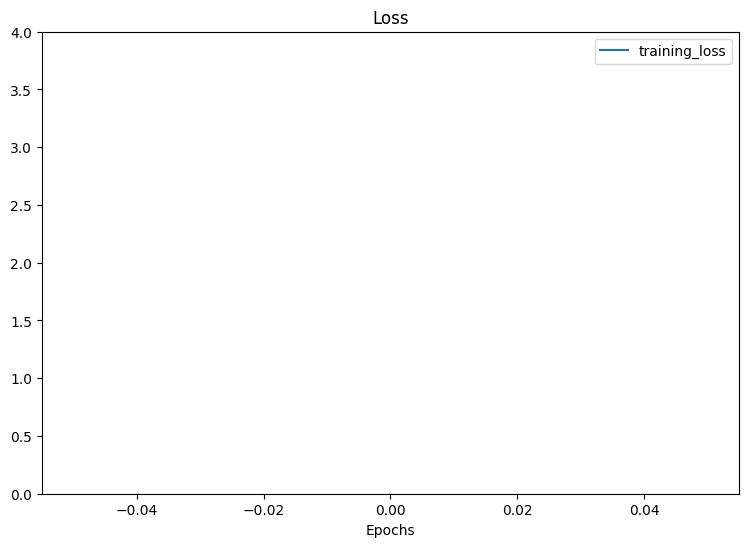

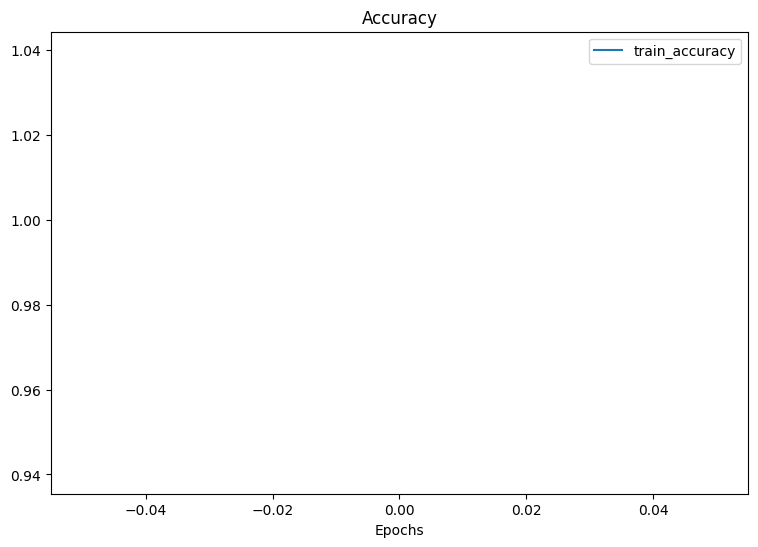

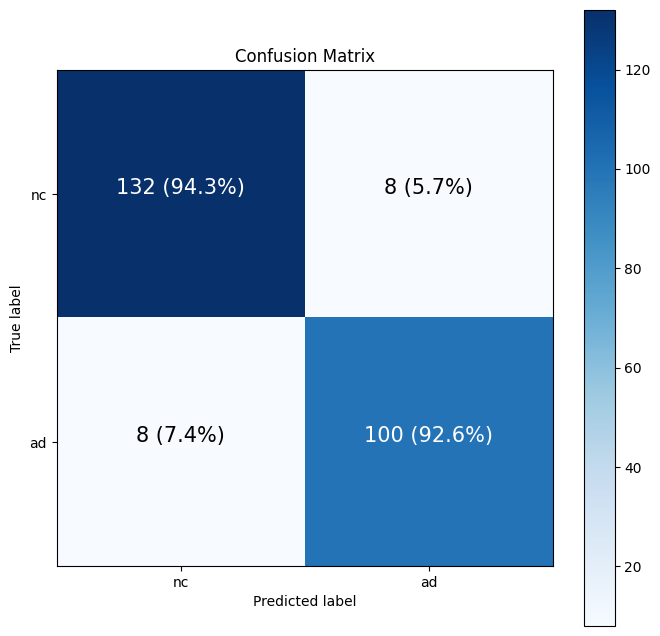

In [ ]:
# --- Train the model with the best hyperparameters and evaluate it on the test set ---

# Hyperparameters
BEST_LR = 3e-6 # Learning rate
BEST_WD= 2e-4 # Weight decay
BEST_NUM_EPOCHS = 1 # Number of epochs for training
use_optimizer = "adam" # Choose optimizer: "adam" or "sgd"

train_for_more_epochs = False 

cosine_scheduler = False # Set to True if using cosine decay, False if using fixed learning rate

# Filepath to save/load the model
SAVED_MODEL_FILEPATH = "/home/diogommiranda/tese/outputs/best_model.pth"


# Create the model
resnet_feature_extractor = ResnetFeatureExtractor(resnet_config=resnet_config, device=device, trained_path=resnet_path, use_pretrained=use_pretrained)
model = ResNetViT(resnet_feature_extractor, vit_config).to(device)

# Load saved model or train anew
if train_for_more_epochs:
    model.load_state_dict(torch.load(SAVED_MODEL_FILEPATH, weights_only=True, map_location=device)) # load model to continue training for more epochs
    print(f"\nLoading model weights to continue training for more epochs.")
else:
    print(f"\nTraining the model from scratch with the best hyperparameters.")

# Compute class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
print(f"  Train label counts: {dict(zip(unique_classes, class_counts))}")
pos_weight_val = class_counts[0] / class_counts[1]
pos_weight_val = torch.tensor([pos_weight_val], device=device)
print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)

if use_optimizer == "adam":
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=current_lr, weight_decay=current_wd)
elif use_optimizer == "sgd":
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=current_lr, weight_decay=current_wd, momentum=0.9, nesterov=True)

optimizer_name = optimizer.__class__.__name__

scheduler = None
if cosine_scheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7) # T_max=100 for 100 epochs (used in CV)

history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': []}

for epoch in tqdm(range(BEST_NUM_EPOCHS)):
    epoch_start_time = time.time()
    history['epoch'].append(epoch + 1)

    model.train()
    
    # Freeze BatchNorm layers if using pretrained model
    if use_pretrained:
        model.resnet_feature_extractor.eval()
    
    running_loss = 0.0
    train_pred_probs = []
    train_targets = []

    for i, (inputs, labels) in enumerate(train_data):
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        
        prob_outputs = torch.sigmoid(outputs)
        train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
        train_targets.extend(labels.detach().cpu().numpy())

    train_targets = np.array(train_targets).flatten()
    train_pred_probs = np.array(train_pred_probs).flatten()
    
    # Calculate training metrics for the epoch
    train_loss = running_loss / len(train_data.dataset)
    train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
    train_auc = roc_auc_score(train_targets, train_pred_probs)
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['train_auc'].append(train_auc)
        
    epoch_duration = time.time() - epoch_start_time
    print(f"    Epoch {epoch+1}/{BEST_NUM_EPOCHS} [{epoch_duration:.2f}s] - Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f}")
    
    if scheduler:
        scheduler.step()

# Save the model if using fixed learning rate in case we want to continue training it
if not cosine_scheduler:
    torch.save(model.state_dict(), SAVED_MODEL_FILEPATH)
    print(f"Model saved to: {SAVED_MODEL_FILEPATH}")

plot_loss_curves(history)

# Evaluate the model on the test data
model.eval()
test_running_loss = 0.0
test_pred_probs = []
test_targets = []

with torch.inference_mode():
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
    
        prob_outputs = torch.sigmoid(outputs)
        
        test_pred_probs.extend(prob_outputs.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_targets = np.array(test_targets).flatten()
test_pred_probs = np.array(test_pred_probs).flatten()

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_data.dataset)
test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

y_true = test_targets.astype(int)
y_pred = test_pred_probs.round().astype(int)

# Calculate metrics
accuracy = test_acc
sensitivity = recall_score(y_true, y_pred, pos_label=1)
specificity = recall_score(y_true, y_pred, pos_label=0)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

print("\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true, y_pred, target_names, figsize=(8, 8), text_size=15)


In [ ]:
save_option = False # Set to True to save the model, confusion matrix, and evaluation metrics

if save_option:
    save_model_dir = "/home/diogommiranda/tese/outputs/resnetvit/" + DATASET + "/" + dir1 + dir2 + str(BATCH_SIZE) + "B/" + "saved_models/" + f"LR={BEST_LR:.1e}_WD={BEST_WD:.0e}"
    print(f"Saving model to: {save_model_dir}")
    os.makedirs(save_model_dir, exist_ok=True)

    # Save the model
    torch.save(model.state_dict(), os.path.join(save_model_dir, "model.pth"))

    # Save the confusion matrix plot
    make_confusion_matrix(y_true=y_true,
                        y_pred=y_pred.round(),
                        classes=target_names,
                        figsize=(8, 8),
                        text_size=15,
                        save_dir=save_model_dir)

    # Save the test loss and accuracy and the evaluation metrics
    result_file_path = os.path.join(save_model_dir, "resultados.txt")
    with open(result_file_path, "w") as f:
        f.write(f"[{test_loss}, {test_acc}]\n\n")
        f.write("--- Evaluation Metrics on Test Set ---\n")
        f.write(f"Accuracy:    {accuracy:.4f}\n")
        f.write(f"Sensitivity: {sensitivity:.4f}\n")
        f.write(f"Specificity: {specificity:.4f}\n")
        f.write(f"Balanced Accuracy (BACC): {bacc:.4f}\n")
        f.write(f"F1 Score (Weighted):      {f1:.4f}\n")
        f.write(f"Matthews Corr Coef (MCC): {mcc:.4f}\n")
        f.write(f"Area Under the Curve (AUC): {auc_score:.4f}\n")
        
        training_config = {
            "vit_config": vit_config,
            "num_epochs": BEST_NUM_EPOCHS,
            "lr_scheduler": lr_scheduler,
            "optimizer": optimizer_name,
            "optimizer_params": {
                "lr": float(BEST_LR),
                "weight_decay": float(BEST_WD)
            },
            "batch_size": BATCH_SIZE,
            "seed": seed,
            "dataset": DATASET
        }
        params_file_path = os.path.join(save_model_dir, "training_config.json")
        with open(params_file_path, "w") as f:
            json.dump(training_config, f, indent=4)

Saving model to: /home/diogommiranda/tese/outputs/resnetvit/nc_ad/pretrain/fixed_lr/4B/saved_models/LR=3.0e-06_WD=2e-04
